In [62]:
import pandas as pd
from pathlib import Path
import glob
import matplotlib.pyplot as plt
import numpy as np

In [63]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [64]:

import matplotlib
fontsize = 14
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'


In [65]:
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 200)

## ULX systems dataframe
This dataframe contains the ULXs selected for further analysis, originally obtained from the 36,420 systems created via STARTRACK by Greg.

In [66]:
def load_systems_dataframe(ulx_only=False, beamed=False, half_opening_l_45=False):
    systems_df_path = Path('../data/processed/all_systems_df.csv')
    df = pd.read_csv(systems_df_path)
    if ulx_only:
        df = df[df['Lx'] > 1E39]
    if beamed:
        df = df[df['b'] < 1]
    if half_opening_l_45:
        df = df[df['theta_half_deg'] < 45]
    df = df.reset_index()
    df = df.drop(columns=['index', 'Unnamed: 0'])
    return df

In [67]:
systems_df = load_systems_dataframe(True, False, False)
junk_columns = ['mdot_gs', 'XLsph', 'XLsph2', 'ratio', 'ratio_beamed', 'theta', 'theta_deg']
gr_columns = ['zeta', 'r_schw', 'r_isco_nospin', 'r_isco', 'r_out', 'P_wind', 'r_sph']
systems_df.drop([*junk_columns, *gr_columns], axis=1) #Drop unused/axilary column headers

systems_df[['Z', 'tage', 'm', 'mdot', 'is_bh', 'b', 'Lx', 'LEdd', 'LXtot']]

Z  tage     m   mdot  is_bh         b            Lx          LEdd  \
0    0.0002    10  25.9   3.90      1  1.000000  8.641181e+39  3.108000e+39   
1    0.0002    10  28.3   2.70      1  1.000000  7.892165e+39  3.396000e+39   
2    0.0002    10  15.5   1.70      1  1.000000  4.581845e+39  1.860000e+39   
3    0.0002    10  24.6  36.00      1  0.021967  6.792264e+41  2.952000e+39   
4    0.0002    10  28.8   6.70      1  0.869234  1.278377e+40  3.456000e+39   
..      ...   ...   ...    ...    ...       ...           ...           ...   
987  0.0002   500   1.1   0.30      0  0.109805  5.108769e+39  1.320000e+38   
988  0.0020  1000   1.3   6.10      0  0.003200  3.458794e+41  1.560000e+38   
989  0.0002  1000   1.3   0.20      0  0.345069  1.662420e+39  1.560000e+38   
990  0.0200  2000   1.3   0.29      0  0.164123  3.848411e+39  1.560000e+38   
991  0.0002  2000   1.3   0.24      0  0.239631  2.512576e+39  1.560000e+38   

            LXtot  
0    8.641181e+39  
1    7.892165e+39  
2    4.581845e+39  
3    1.492042e+40  
4    1.111208e+40  
..            ...  
987  5.609677e+38  
988  1.106814e+39  
989  5.736488e+38  
990  6.316127e+38  
991  6.020909e+38  

[992 rows x 9 columns]

### Additional columns
These columns are for various quantities that we have not yet used...

In [68]:
systems_df[gr_columns]

zeta  r_schw  r_isco_nospin  r_isco         r_out        P_wind  \
0          NaN     2.0            6.0    1.25           NaN           NaN   
1          NaN     2.0            6.0    1.25           NaN           NaN   
2          NaN     2.0            6.0    1.25           NaN           NaN   
3     4.691953     2.0            6.0    1.25  1.367081e+04  3.485596e+07   
4     2.000000     2.0            6.0    1.25  1.288436e+02  6.657966e+01   
..         ...     ...            ...     ...           ...           ...   
987   2.000000     2.0            6.0    6.00  1.377452e+04  1.910142e+09   
988  36.703821     2.0            6.0    6.00  3.822688e+06  2.797528e+16   
989   2.000000     2.0            6.0    6.00  2.472582e+03  1.668124e+07   
990   2.000000     2.0            6.0    6.00  7.537974e+03  4.007780e+08   
991   2.000000     2.0            6.0    6.00  4.272621e+03  7.914683e+07   

           r_sph  
0       7.414565  
1       4.697839  
2       5.400551  
3      72.059002  
4      11.455213  
..           ...  
987   154.704125  
988  2661.704312  
989    87.268994  
990   126.540041  
991   104.722793  

[992 rows x 7 columns]

## Alive/dead simulation results
These results were the original set where 500 ULXs were sampled in a desired neutron star, and each drawn system had lightcurves created corresponding to a single random inclination and over all precessional angles from 1 - 45.

After around 5m rows, I then realised that this method was somewhat inefficient. Instead, one need not specify a black hole to neutron star ratio when creating the lightcurves but instead create many lightcurves for the 992 ULX systems, calculating their alive/dead time, then sampling from these results in the required BH/NS ratio.

In doing this, one problem I realised was that some of the ULX systems were not drawn enough times and so their inclinations were poorly sampled...

There was no need to toss out the old simulations, as it was only a case of sampling more and appending to the already simulated lightcurves.

=======================================

I have now combined both old and new results into a single df_a.csv

In [69]:
#I only ran these simulations to 0.4 BH_NS ratio before realising my method could be faster.
df_a = pd.read_csv('../data/processed/df_a.csv')

In [70]:
my_list = list(systems_df.is_bh)
Z_list = list(systems_df.Z)

is_bh = [my_list[s] for s in df_a['system_id']]
Z = [Z_list[s] for s in df_a['system_id']]
df_a['is_bh'] = is_bh
df_a['Z'] = Z

df_a['classification'] = 'transient'
df_a.loc[df_a['ratio'] == 0, 'classification'] = 'dead'
df_a.loc[df_a['ratio'] == 1, 'classification'] = 'alive'

df_a.head()

Unnamed: 0  system_id  period  phase     theta  inclination  dincl  beta  \
0           0        938    10.0    0.0  4.584886        64.82   18.0   0.2   
1           1        938    10.0    0.0  4.584886        64.82    9.0   0.2   
2           2        938    10.0    0.0  4.584886        64.82    3.0   0.2   
3           3        938    10.0    0.0  4.584886        64.82   19.0   0.2   
4           4        938    10.0    0.0  4.584886        64.82   24.0   0.2   

   dopulse  norm      alive       dead     ratio  is_bh      Z classification  
0        0   1.0   0.000000  49.968944  0.000000      0  0.002           dead  
1        0   1.0   0.000000  49.968944  0.000000      0  0.002           dead  
2        0   1.0   0.000000  49.968944  0.000000      0  0.002           dead  
3        0   1.0   3.897136  46.029198  0.078058      0  0.002      transient  
4        0   1.0  11.093265  38.849686  0.222119      0  0.002      transient

In [71]:
df_a_alive = df_a[df_a['classification'] == 'alive']
df_a_transient = df_a[df_a['classification'] == 'transient']
df_a_dead = df_a[df_a['classification'] == 'dead']

Text(0, 0.5, 'Number of systems')

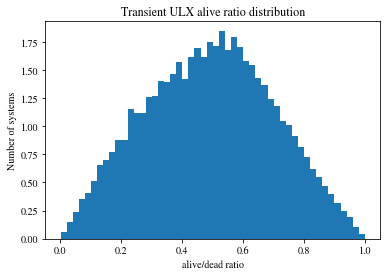

In [72]:
plt.title('Transient ULX alive ratio distribution')
plt.hist(df_a_transient['ratio'], bins=50, density=True)


plt.xlabel('alive/dead ratio')
plt.ylabel('Number of systems')

In [ ]:
density = False
alpha = 0.5

hist_list = [df_a_transient['dincl'],df_a_dead['dincl'],df_a_alive['dincl']]

#plt.hist(hist_list, bins=45, stacked=False, histtype='bar')


#plt.hist(df_a_transient['dincl'], bins=45, density=density, label='Transient', alpha = 1.0, stacked=True)
#plt.hist(df_a_dead['dincl'], bins=45, density=density, label='Dead', alpha = 0.6, stacked=True)
#plt.hist(df_a_alive['dincl'], bins=45, density=density, label='Alive', alpha = 0.6, stacked=True)

plt.figure(figsize=(4,3))
plt.xlabel(r'Precessional angle $\Delta i$')
plt.ylabel('Number of systems')


df_a_alive['dincl'].value_counts().sort_index().plot(label='Alive', c='black', linewidth=0.8)
df_a_transient['dincl'].value_counts().sort_index().plot(label='Transient', c='black', linestyle='--', linewidth=0.8)
df_a_dead['dincl'].value_counts().sort_index().plot(label='Dead', c='black', linestyle=':', linewidth=0.9)

plt.tight_layout()
plt.xticks(np.arange(0,50,5))
plt.xlim(1,45)
plt.legend()
plt.savefig('../reports/figures/dincl_vs_n_adt.png')
plt.savefig('../reports/figures/dincl_vs_n_adt.pdf')
plt.savefig('../reports/figures/dincl_vs_n_adt.eps')


In [74]:
df_a_dead['dincl'].value_counts().sort_index()

0.0      5159
1.0     66845
2.0     65659
3.0     64427
4.0     63212
5.0     61946
6.0     60675
7.0     59415
8.0     58153
9.0     56900
10.0    55601
11.0    54289
12.0    53006
13.0    51721
14.0    50426
15.0    49115
16.0    47824
17.0    46514
18.0    45236
19.0    43996
20.0    42684
21.0    41380
22.0    40057
23.0    38801
24.0    37500
25.0    36252
26.0    34991
27.0    33672
28.0    32379
29.0    31064
30.0    29808
31.0    28573
32.0    27337
33.0    26005
34.0    24738
35.0    23519
36.0    22237
37.0    20950
38.0    19729
39.0    18535
40.0    17263
41.0    16100
42.0    14920
43.0    13708
44.0    12613
45.0    11505
Name: dincl, dtype: int64

In [75]:

print(df_a_alive['is_bh'].value_counts())
print(df_a_transient['is_bh'].value_counts())
print(df_a_dead['is_bh'].value_counts())

0    802013
1    206367
Name: is_bh, dtype: int64
0    2431530
1     238868
Name: is_bh, dtype: int64
0    1688796
1      67643
Name: is_bh, dtype: int64


In [76]:
#I've realised that some of the systems have far less simulations on them than others, this needs to be sorted
print(df_a['system_id'].value_counts().sort_values())

699     1845
888     1890
416     1935
303     2160
350     2205
35      2430
701     2475
140     2565
210     2610
127     2655
929     2655
855     2700
187     2790
442     3285
454     5664
142     5804
184     5813
887     5880
77      5949
334     5986
191     5997
159     6011
744     6031
807     6062
510     6082
166     6087
32      6159
881     6161
474     6166
69      6202
221     6203
274     6213
867     6255
529     6256
63      6256
278     6262
515     6264
509     6266
830     6309
453     6345
740     6345
408     6346
906     6356
103     6380
22      6384
23      6391
784     6434
789     6435
517     6436
695     6436
251     6436
786     6448
186     6449
108     6494
464     6500
381     6501
809     6524
164     6526
248     6526
917     6545
886     6574
777     6604
410     6613
605     6618
431     6621
914     6647
3       6648
418     6661
661     6678
691     6706
579     6745
678     6751
492     6751
179     6824
363     6827
868     6847
618     6849

In [77]:
print('number of neutron stars: 0, vs black holes: 1 simulated')
df_a['is_bh'].value_counts()

number of neutron stars: 0, vs black holes: 1 simulated


0    4922339
1     512878
Name: is_bh, dtype: int64

/home/x1/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:182: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


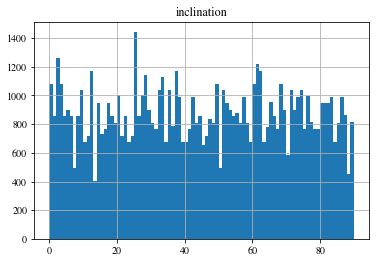

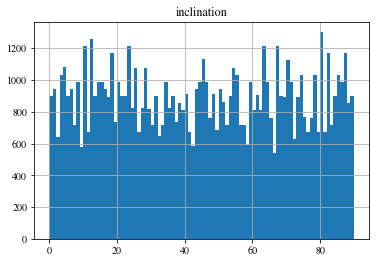

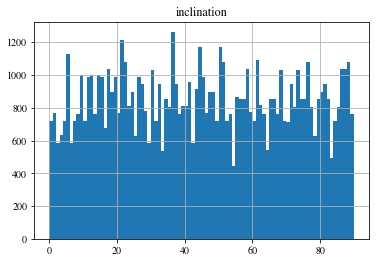

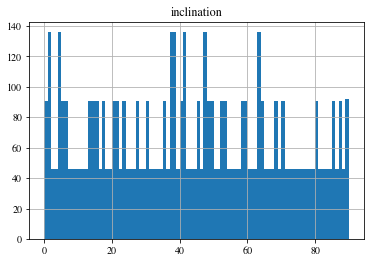

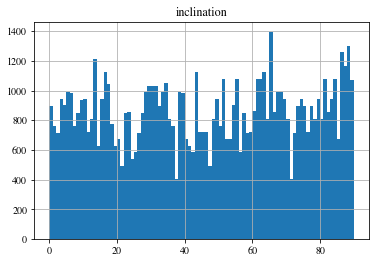

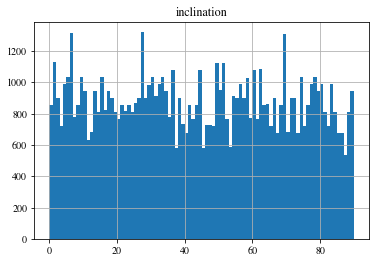

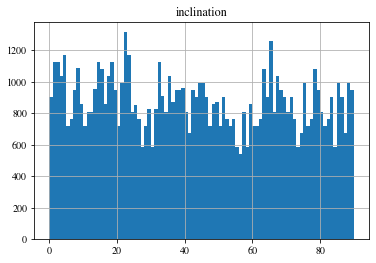

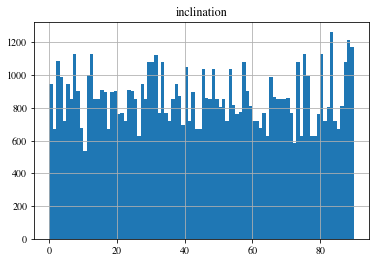

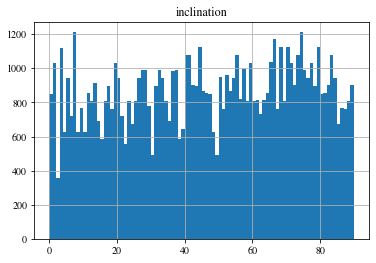

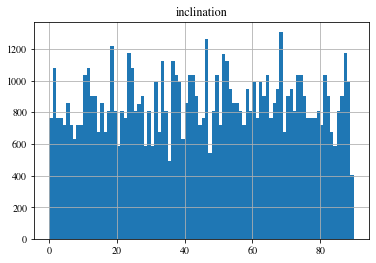

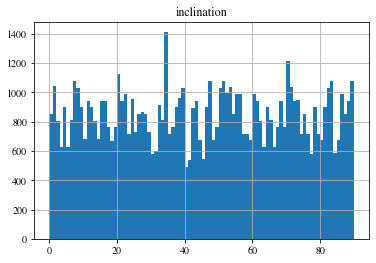

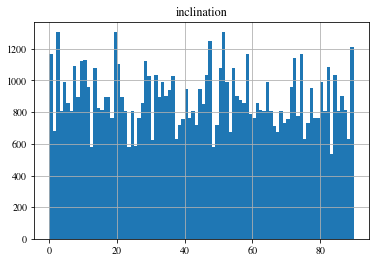

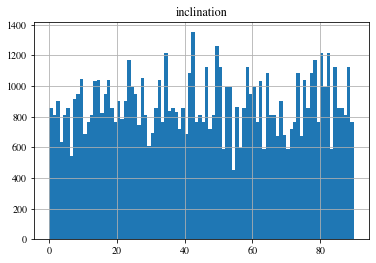

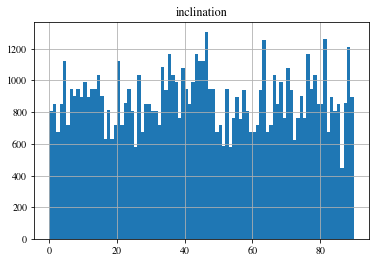

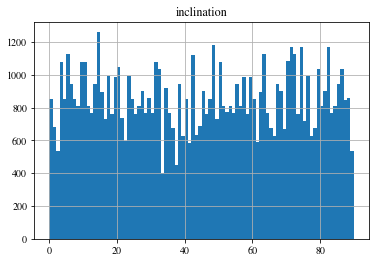

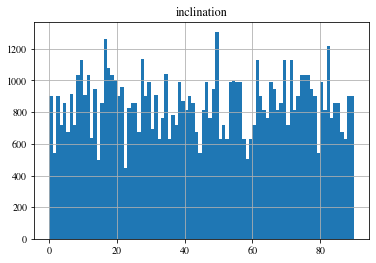

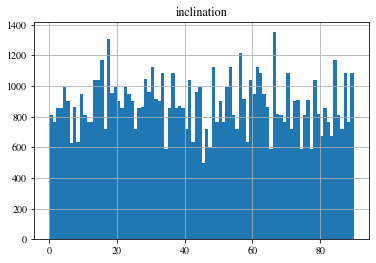

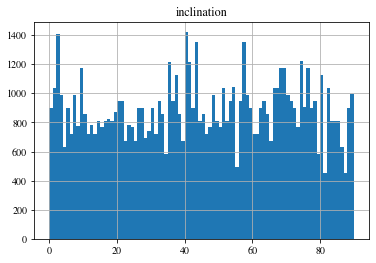

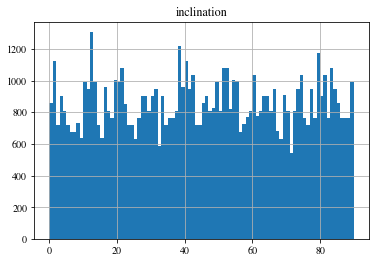

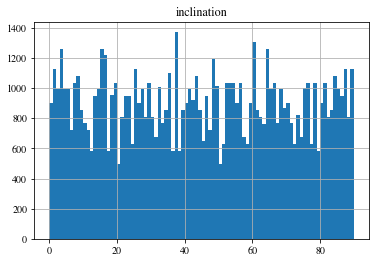

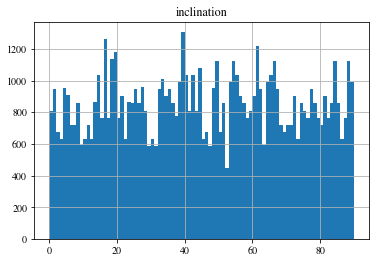

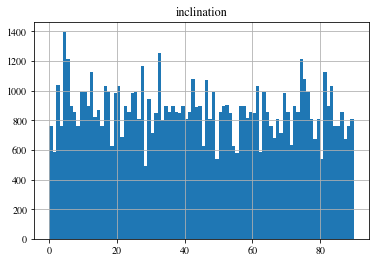

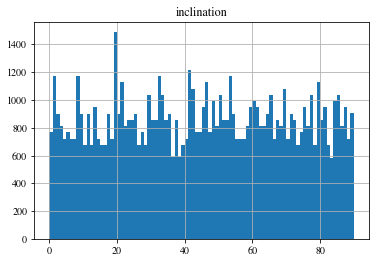

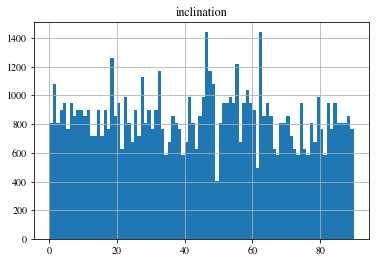

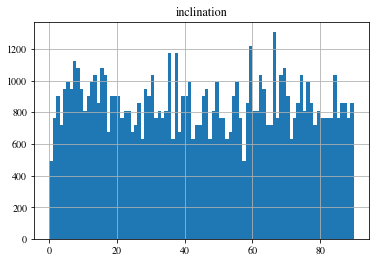

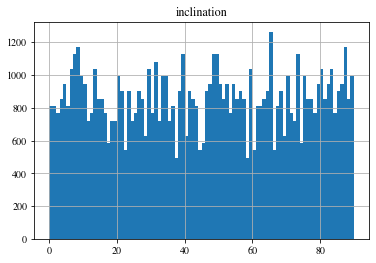

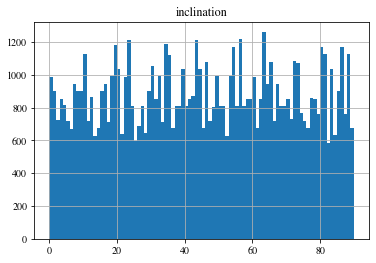

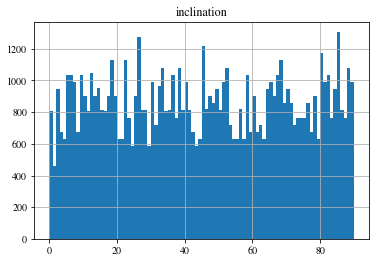

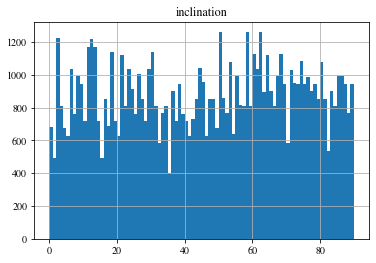

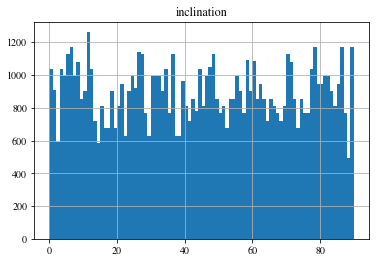

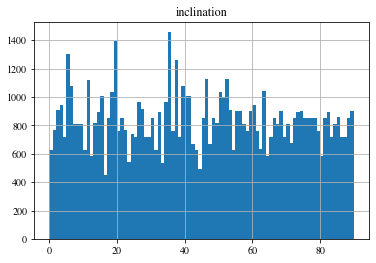

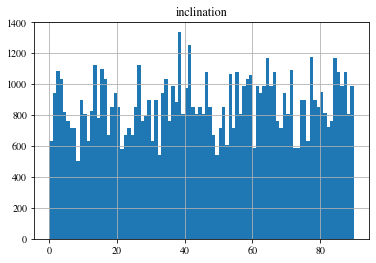

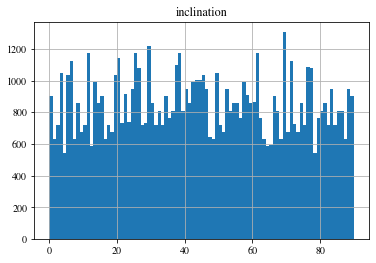

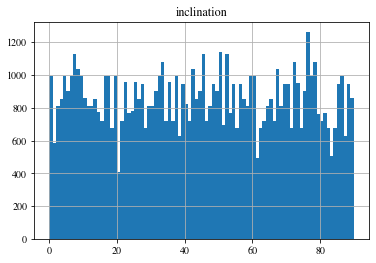

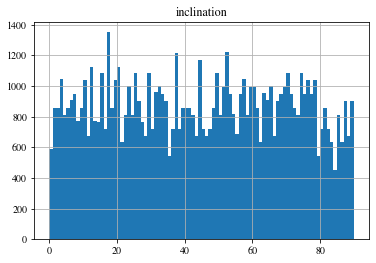

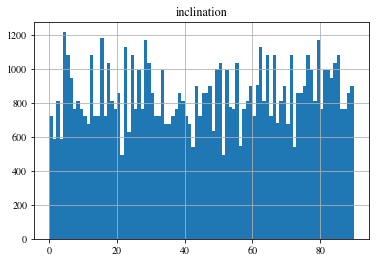

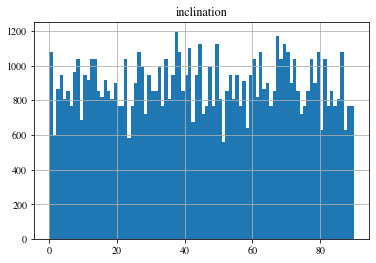

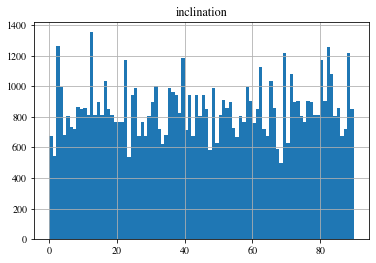

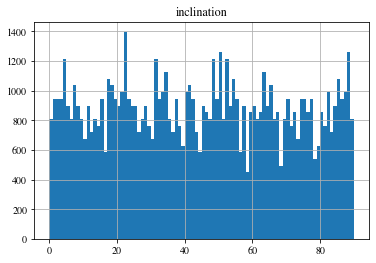

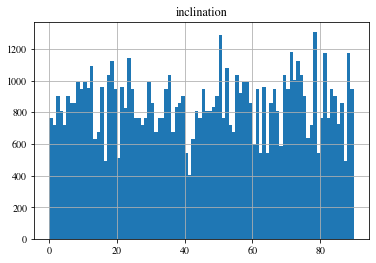

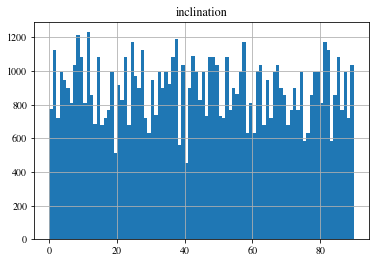

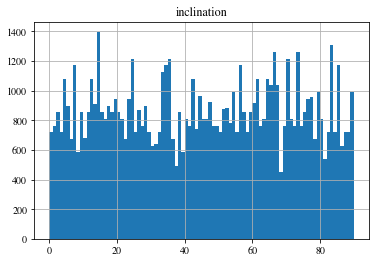

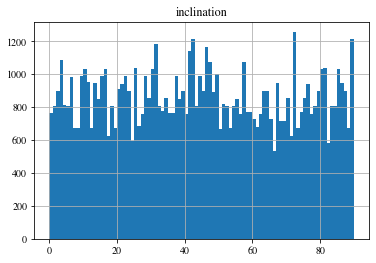

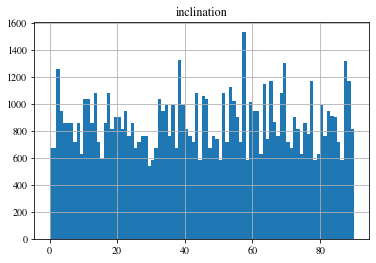

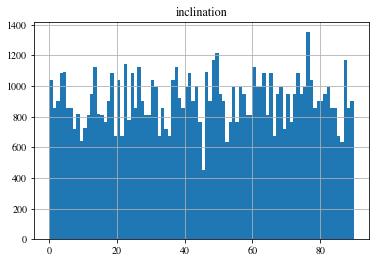

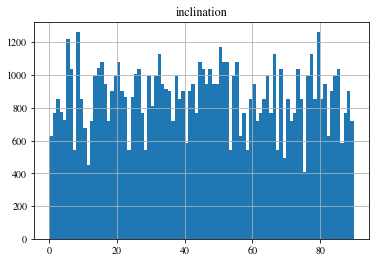

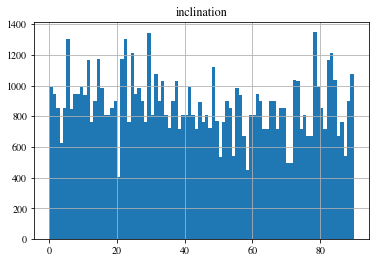

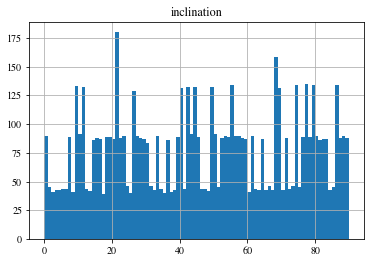

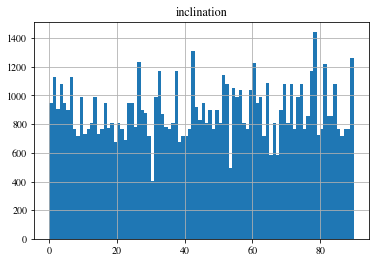

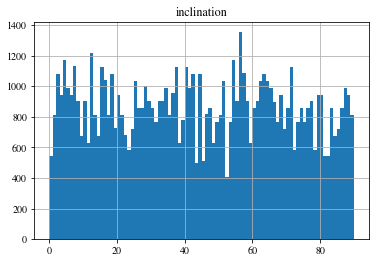

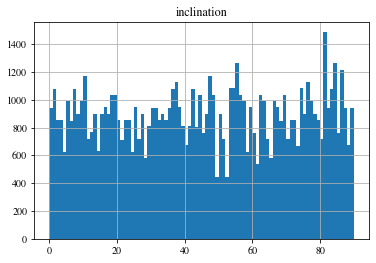

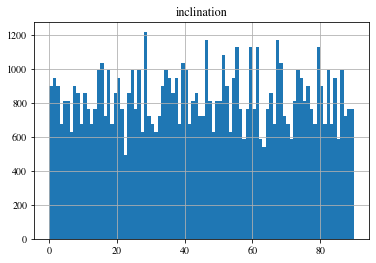

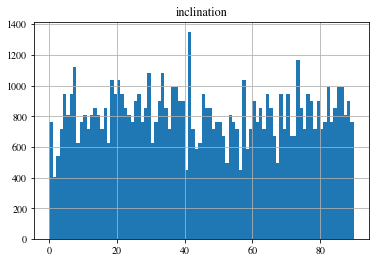

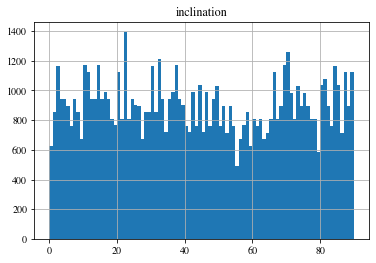

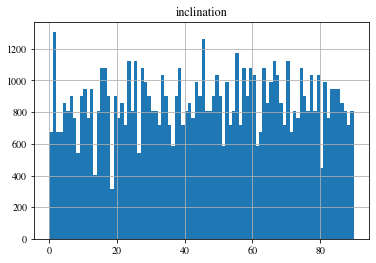

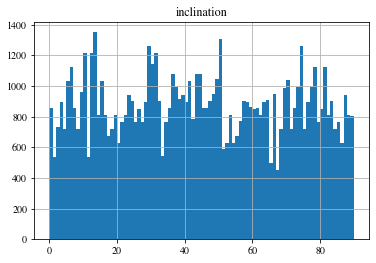

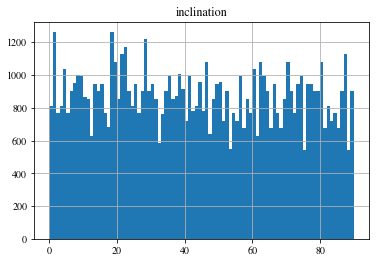

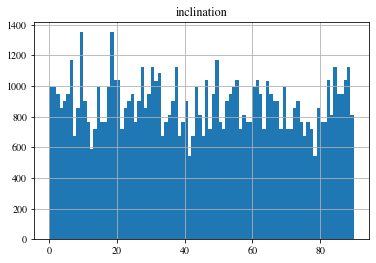

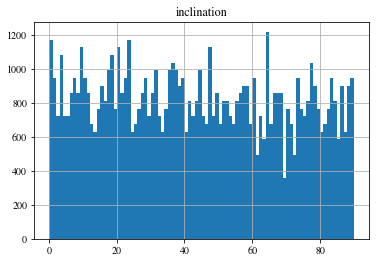

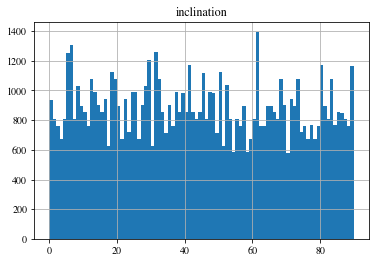

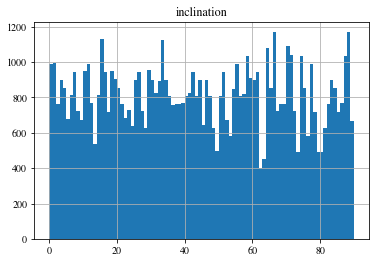

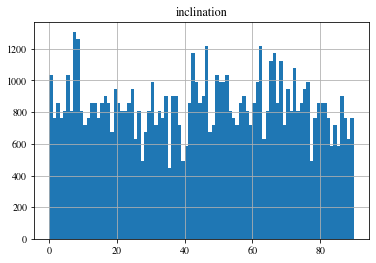

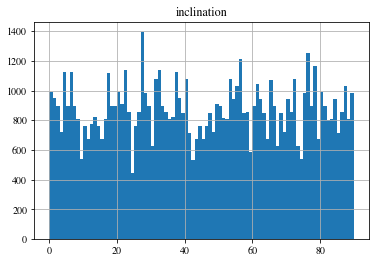

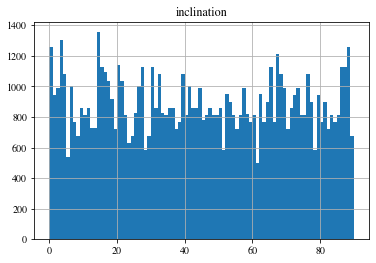

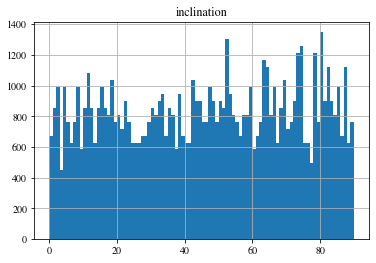

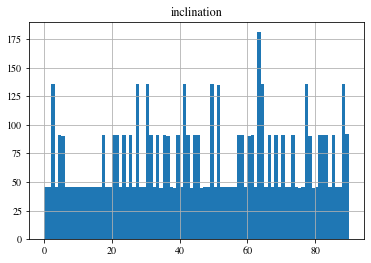

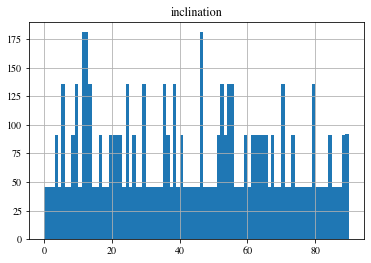

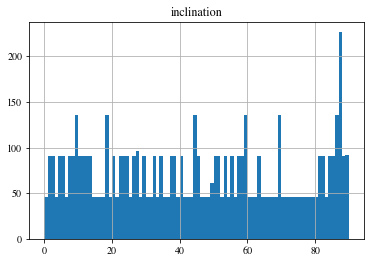

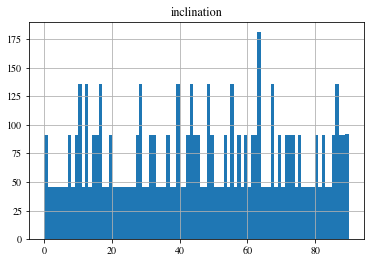

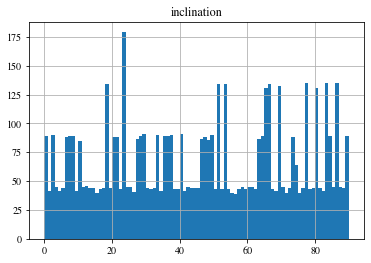

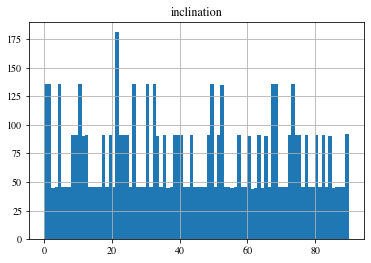

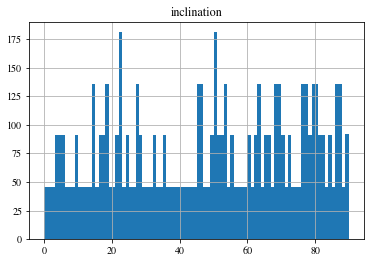

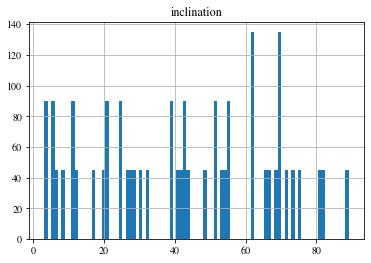

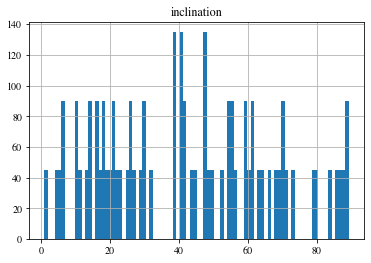

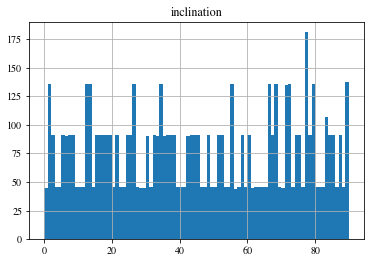

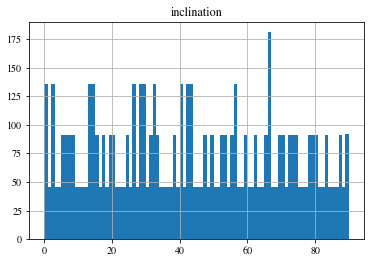

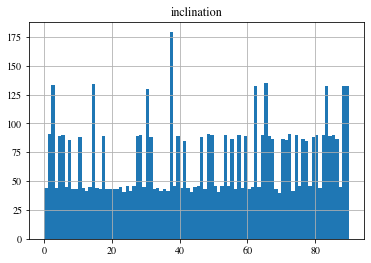

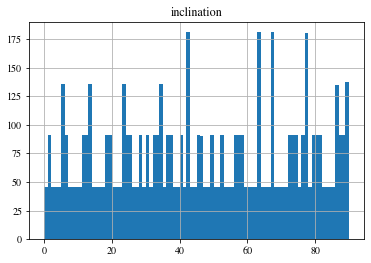

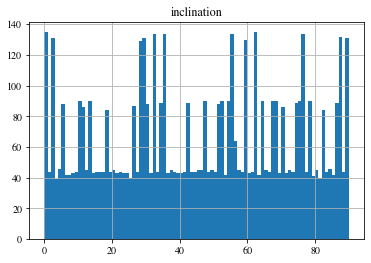

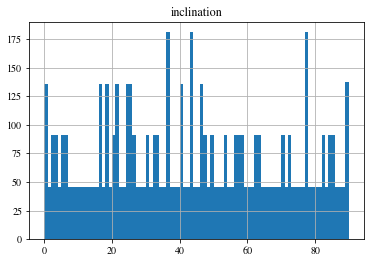

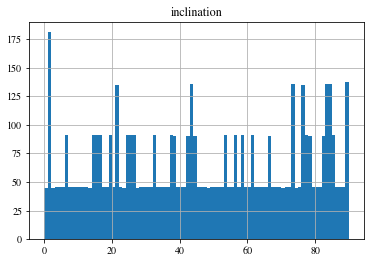

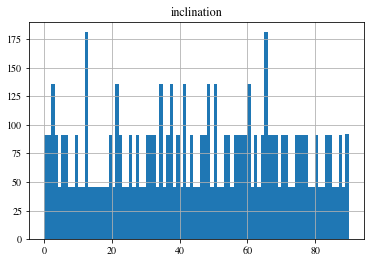

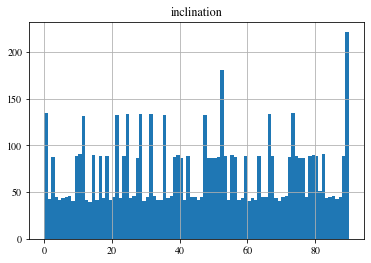

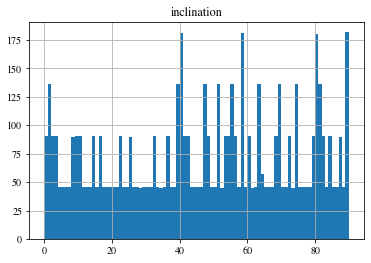

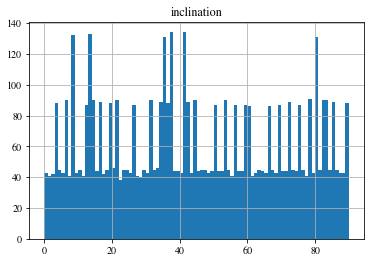

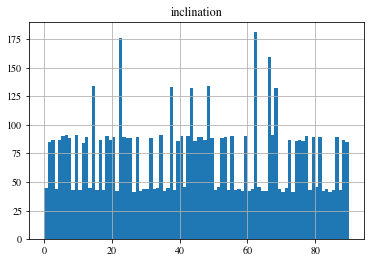

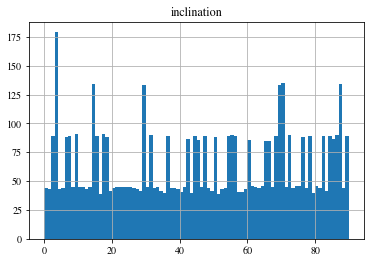

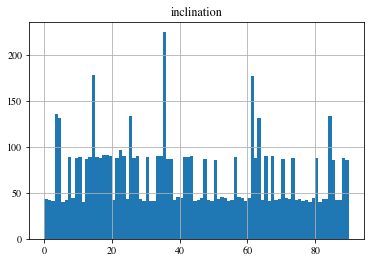

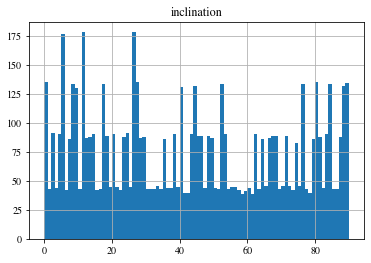

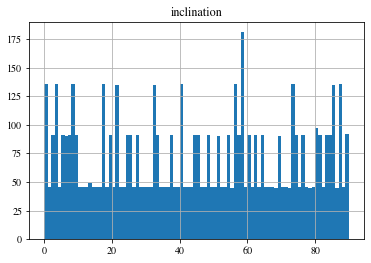

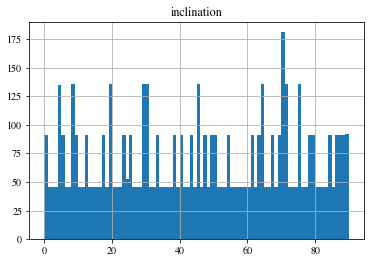

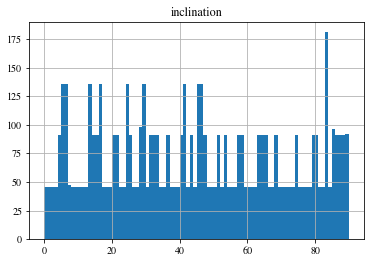

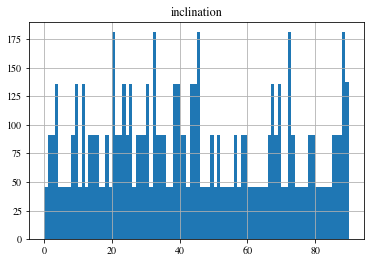

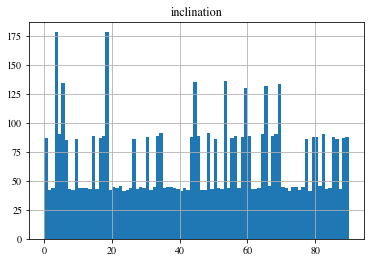

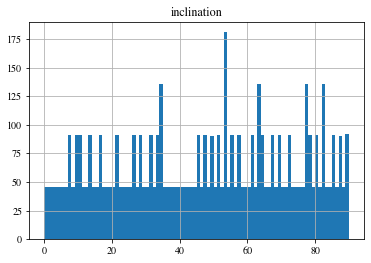

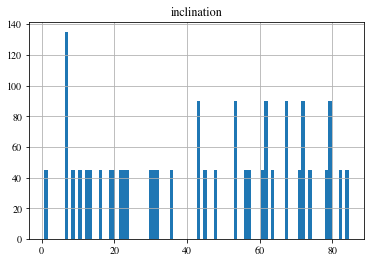

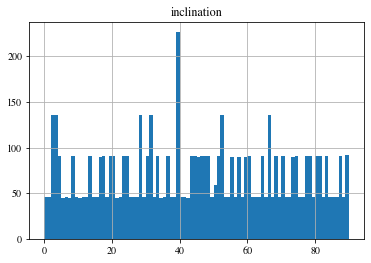

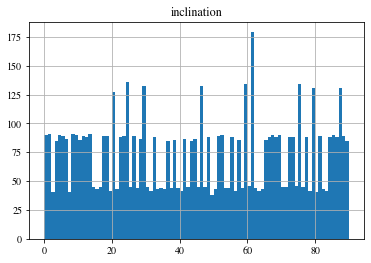

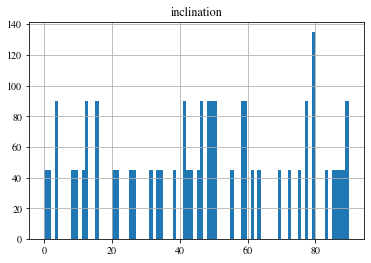

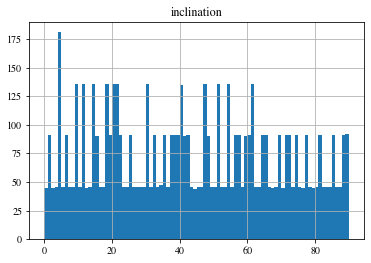

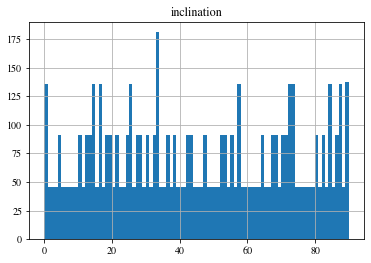

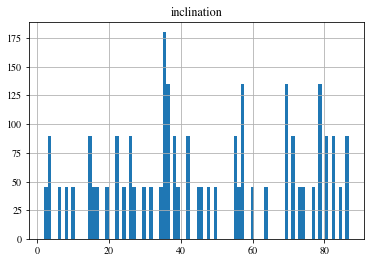

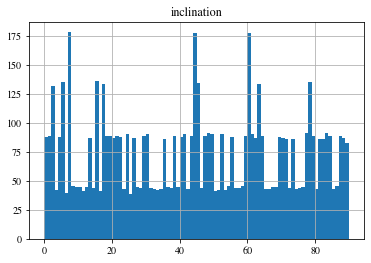

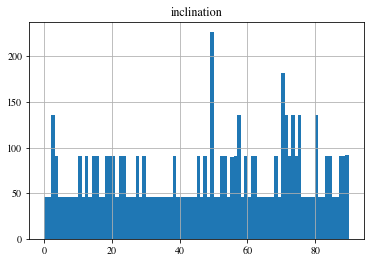

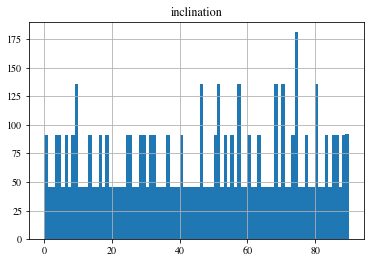

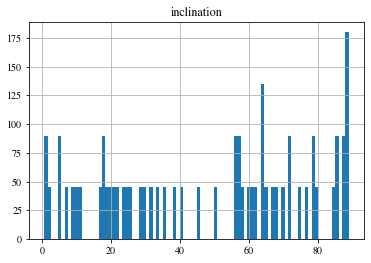

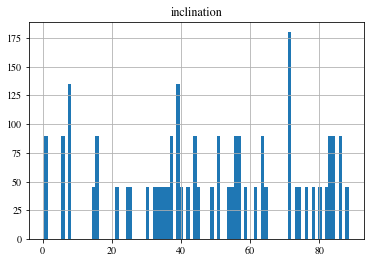

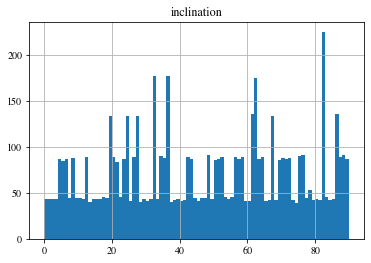

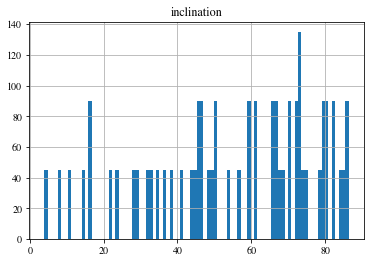

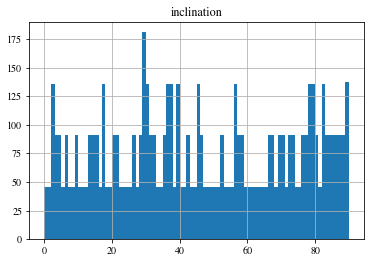

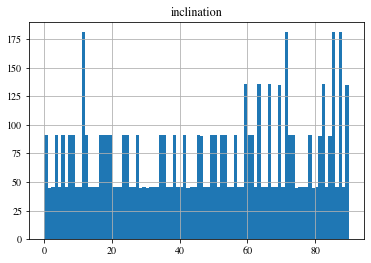

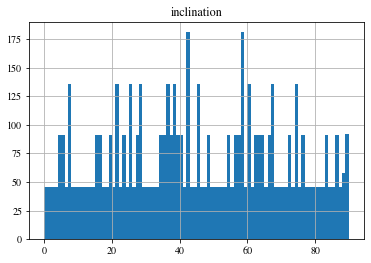

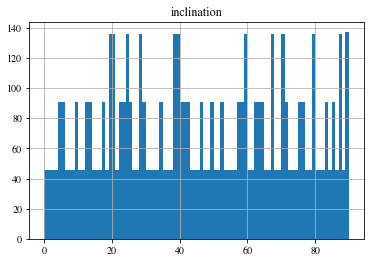

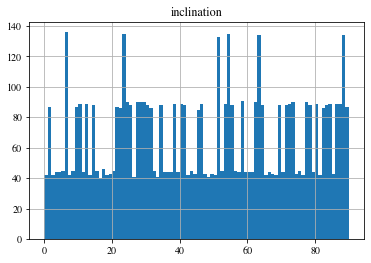

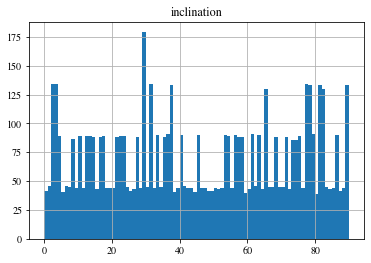

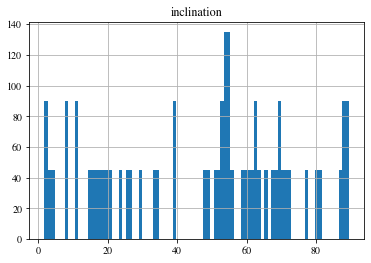

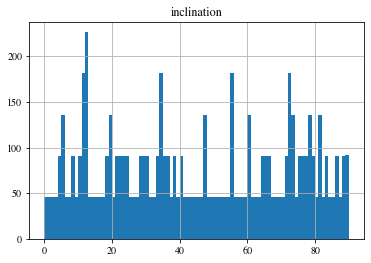

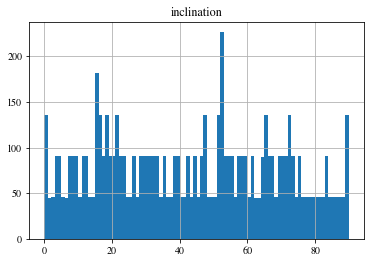

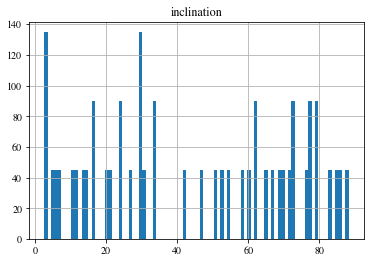

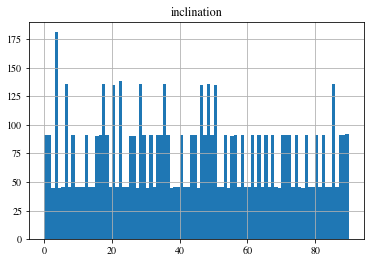

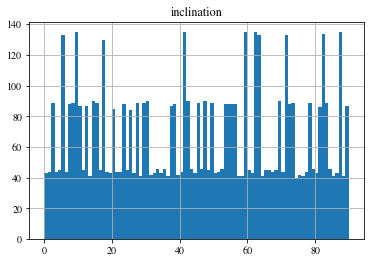

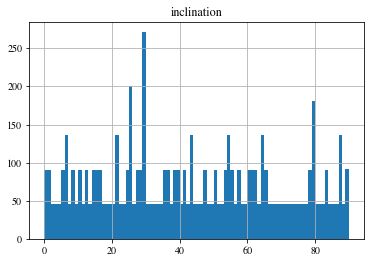

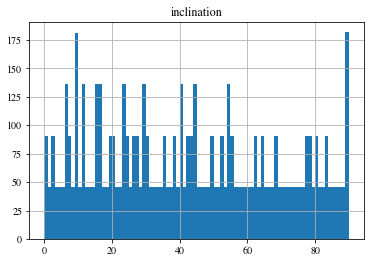

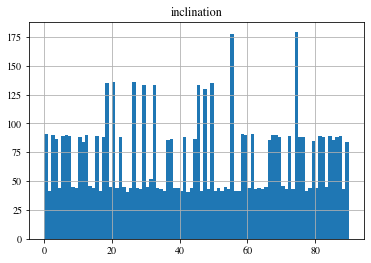

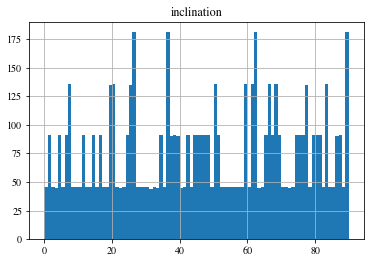

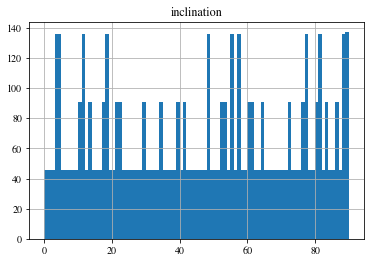

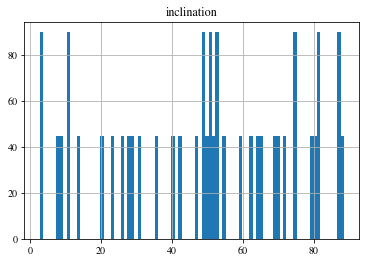

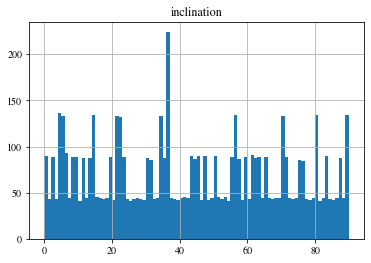

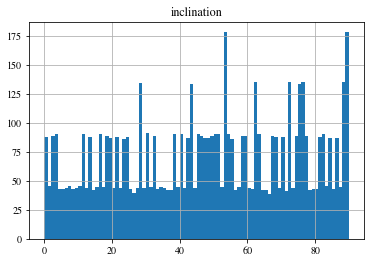

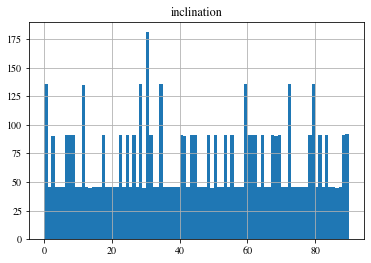

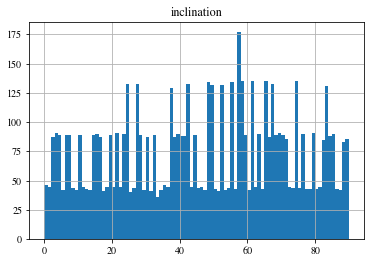

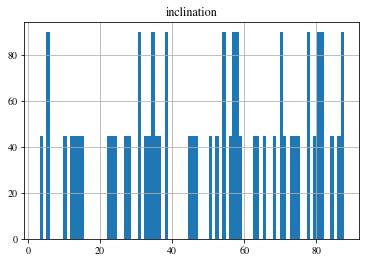

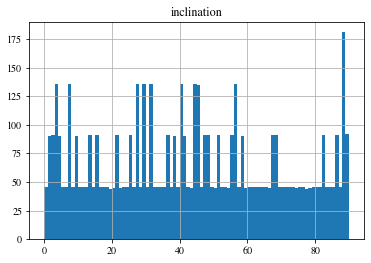

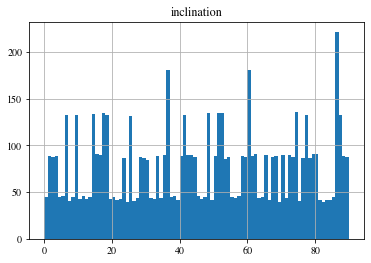

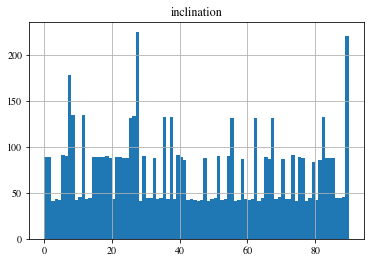

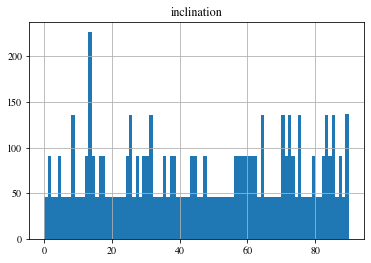

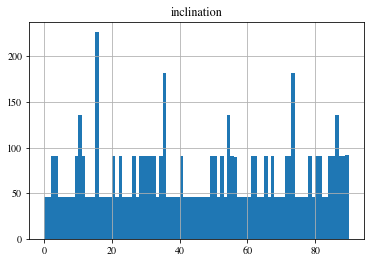

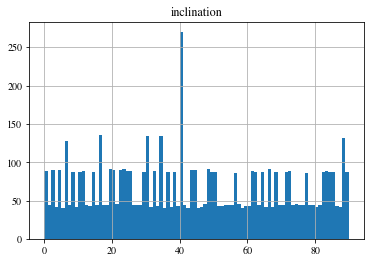

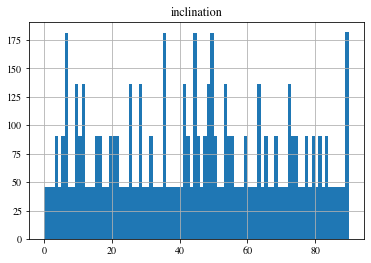

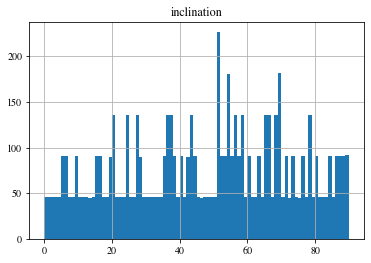

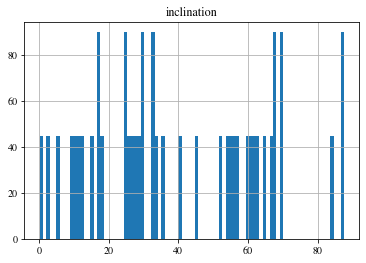

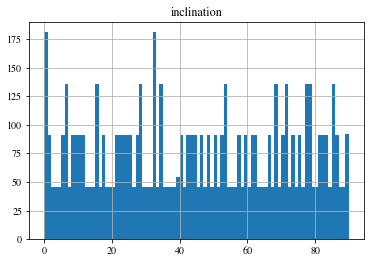

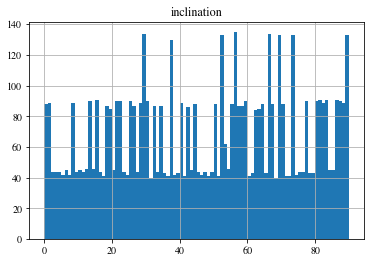

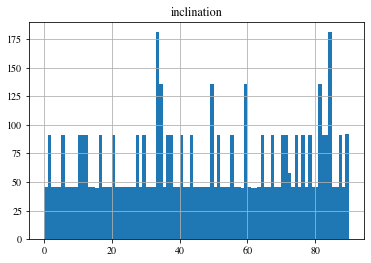

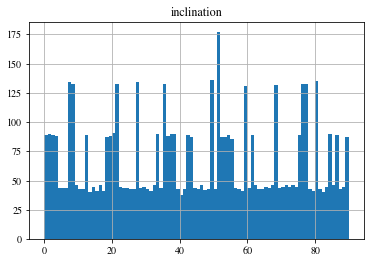

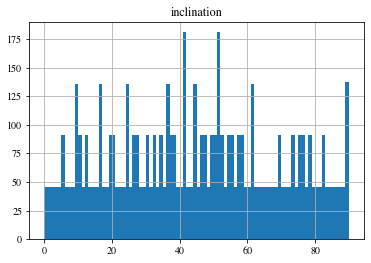

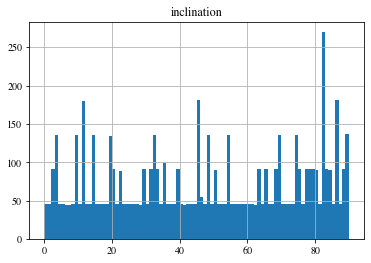

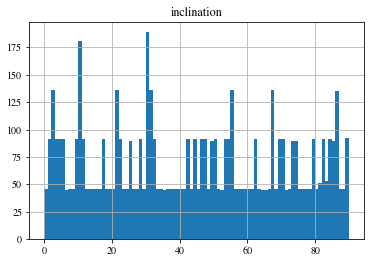

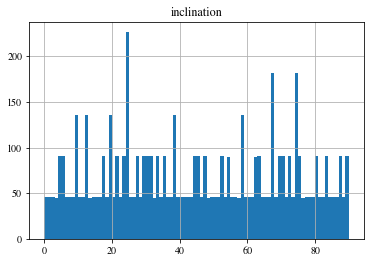

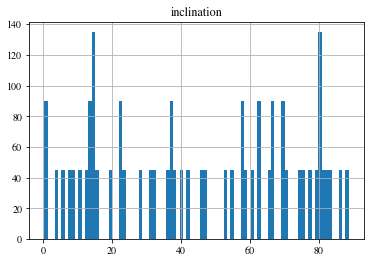

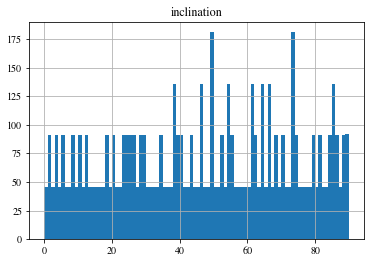

In [78]:
#Example of poorly sampled system
for sys_id in df_a['system_id'].unique():
    df_a[df_a['system_id'] == sys_id].hist('inclination', bins=90)

Text(0.5, 0, 'alive/dead ratio')

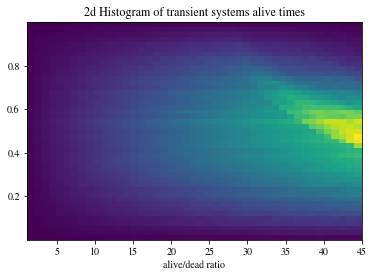

In [79]:
plt.hist2d(df_a_transient['dincl'], df_a_transient['ratio'], bins=45)
plt.title('2d Histogram of transient systems alive times')
plt.xlabel('dincl')
plt.xlabel('alive/dead ratio')

/home/x1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


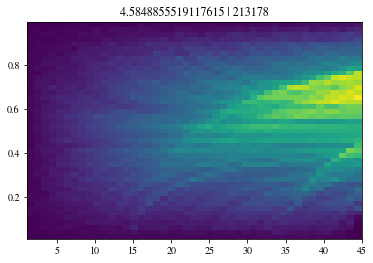

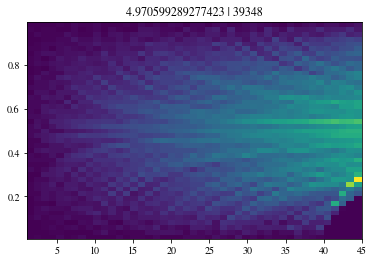

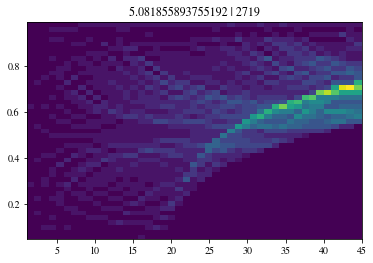

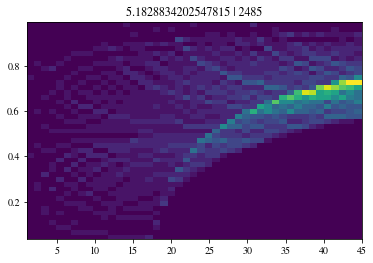

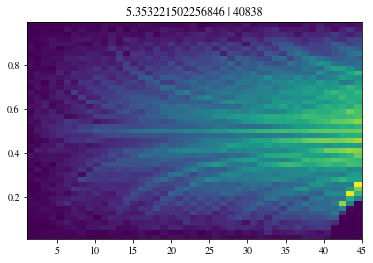

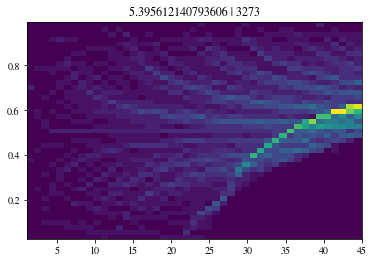

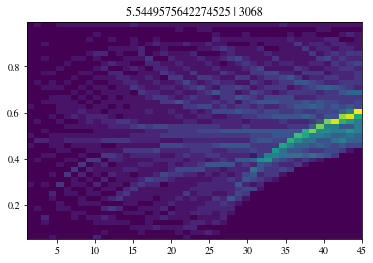

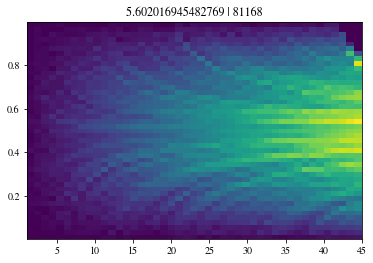

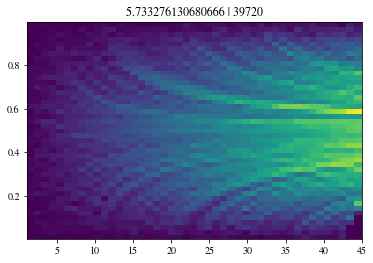

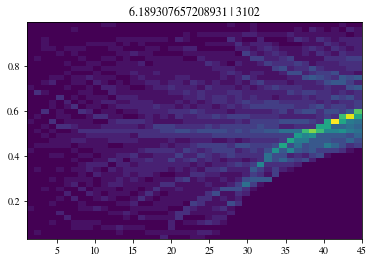

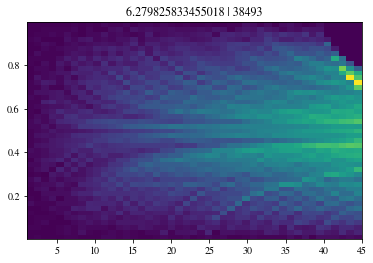

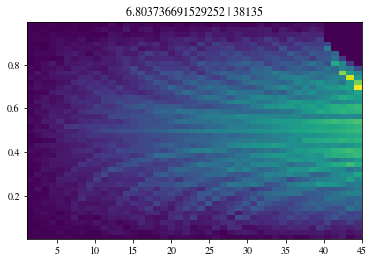

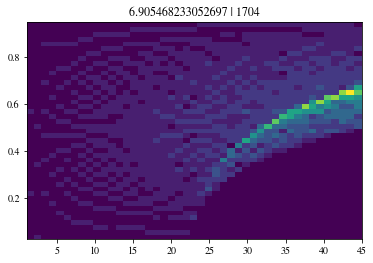

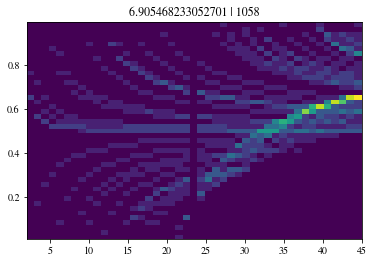

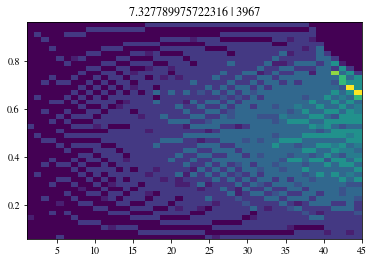

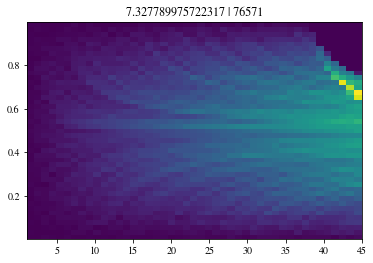

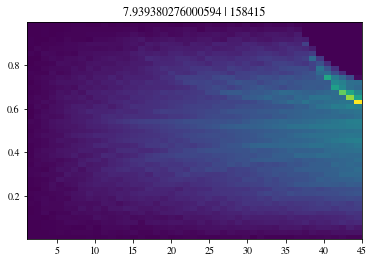

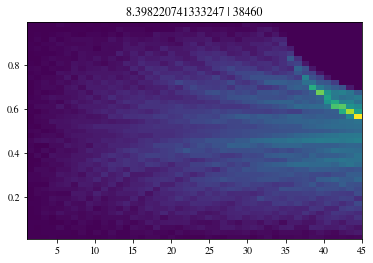

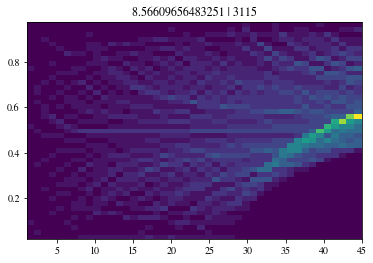

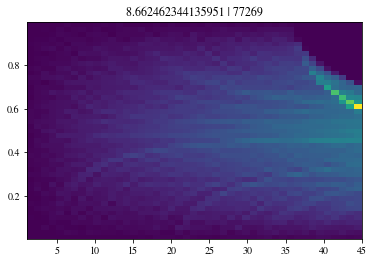

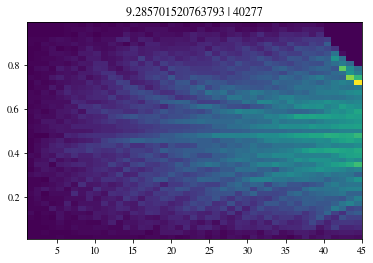

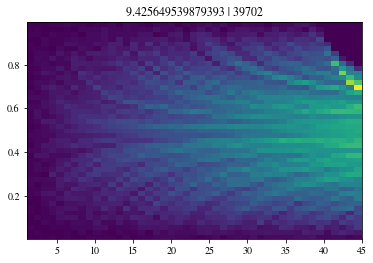

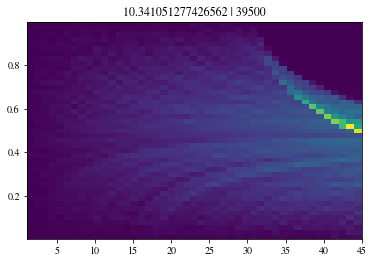

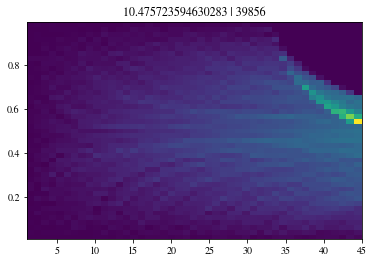

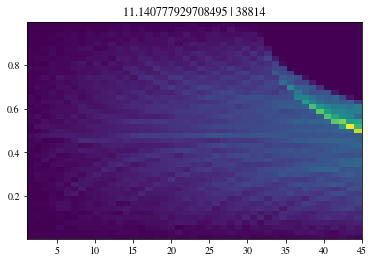

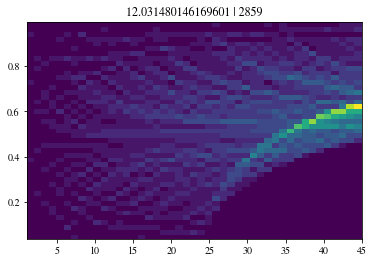

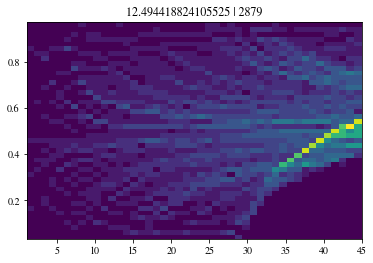

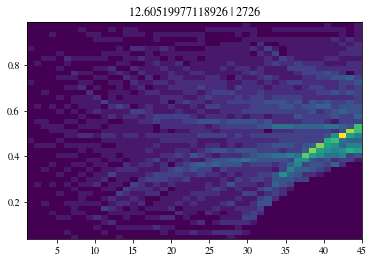

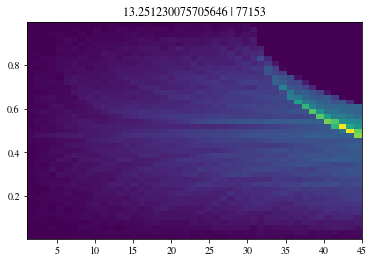

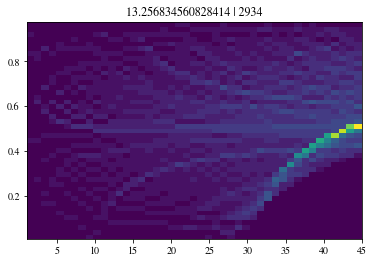

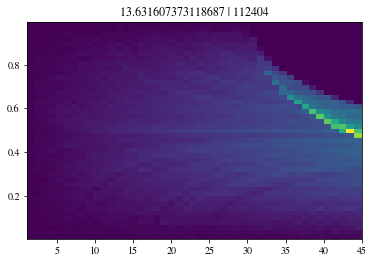

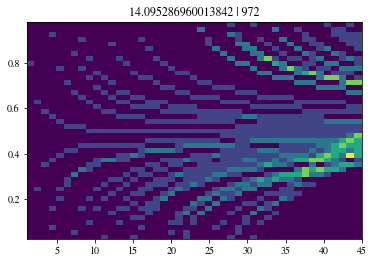

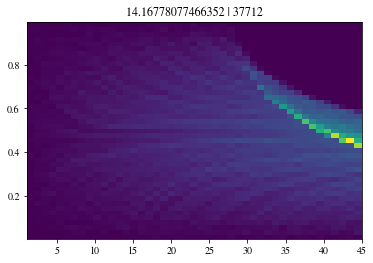

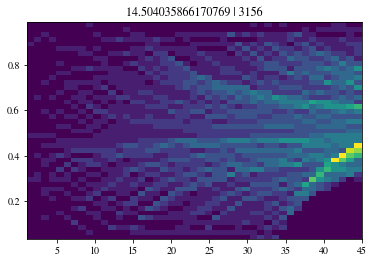

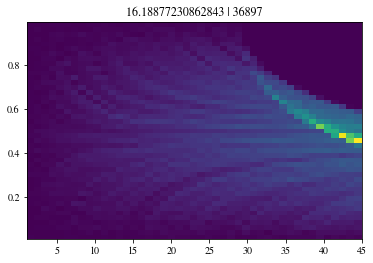

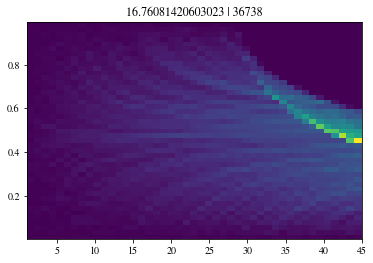

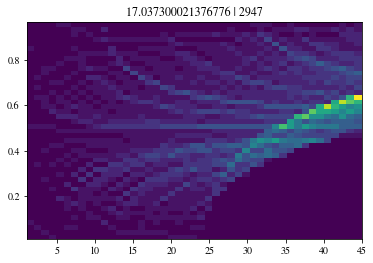

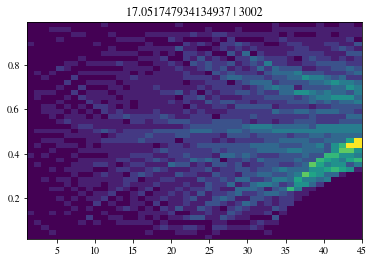

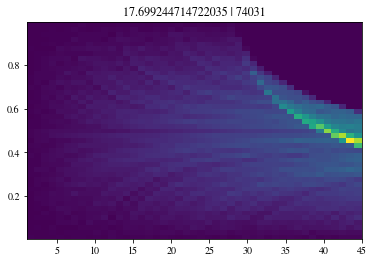

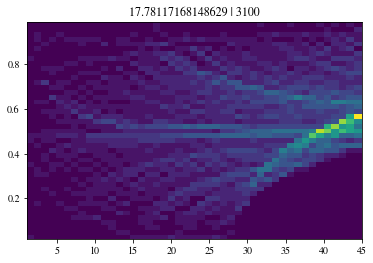

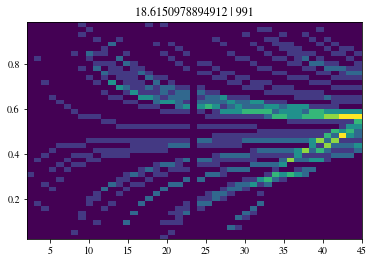

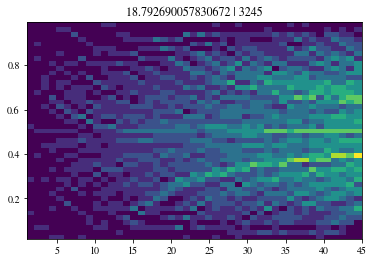

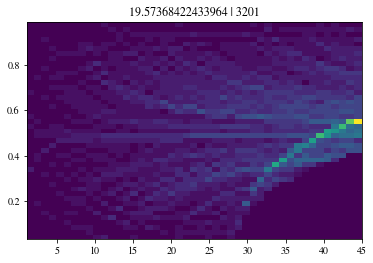

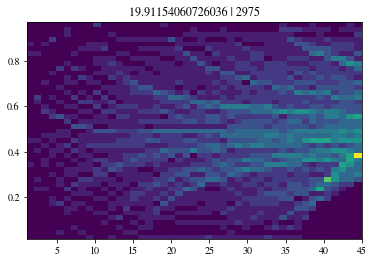

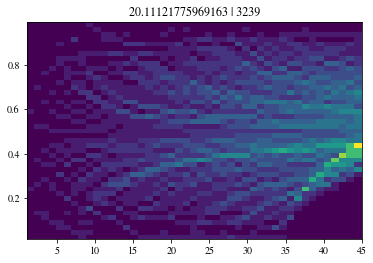

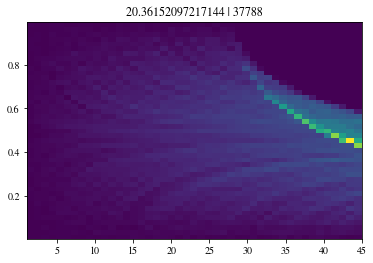

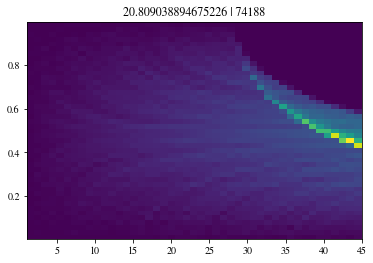

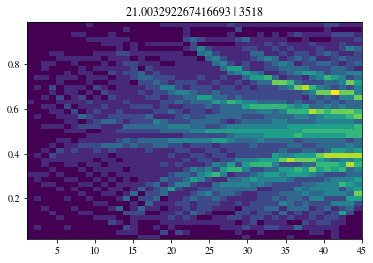

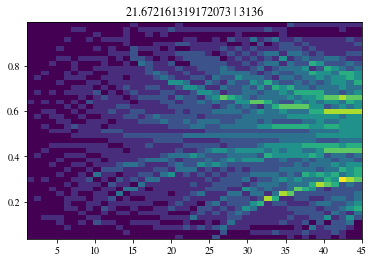

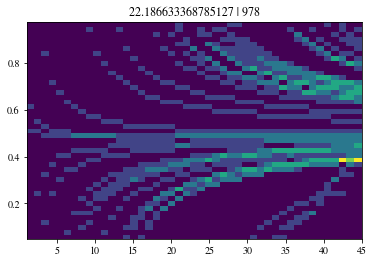

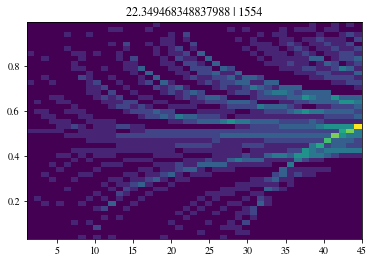

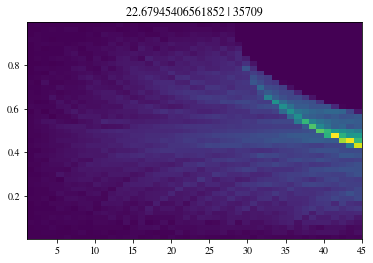

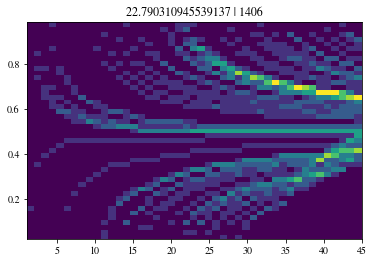

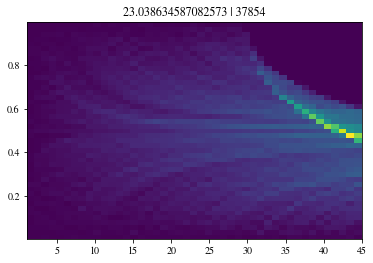

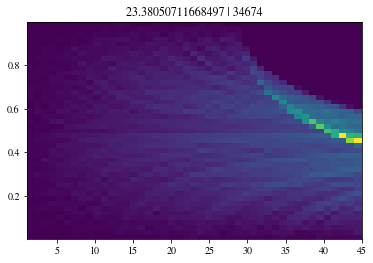

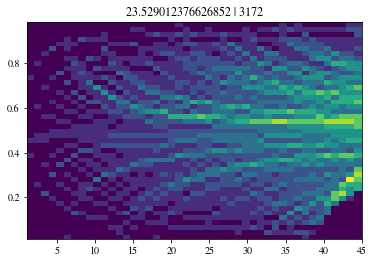

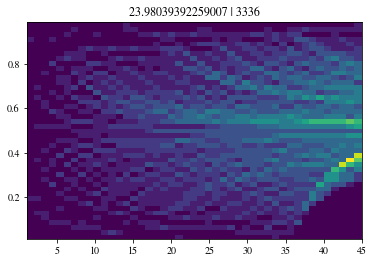

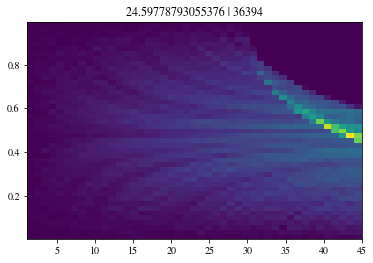

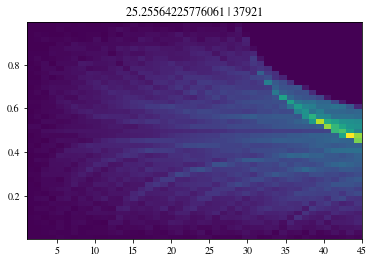

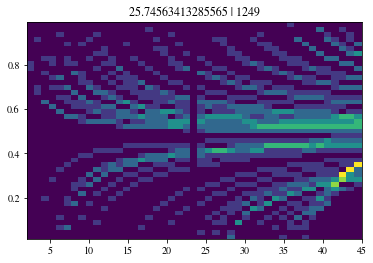

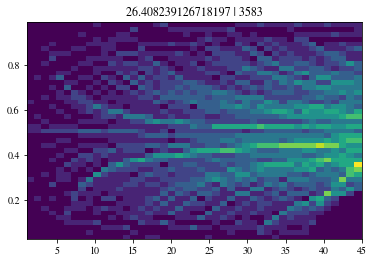

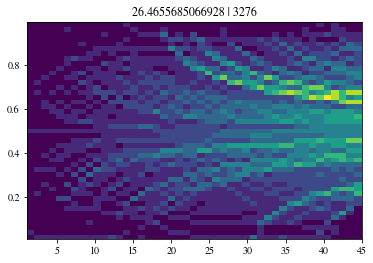

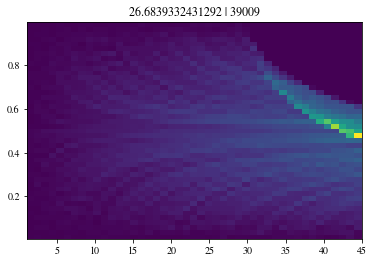

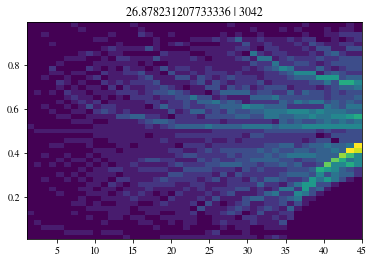

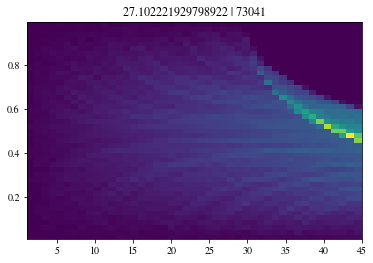

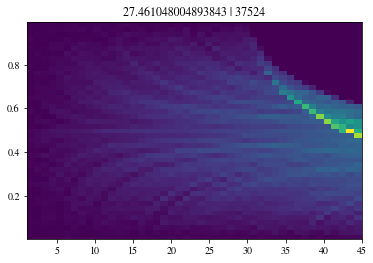

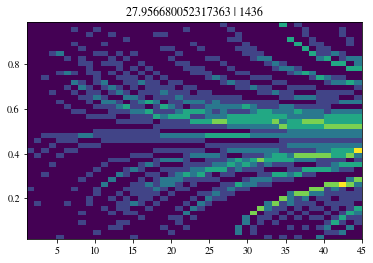

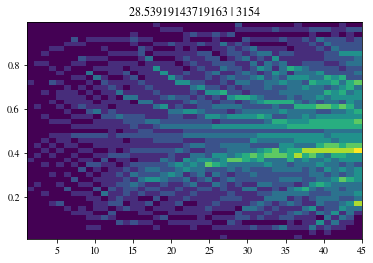

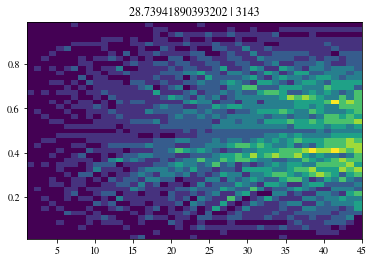

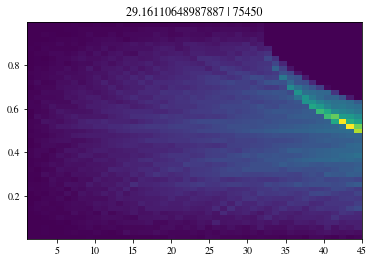

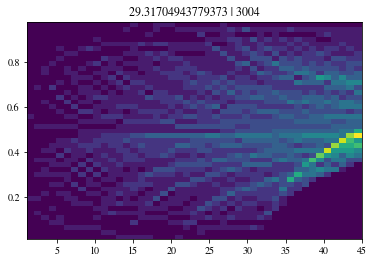

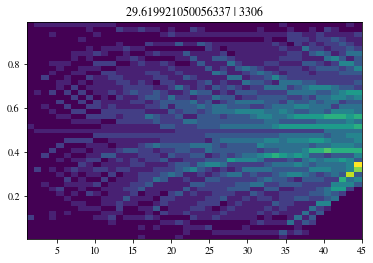

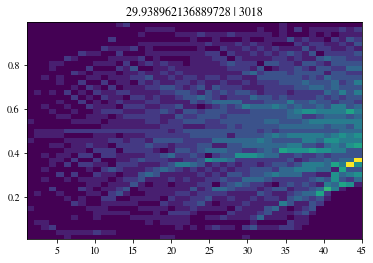

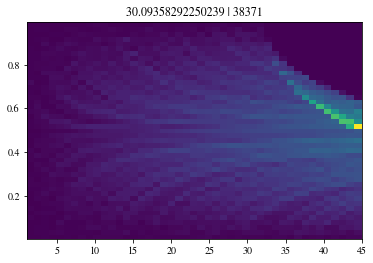

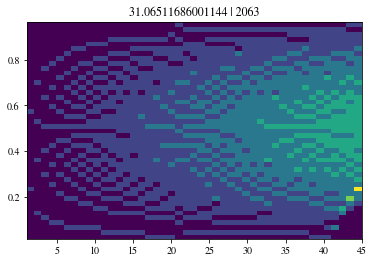

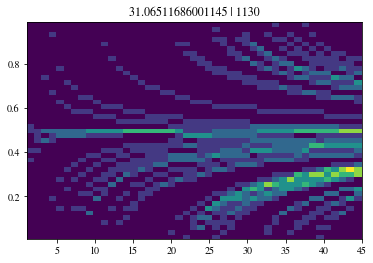

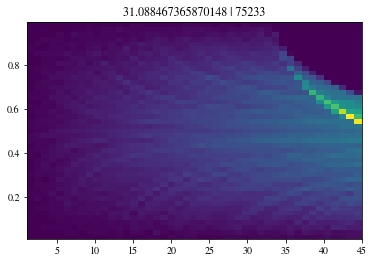

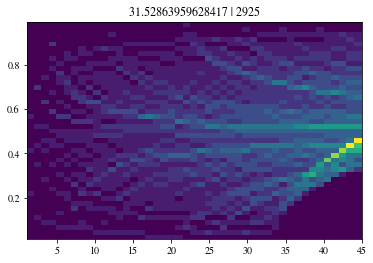

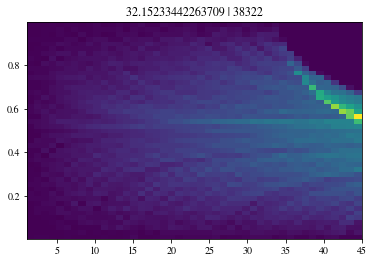

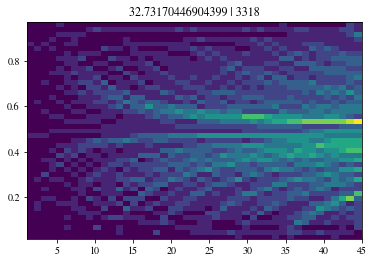

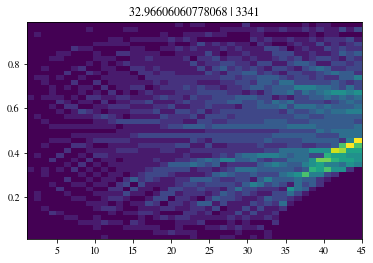

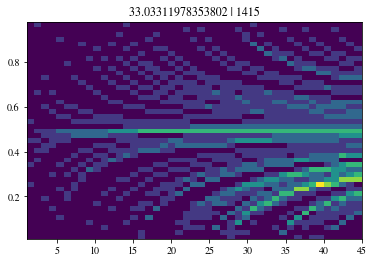

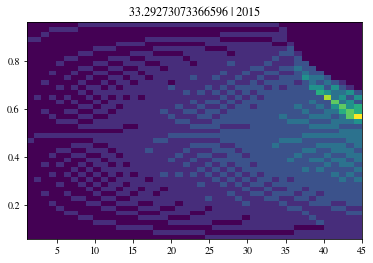

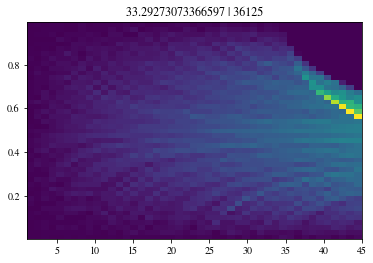

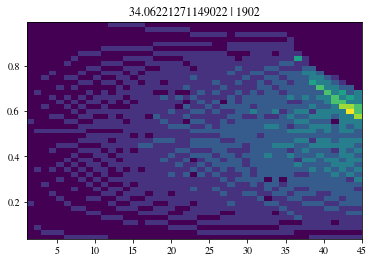

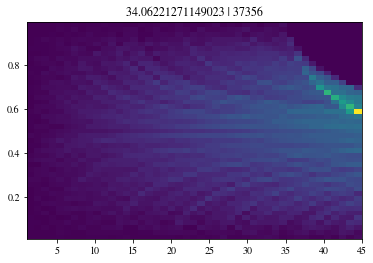

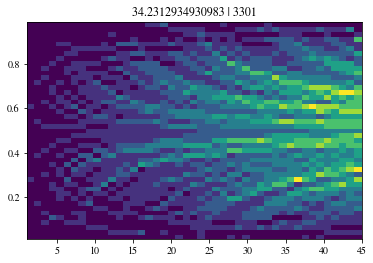

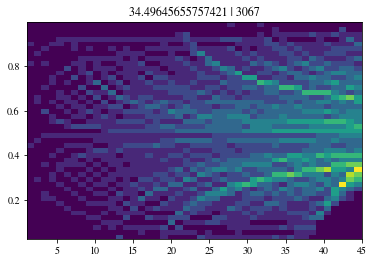

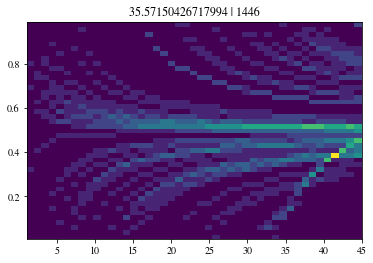

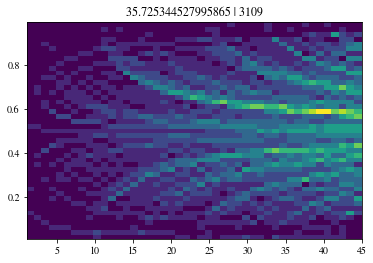

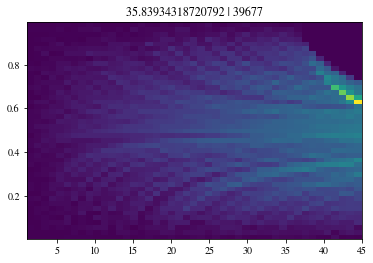

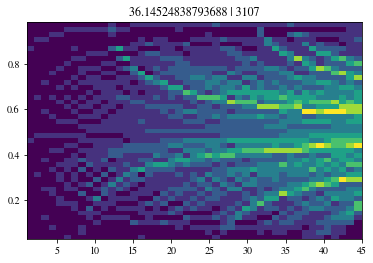

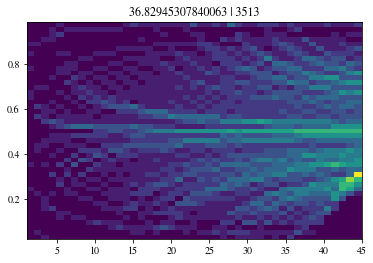

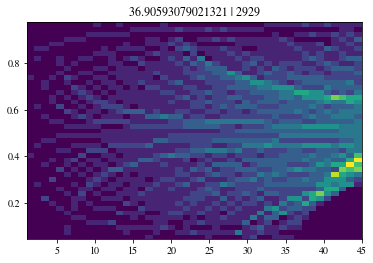

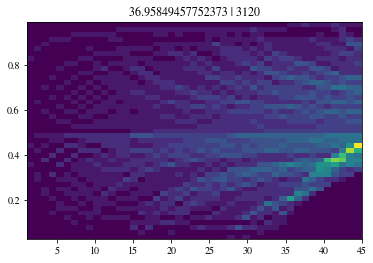

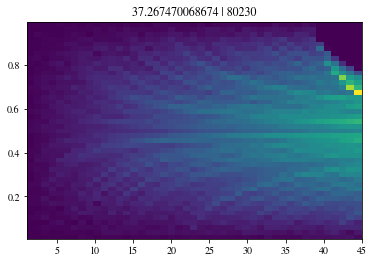

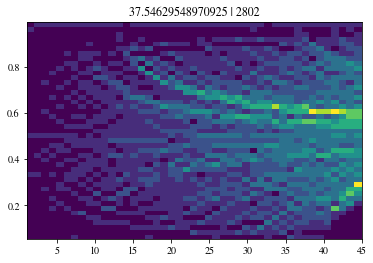

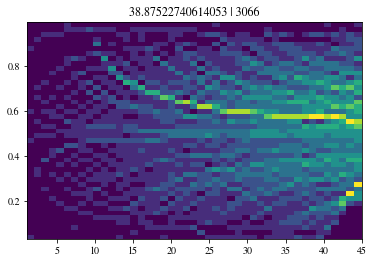

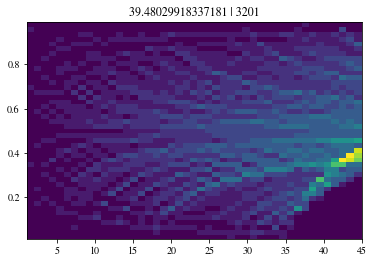

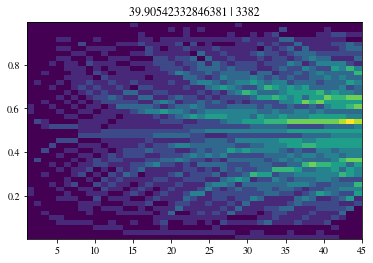

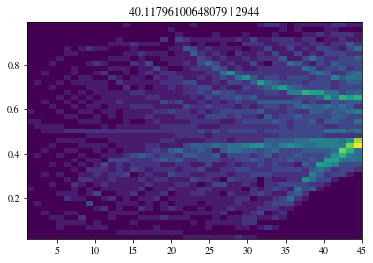

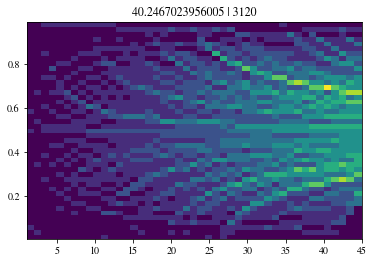

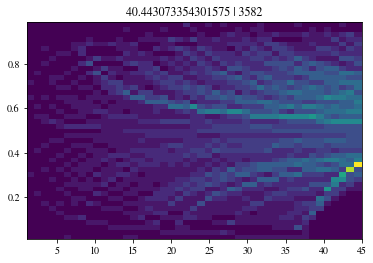

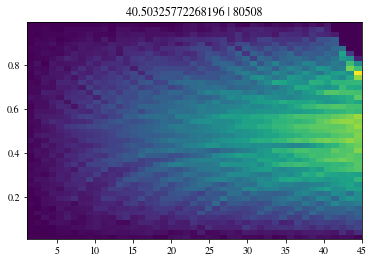

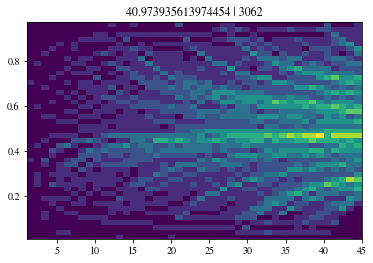

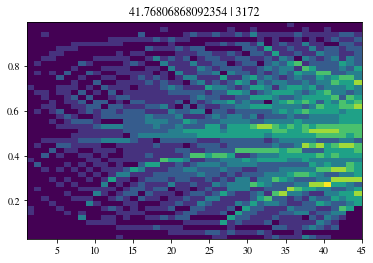

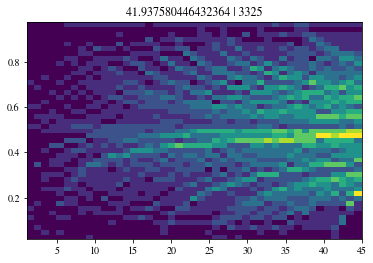

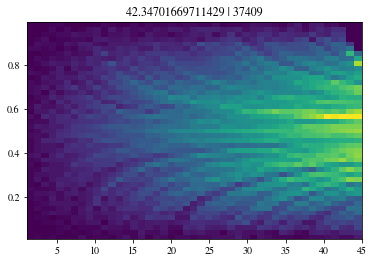

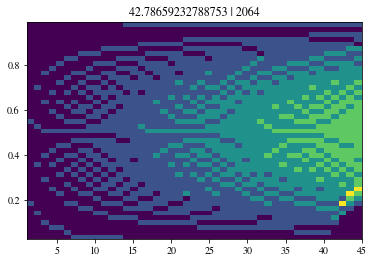

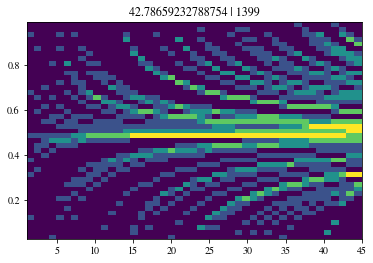

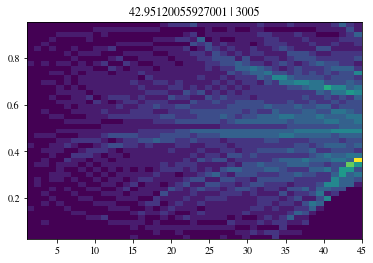

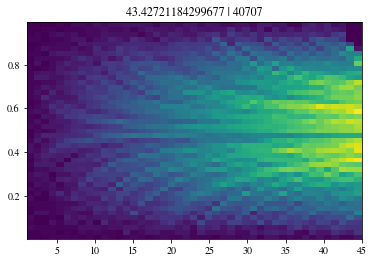

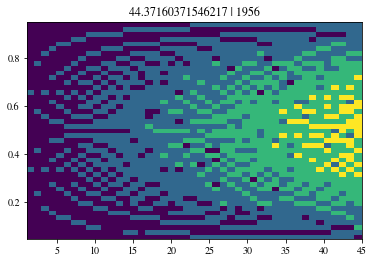

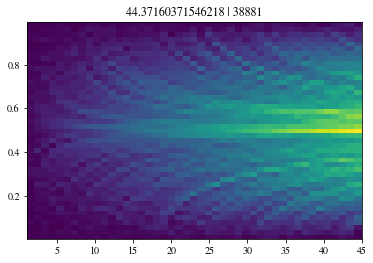

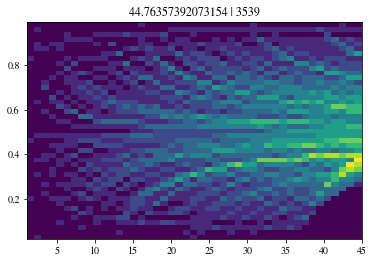

In [80]:
for i in np.sort(df_a_transient['theta'].unique()):
    sub = df_a_transient[df_a_transient['theta'] == i]
    plt.figure()
    plt.title(str(i)+' | '+str(len(sub)))
    plt.hist2d(sub['dincl'], sub['ratio'], bins=45)

/home/x1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


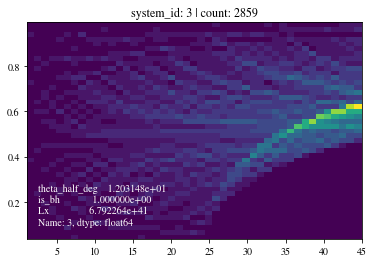

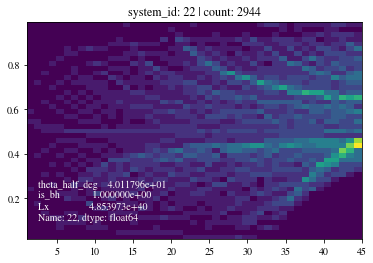

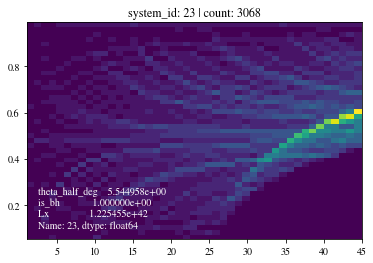

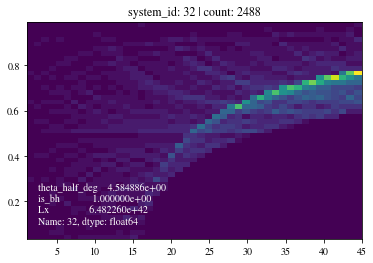

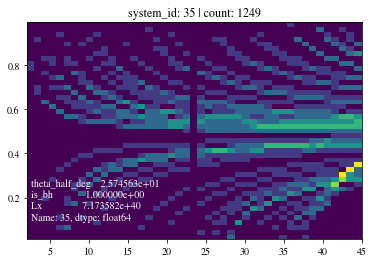

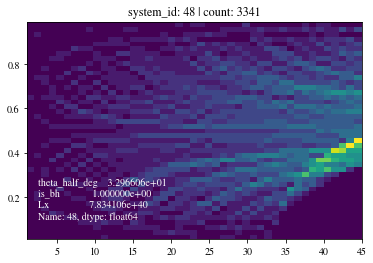

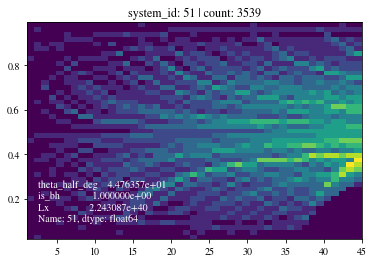

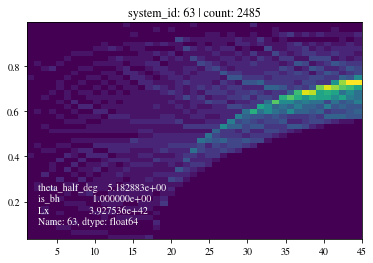

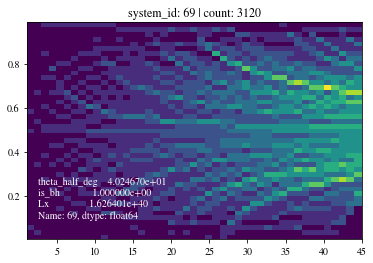

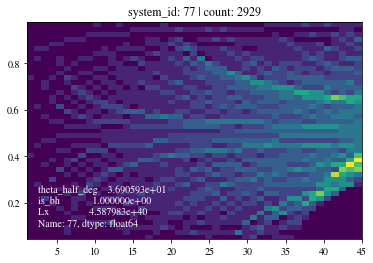

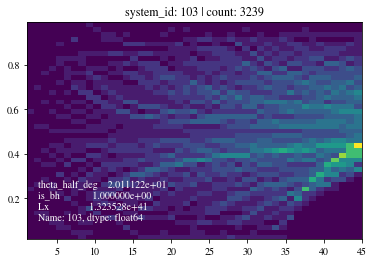

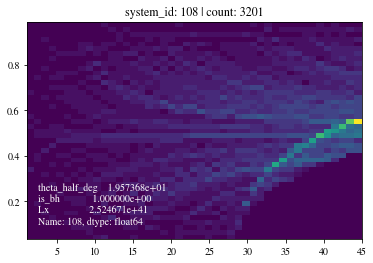

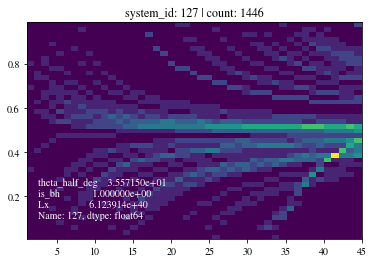

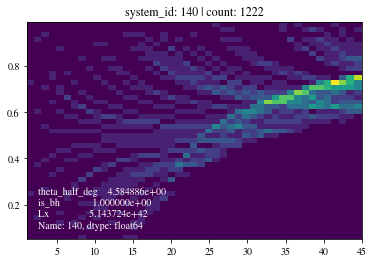

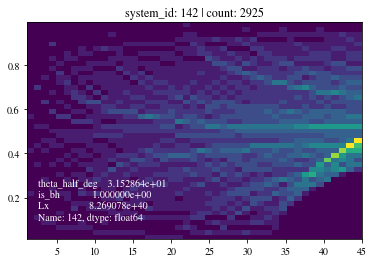

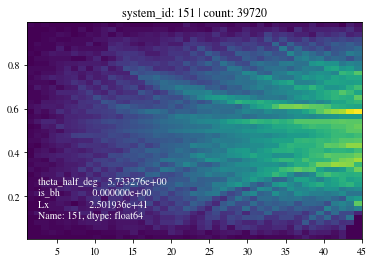

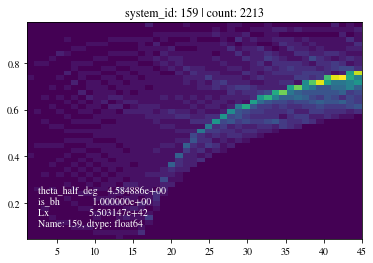

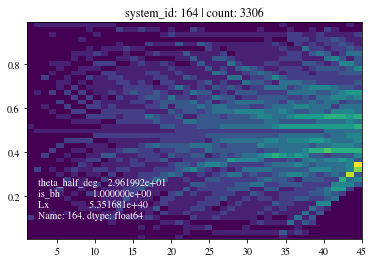

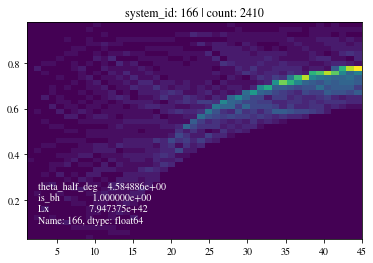

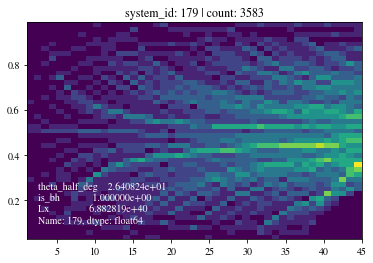

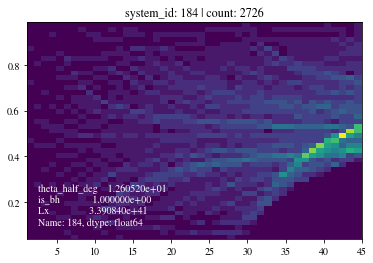

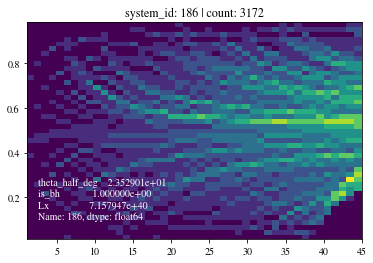

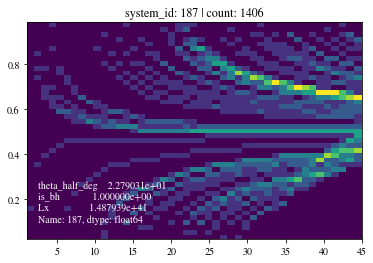

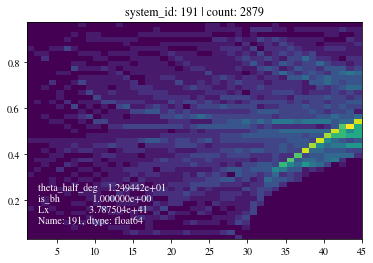

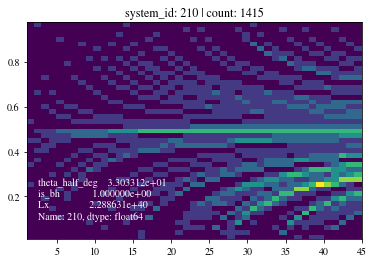

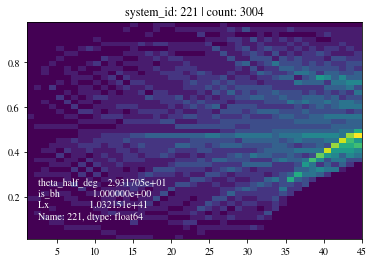

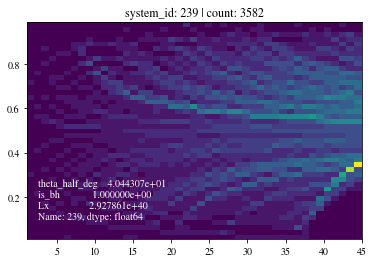

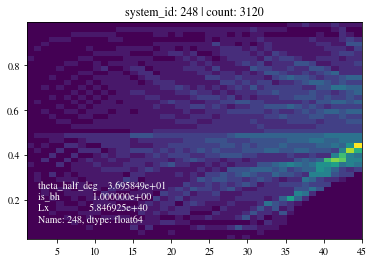

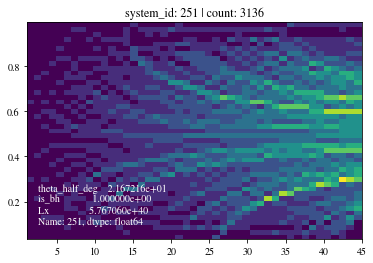

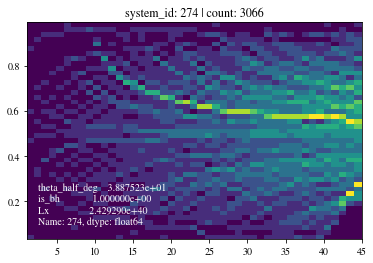

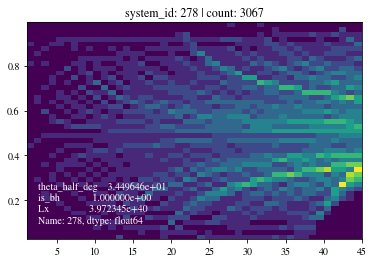

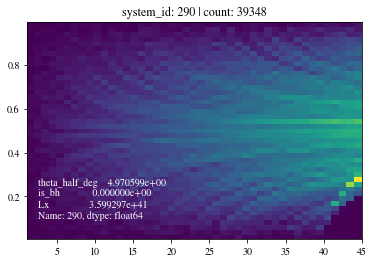

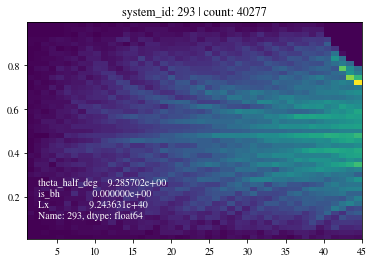

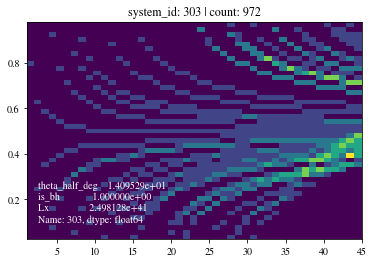

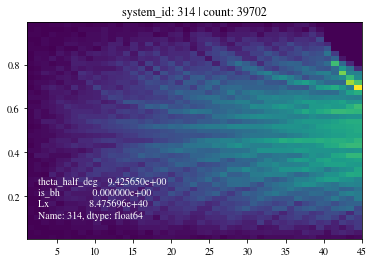

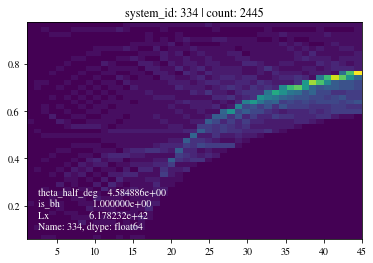

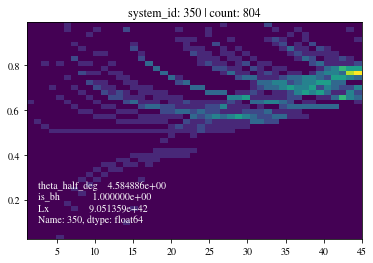

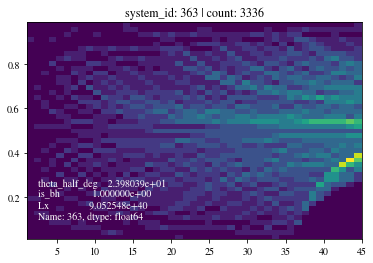

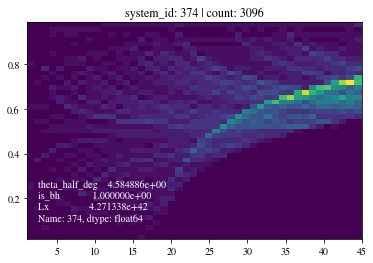

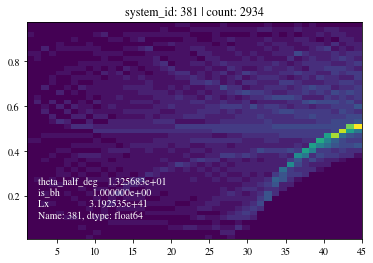

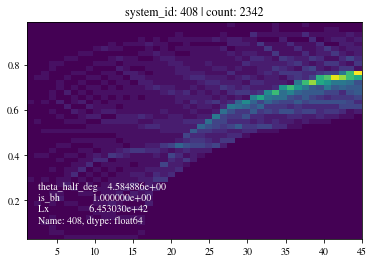

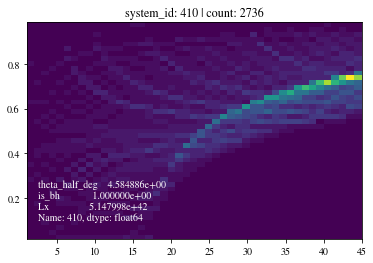

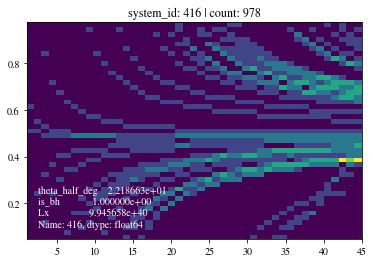

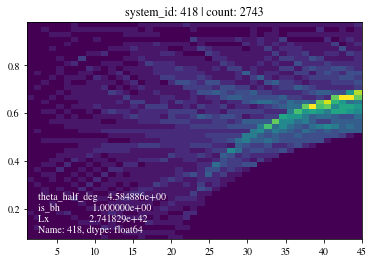

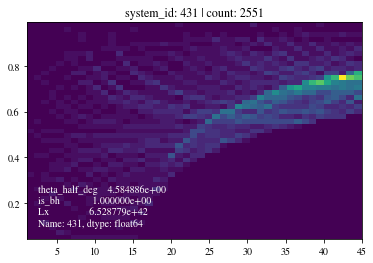

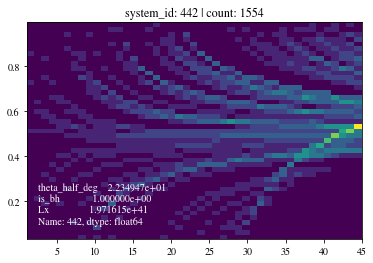

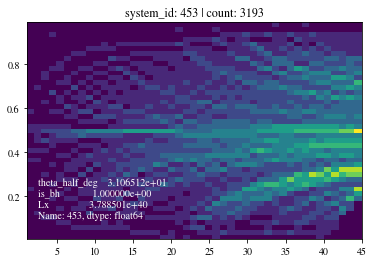

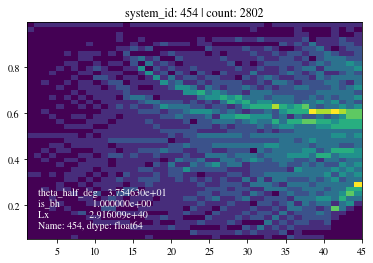

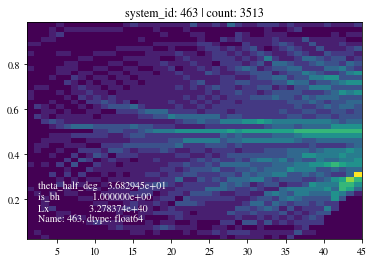

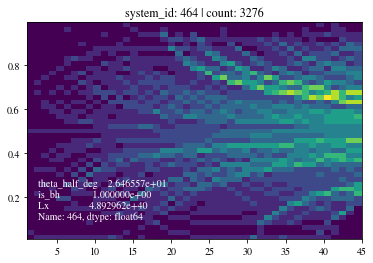

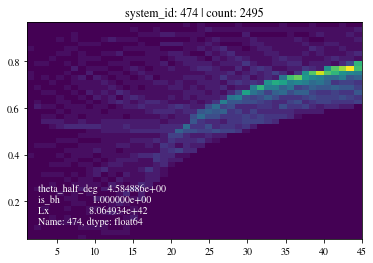

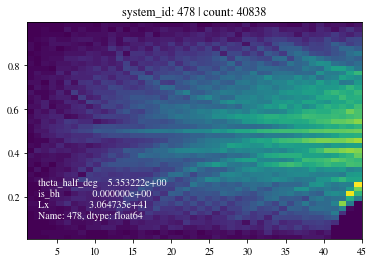

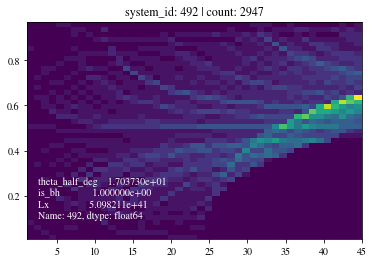

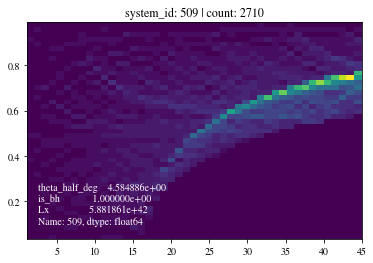

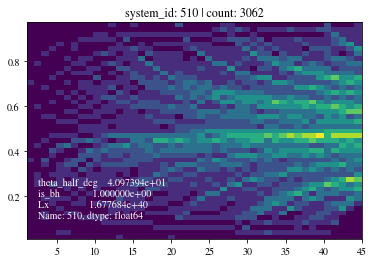

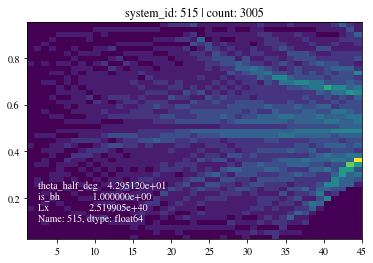

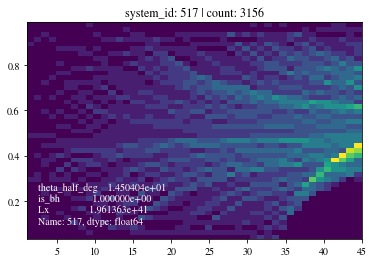

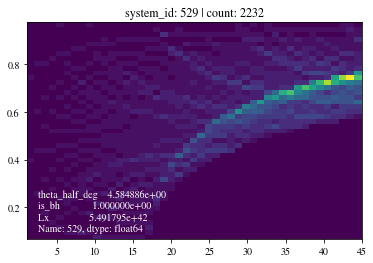

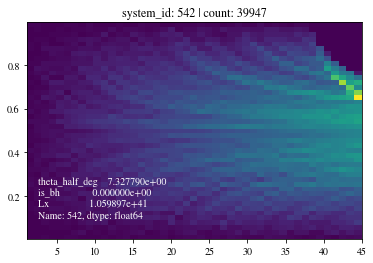

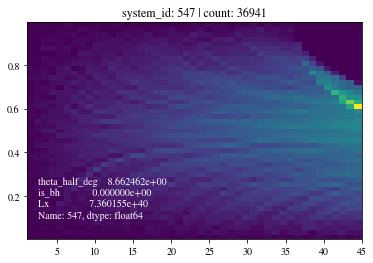

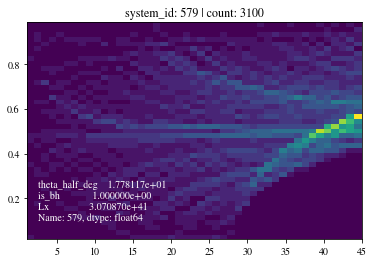

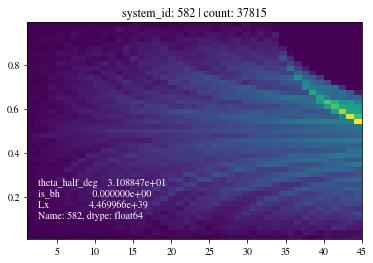

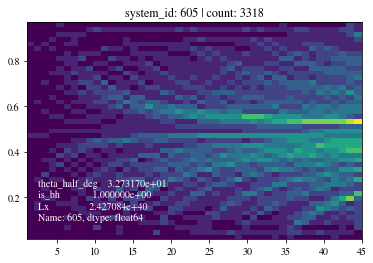

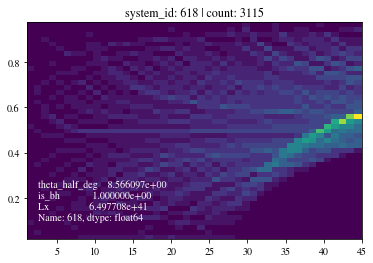

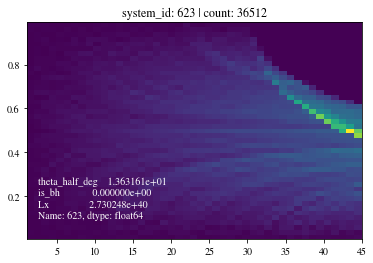

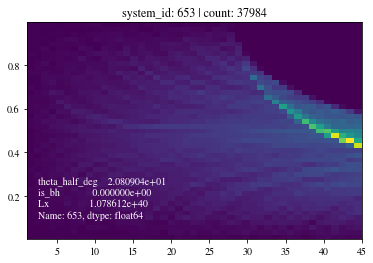

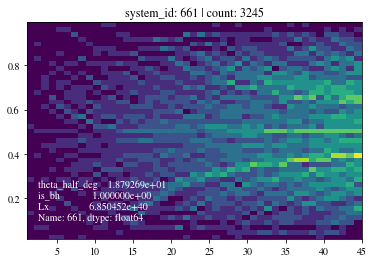

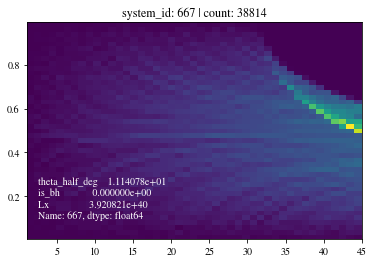

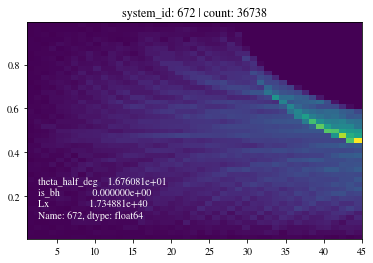

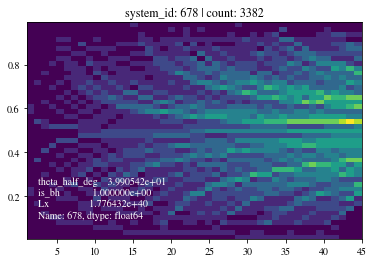

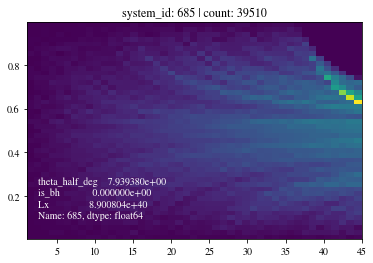

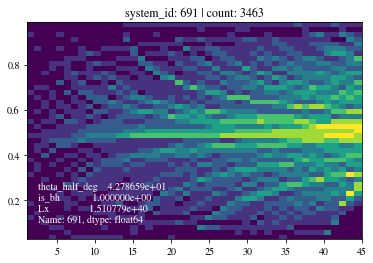

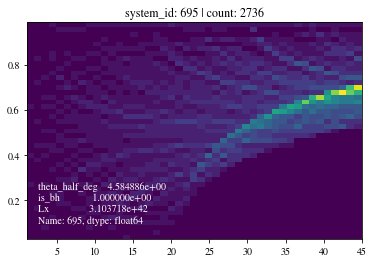

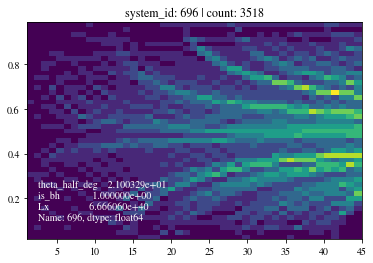

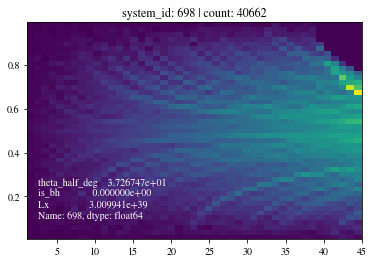

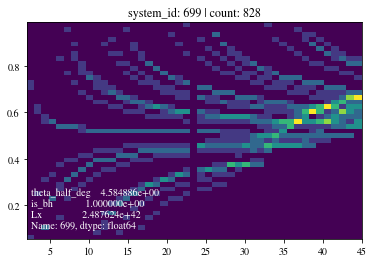

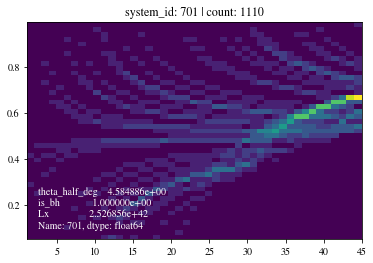

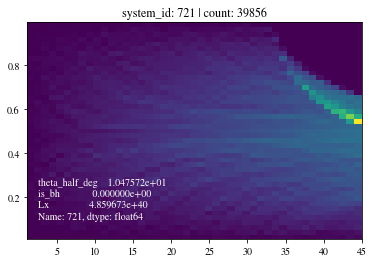

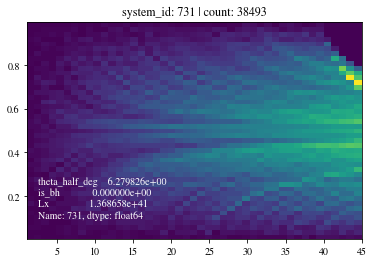

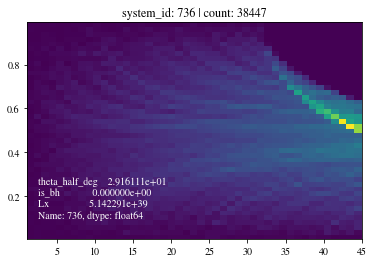

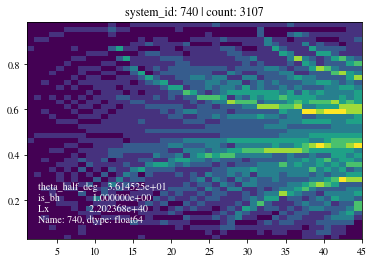

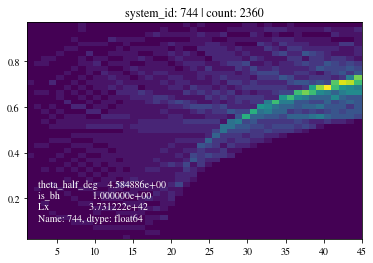

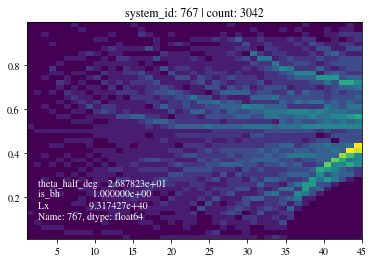

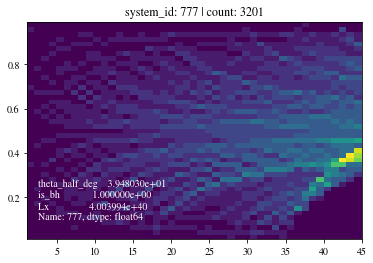

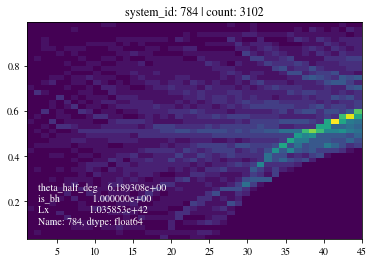

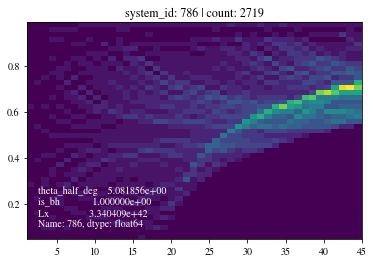

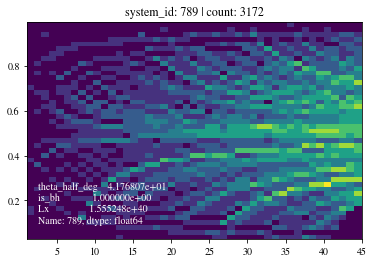

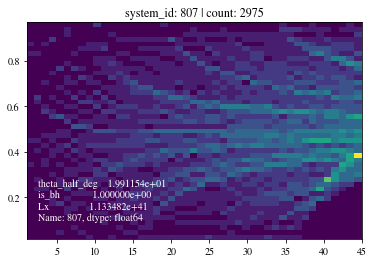

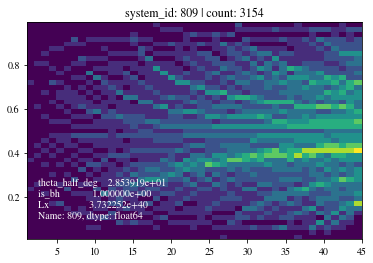

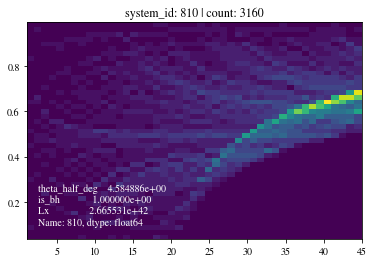

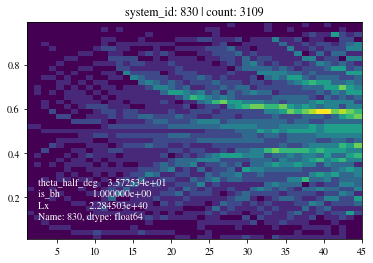

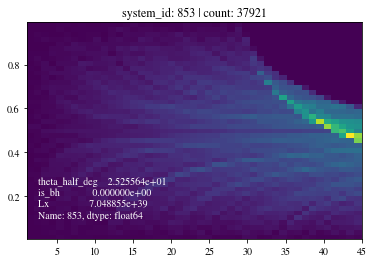

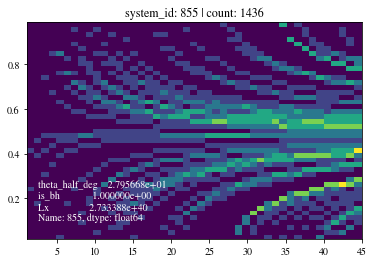

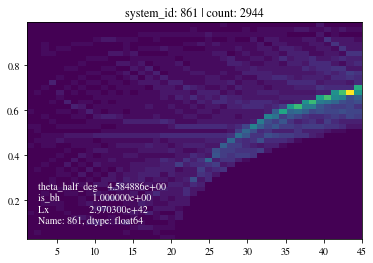

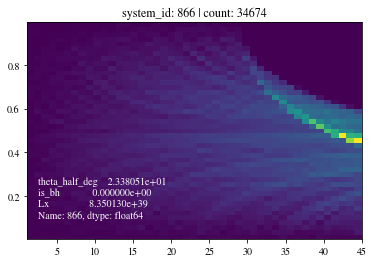

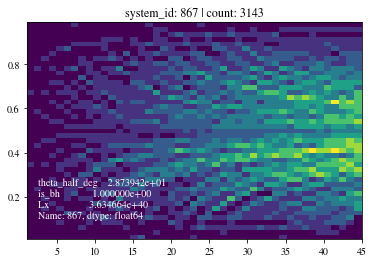

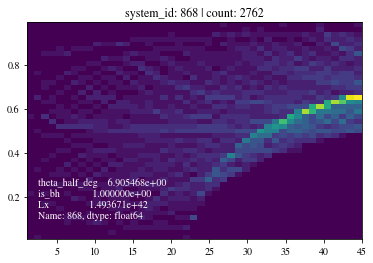

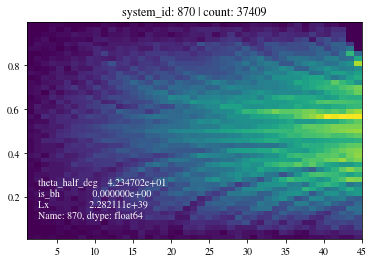

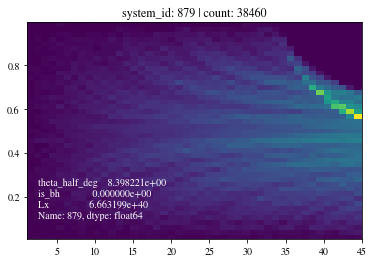

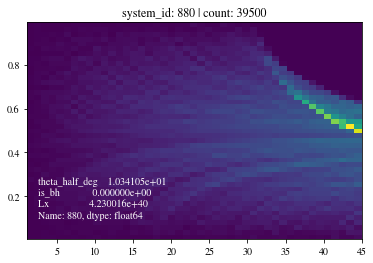

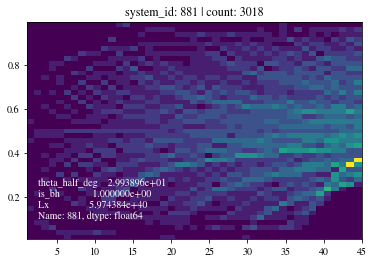

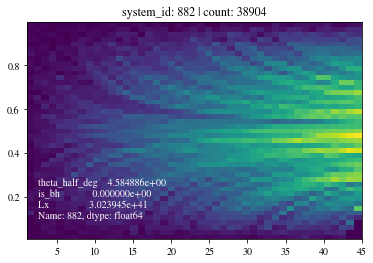

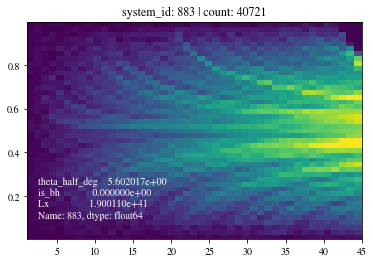

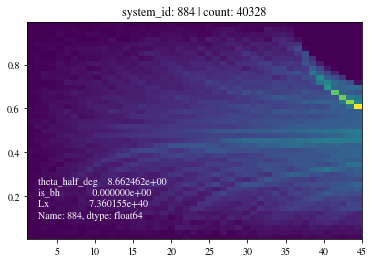

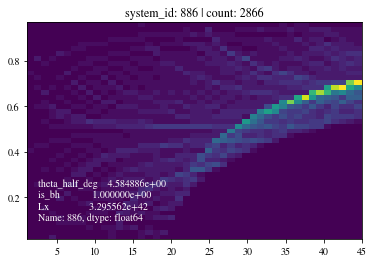

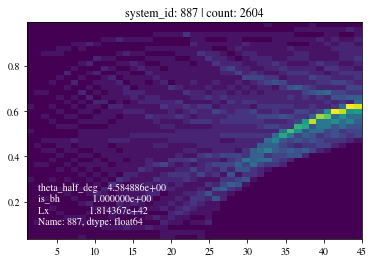

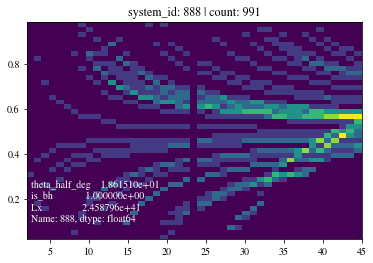

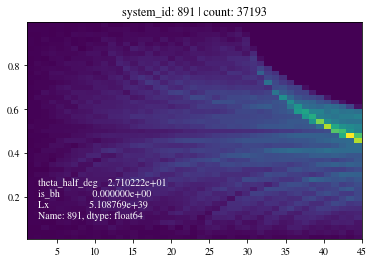

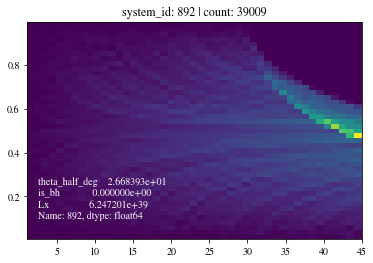

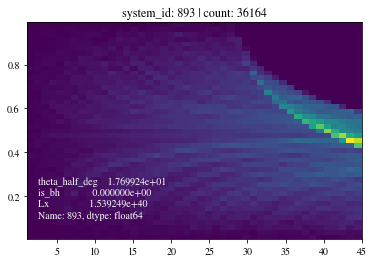

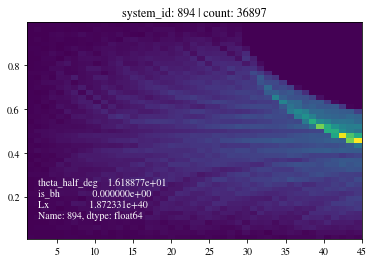

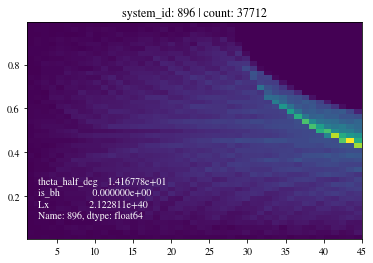

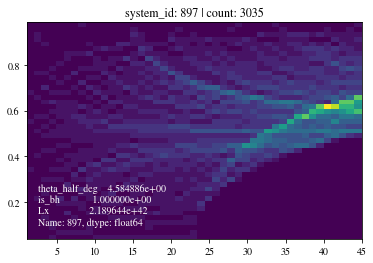

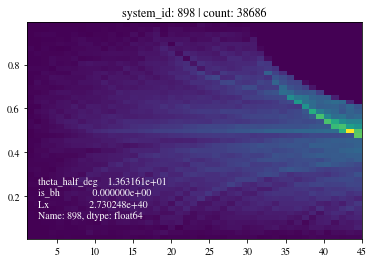

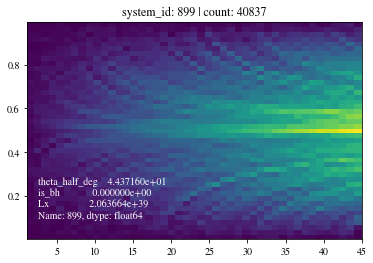

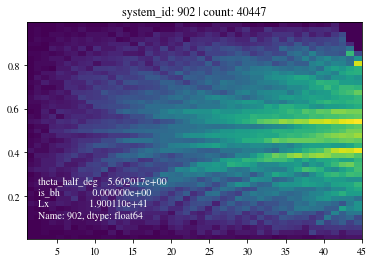

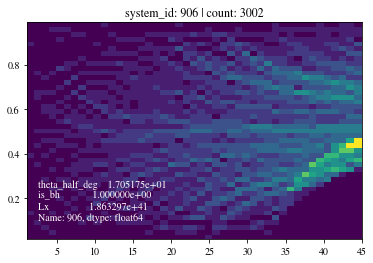

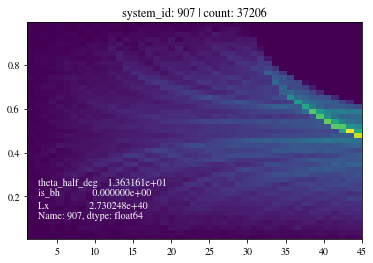

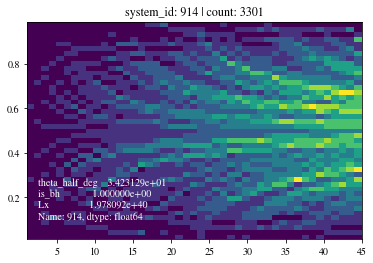

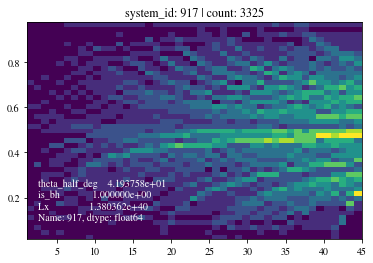

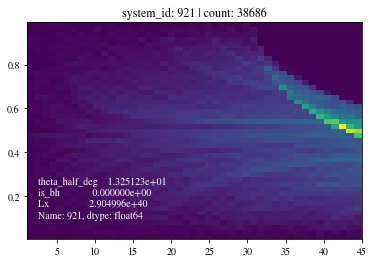

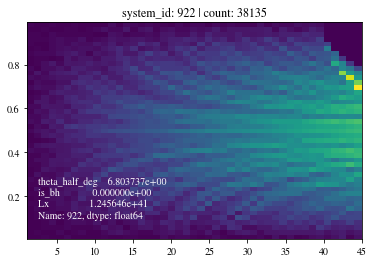

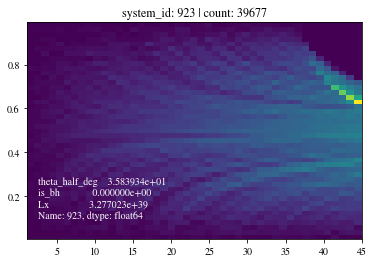

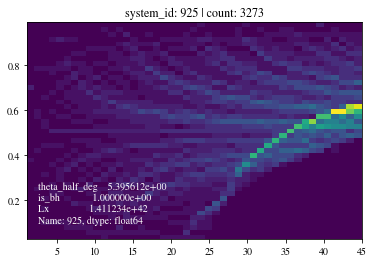

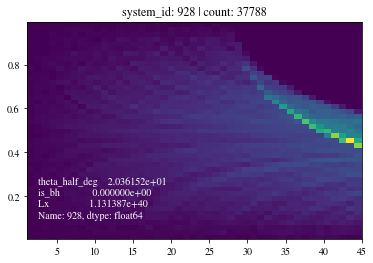

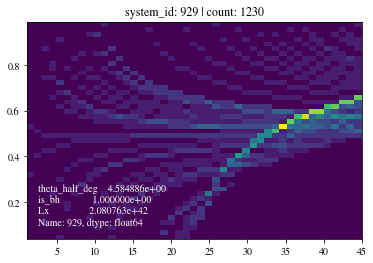

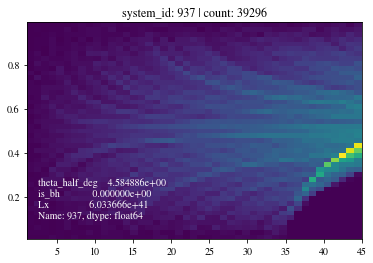

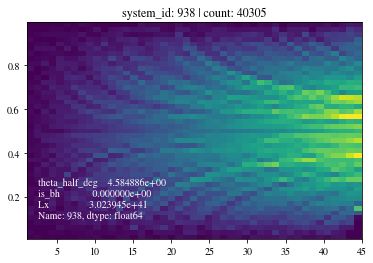

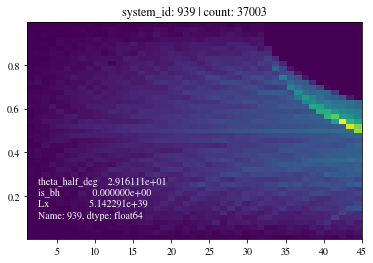

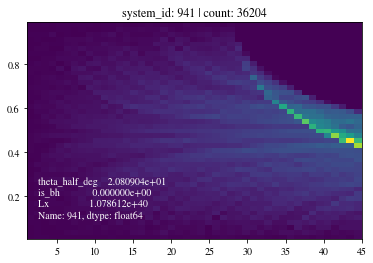

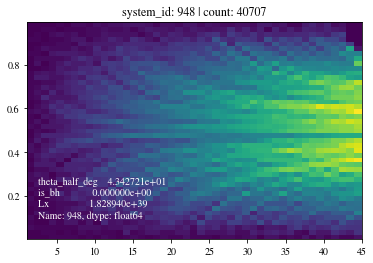

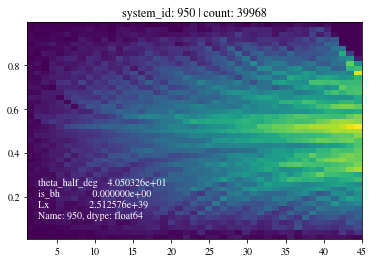

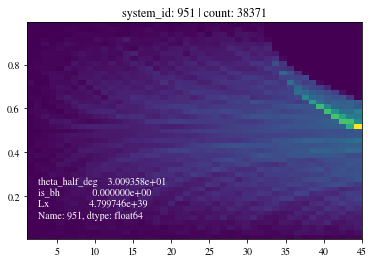

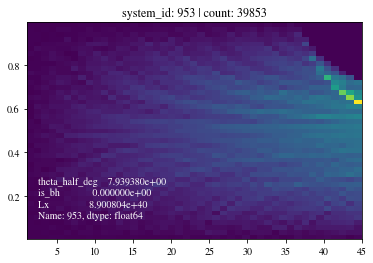

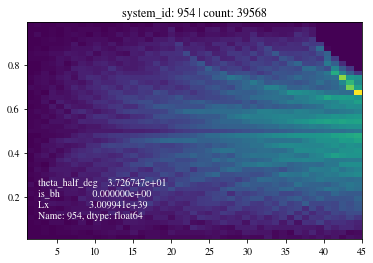

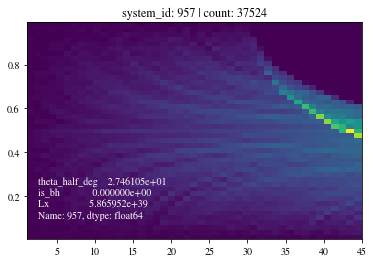

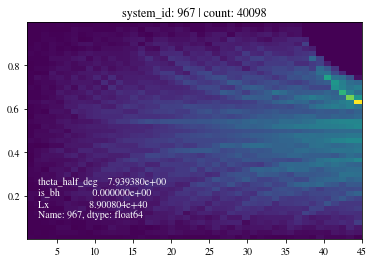

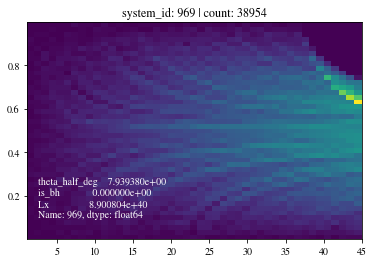

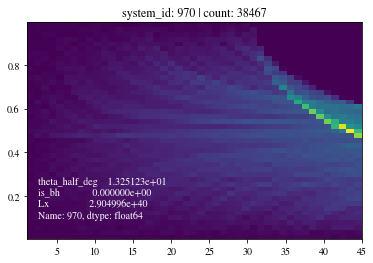

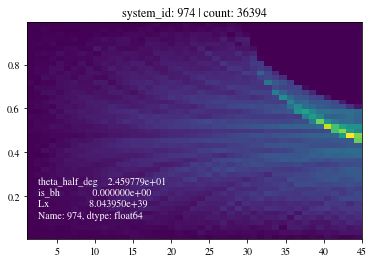

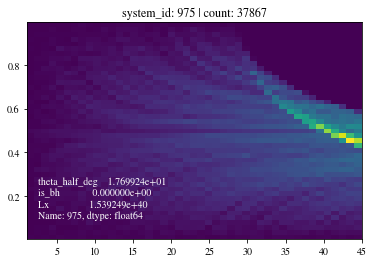

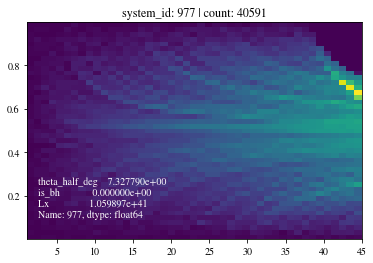

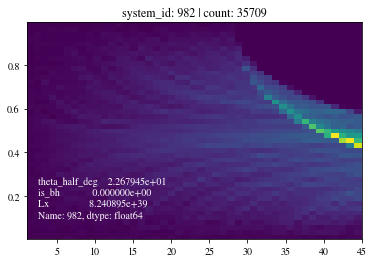

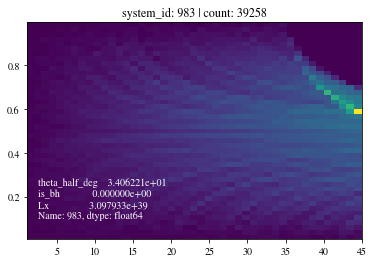

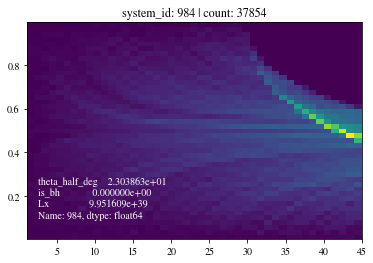

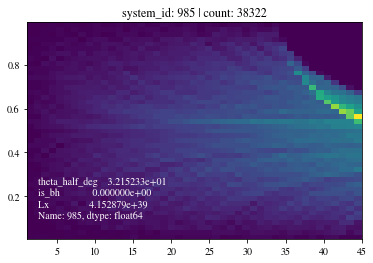

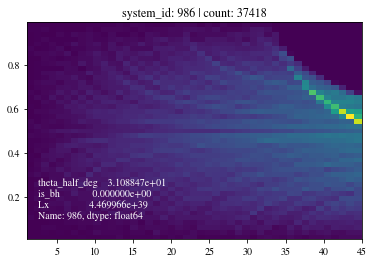

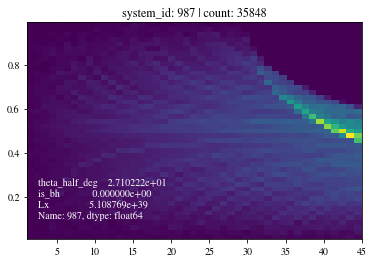

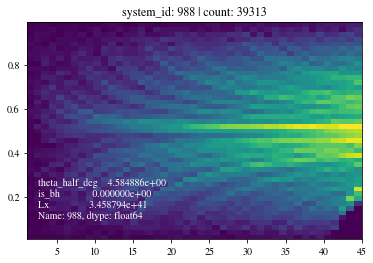

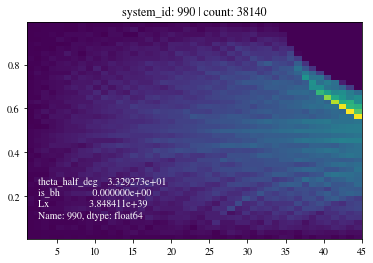

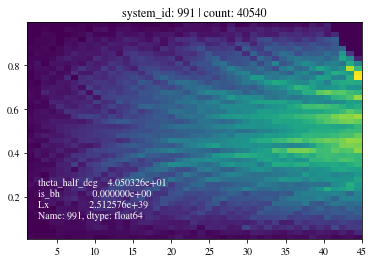

In [81]:
columns_of_interest = ['theta_half_deg', 'is_bh', 'Lx']

for i in np.sort(df_a_transient['system_id'].unique()):
    sub = df_a_transient[df_a_transient['system_id'] == i]
    plt.figure()
    plt.text(x=2.5, y= 0.1, s=str(systems_df.iloc[i][columns_of_interest]), color='white')
    plt.title('system_id: ' + str(i)+' | count: '+str(len(sub)))
    plt.hist2d(sub['dincl'], sub['ratio'], bins=45)

Text(0, 0.5, 'ratio')

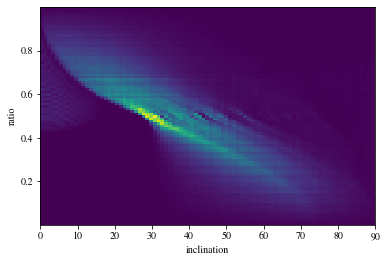

In [82]:
plt.hist2d(df_a_transient['inclination'], df_a_transient['ratio'], bins=89)
plt.xlabel('inclination')
plt.ylabel('ratio')

Text(0, 0.5, 'dincl')

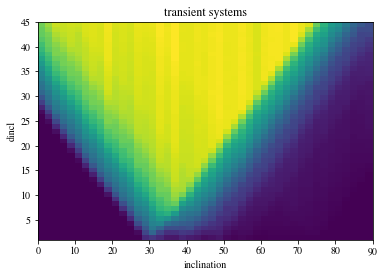

In [83]:
plt.figure()
plt.hist2d(df_a_transient['inclination'], df_a_transient['dincl'], bins=45)
plt.title('transient systems')
plt.xlabel('inclination')
plt.ylabel('dincl')

/home/x1/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


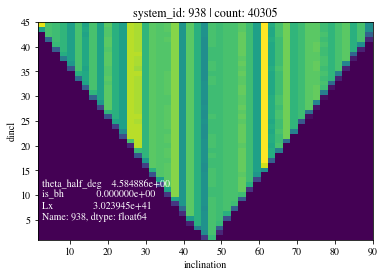

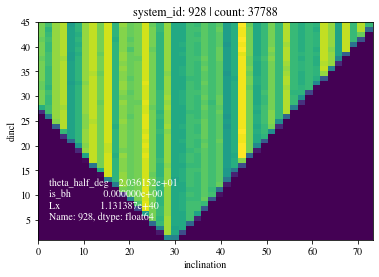

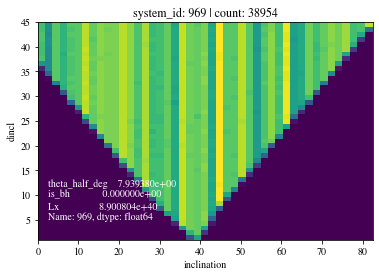

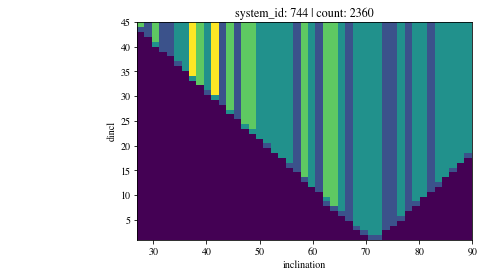

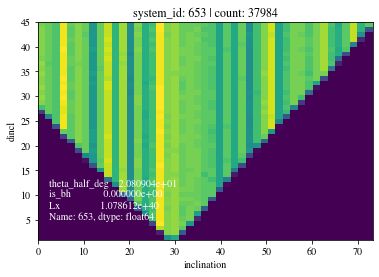

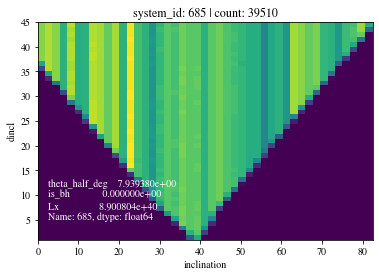

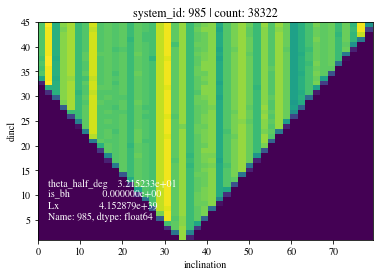

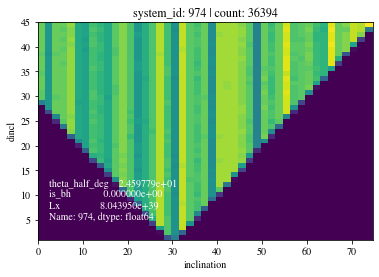

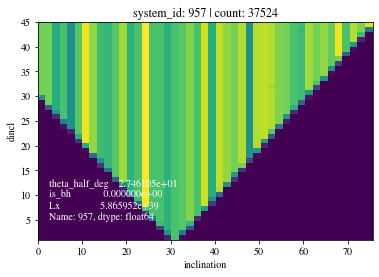

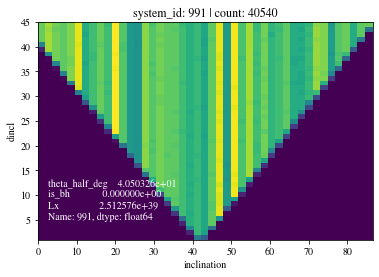

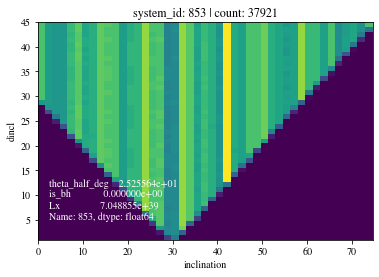

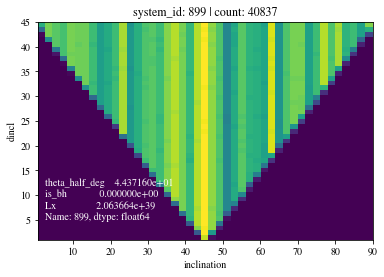

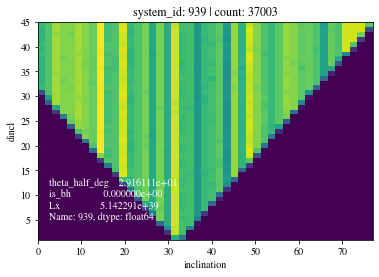

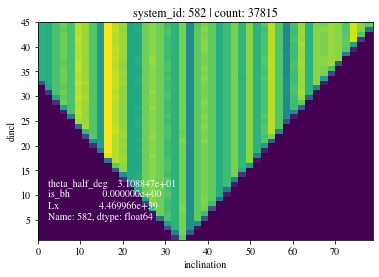

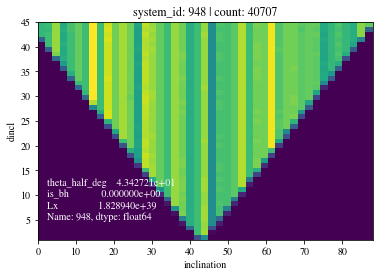

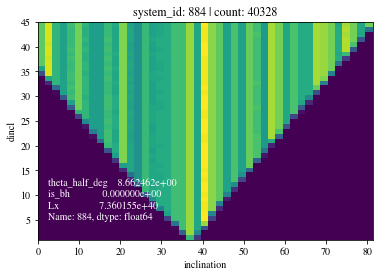

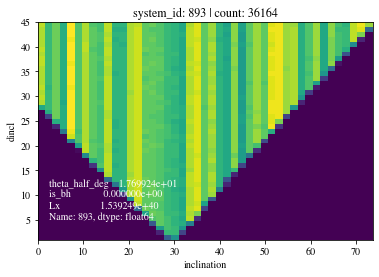

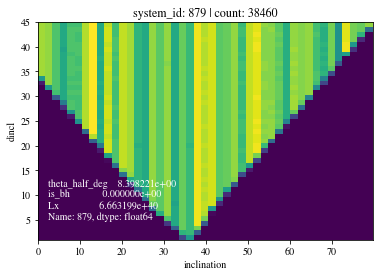

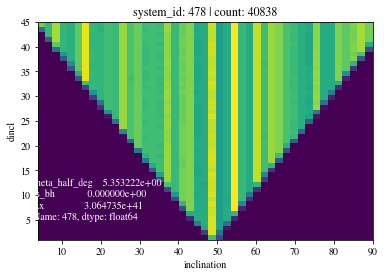

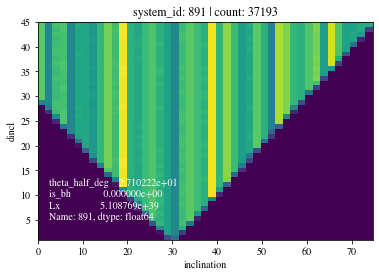

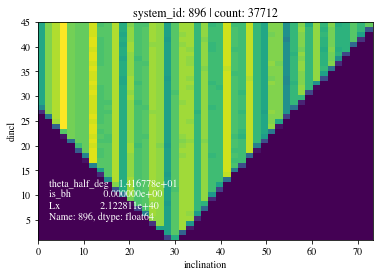

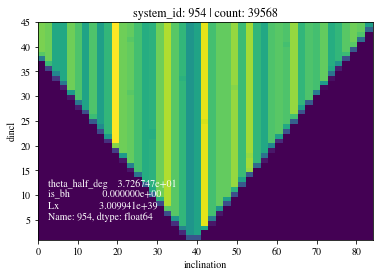

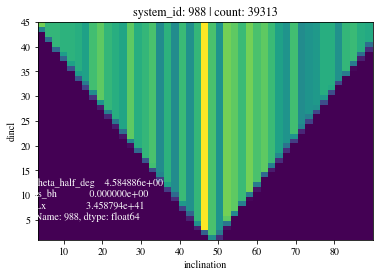

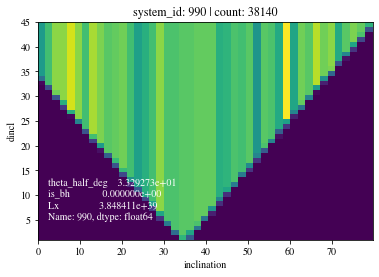

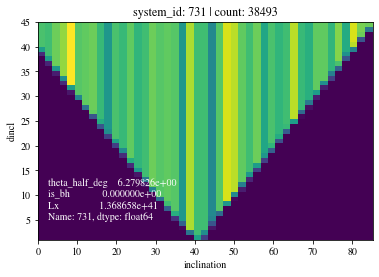

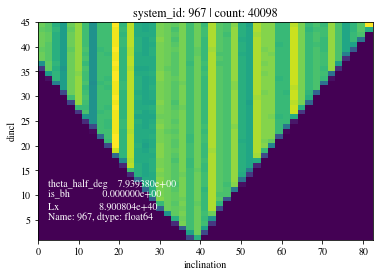

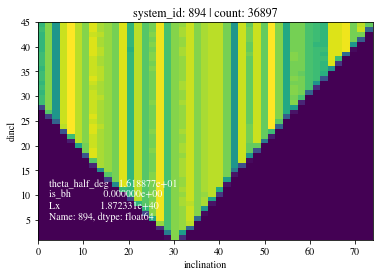

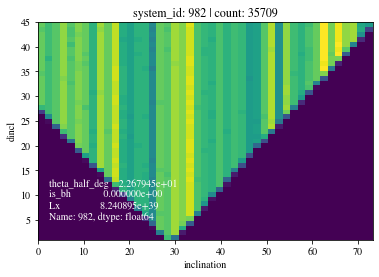

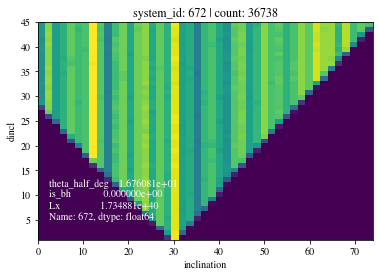

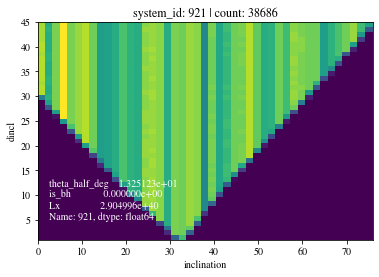

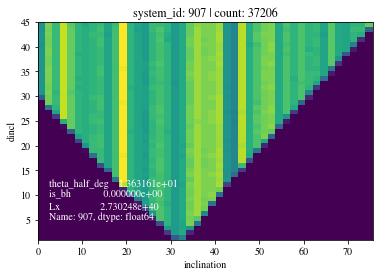

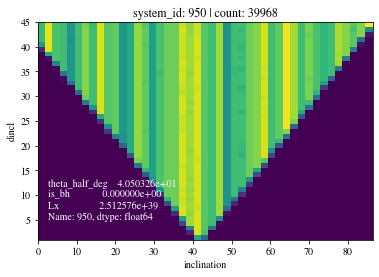

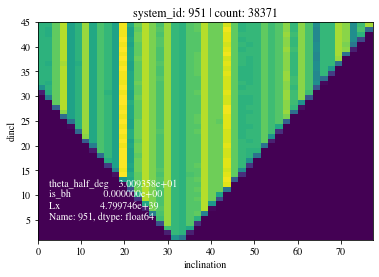

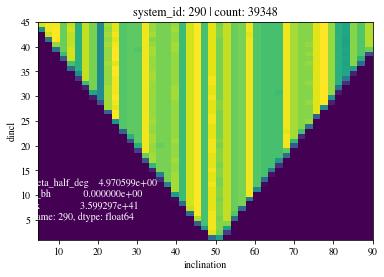

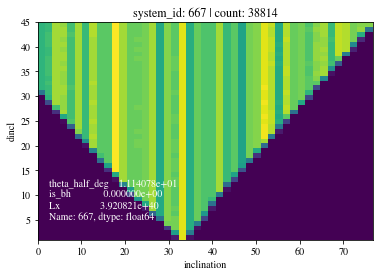

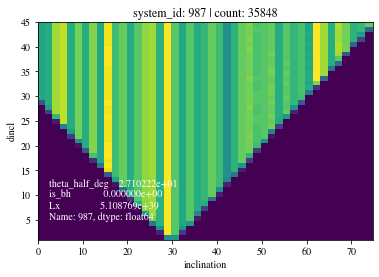

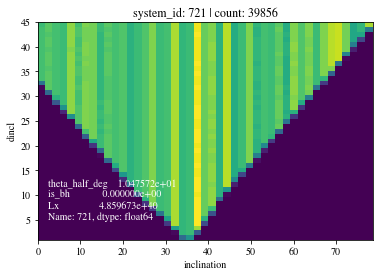

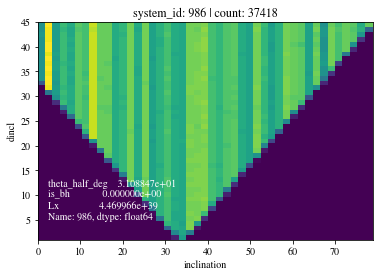

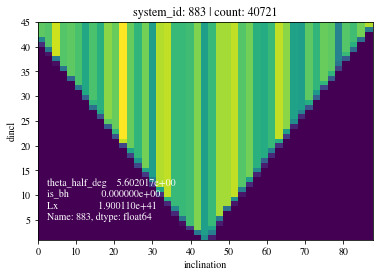

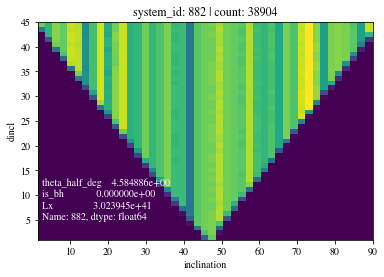

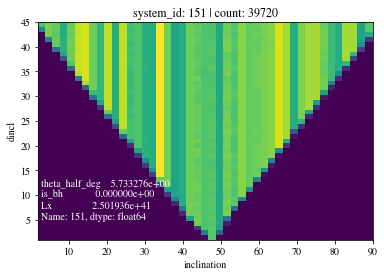

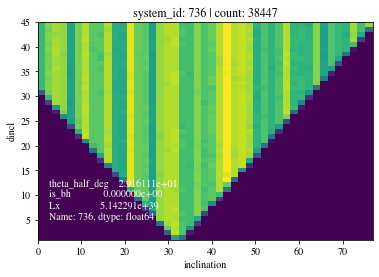

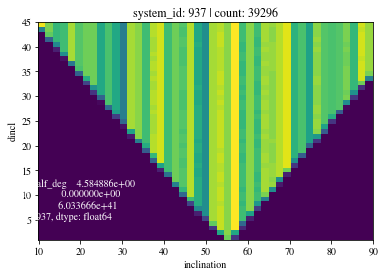

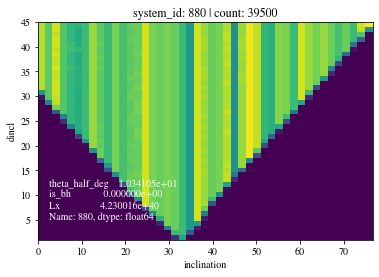

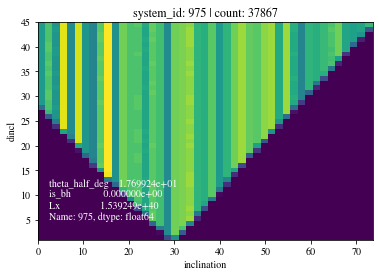

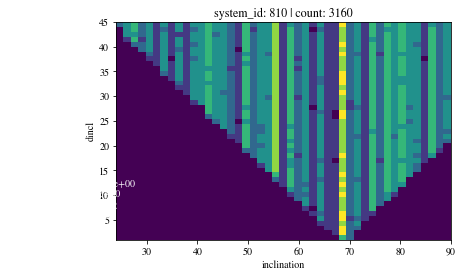

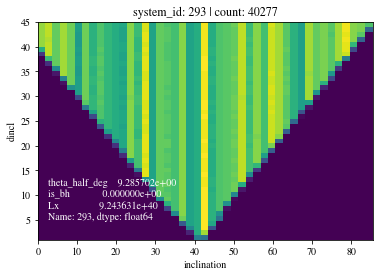

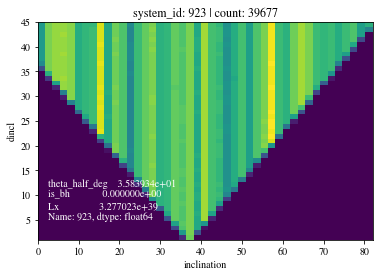

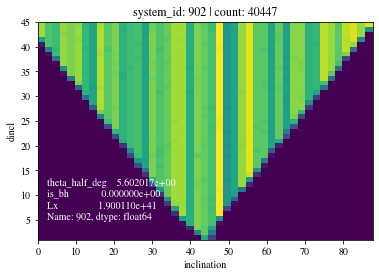

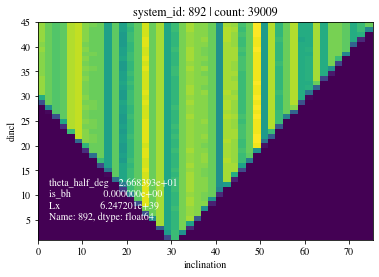

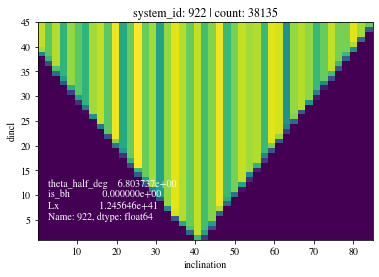

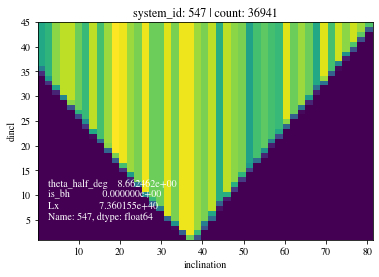

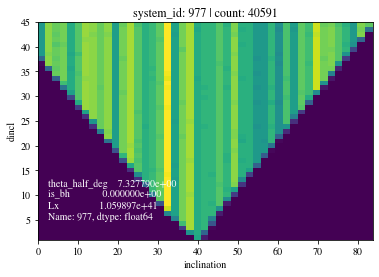

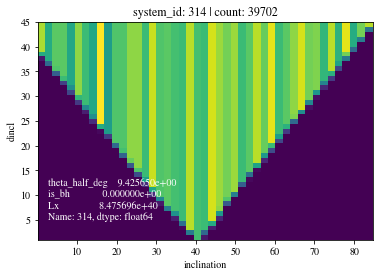

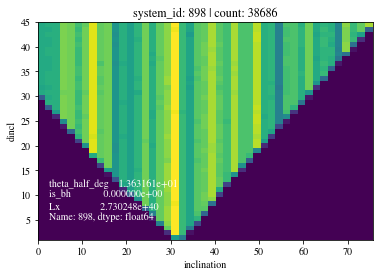

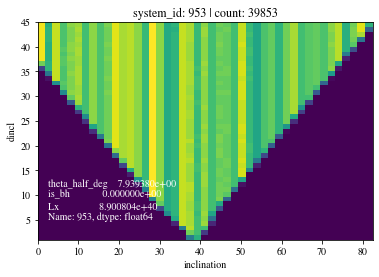

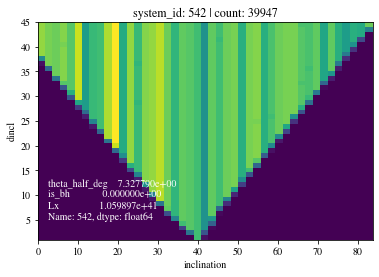

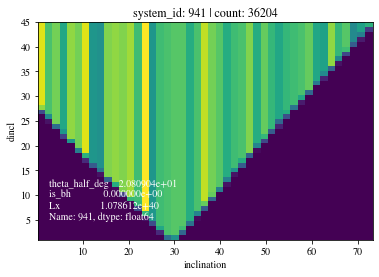

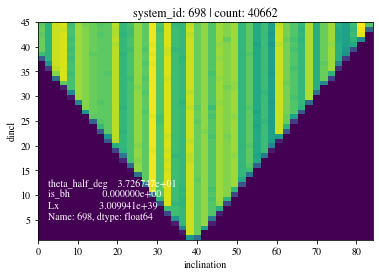

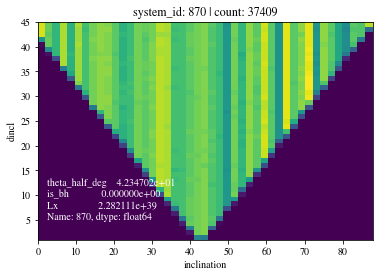

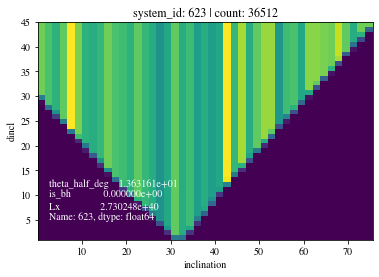

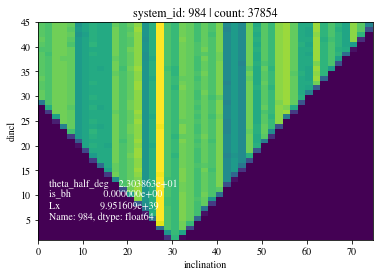

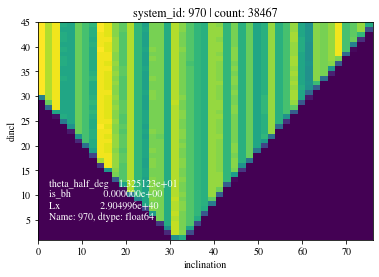

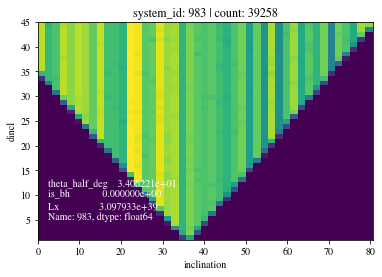

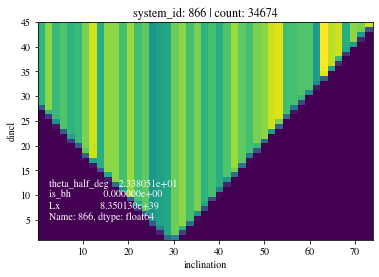

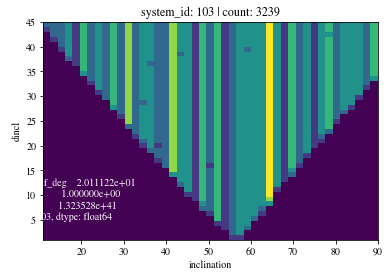

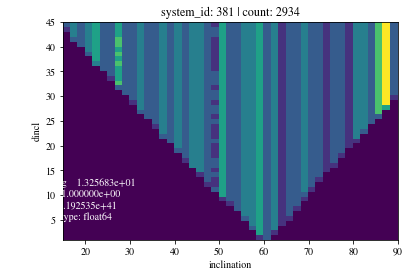

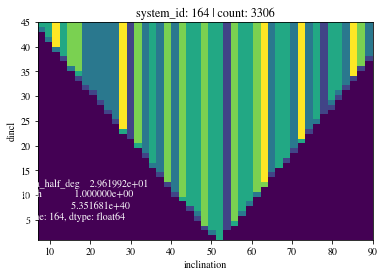

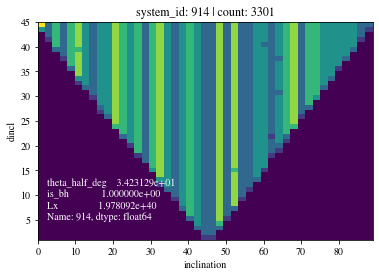

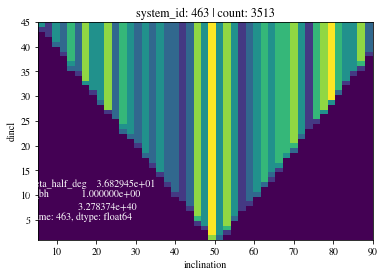

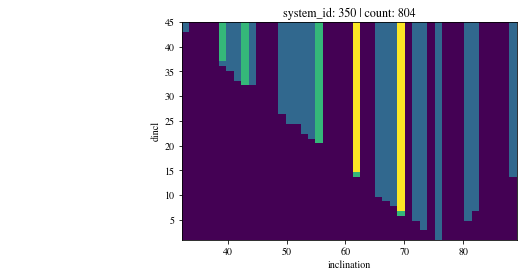

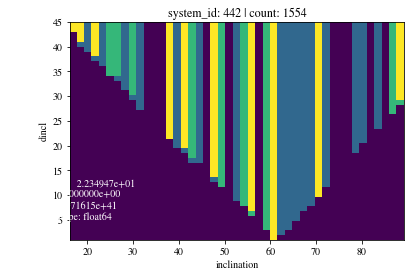

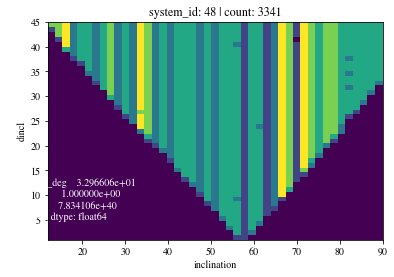

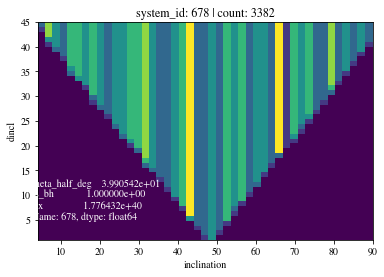

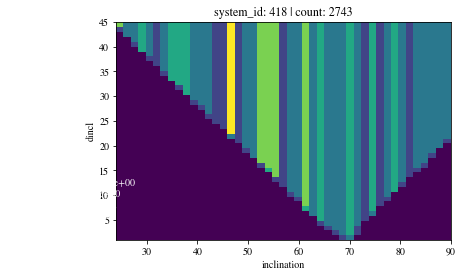

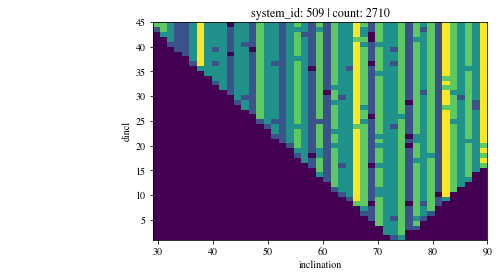

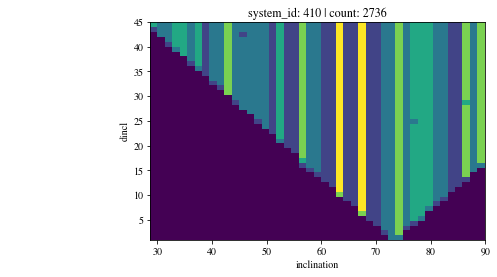

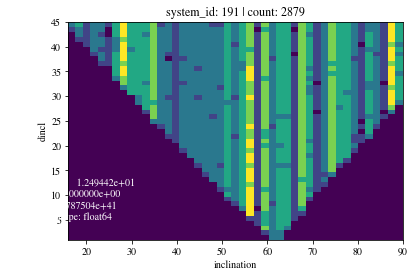

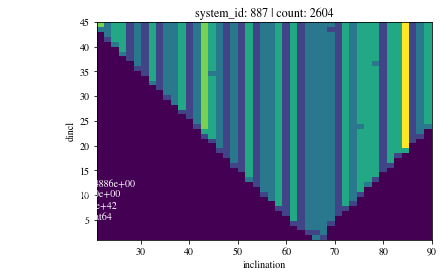

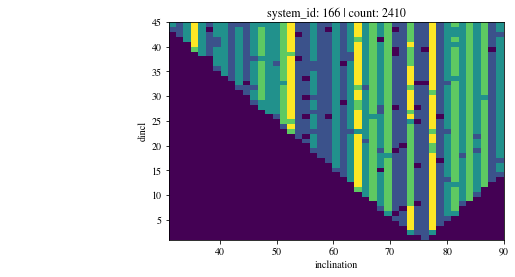

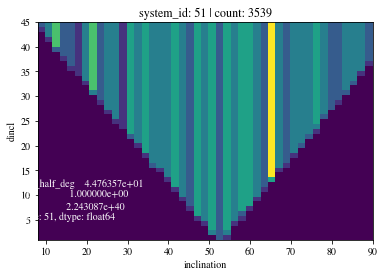

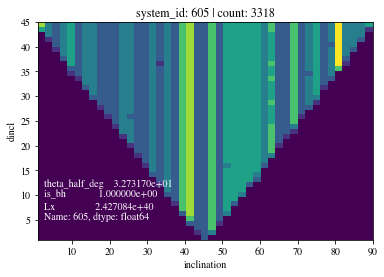

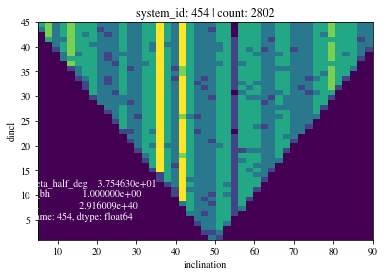

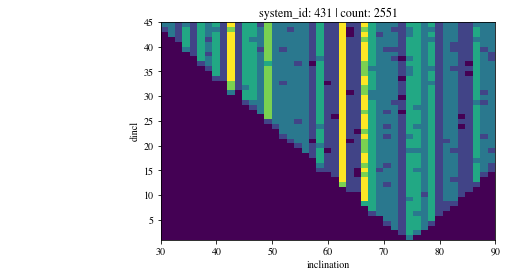

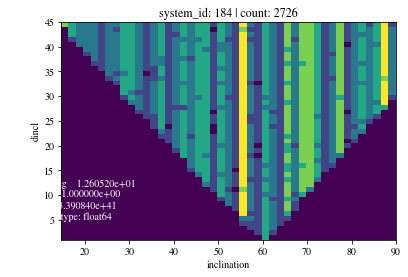

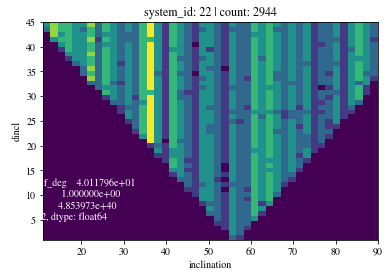

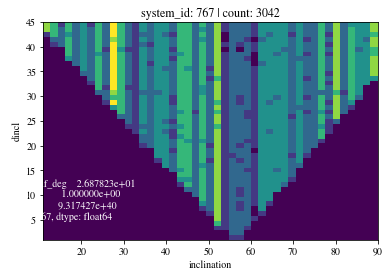

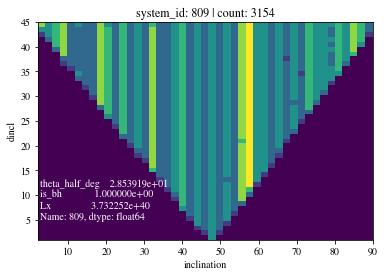

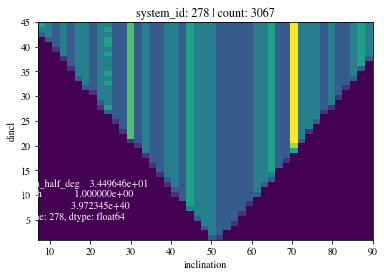

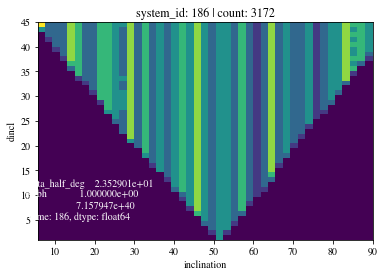

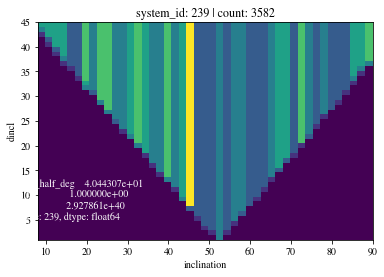

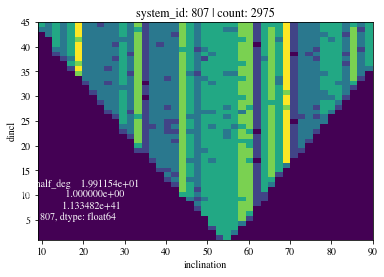

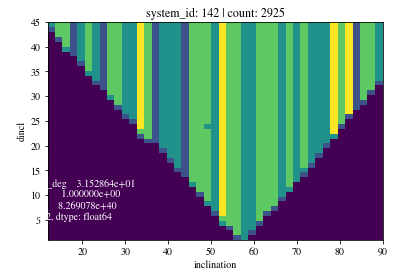

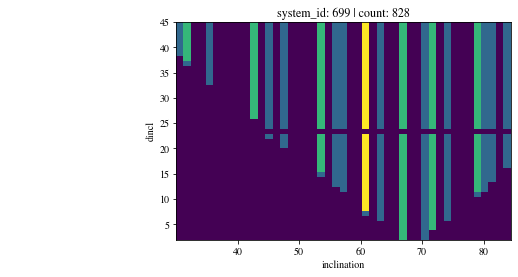

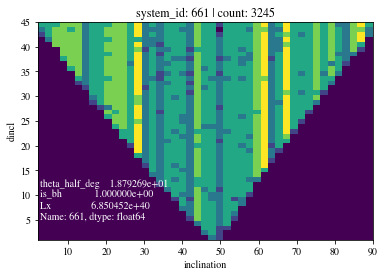

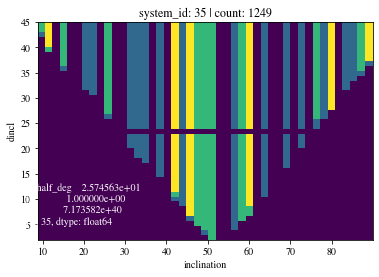

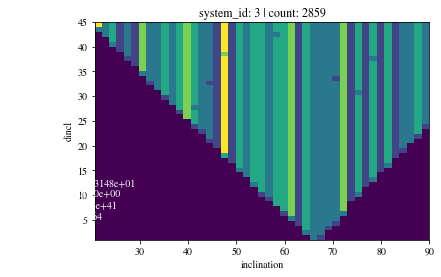

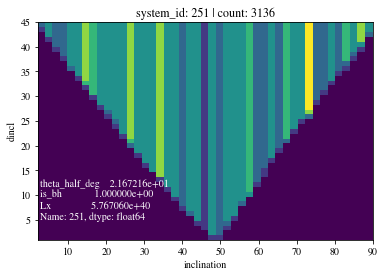

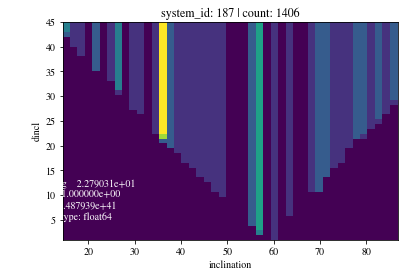

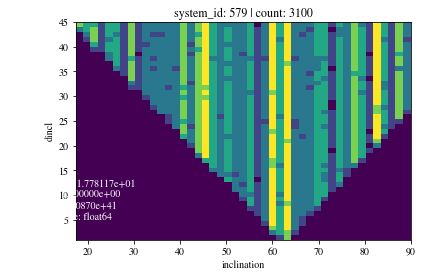

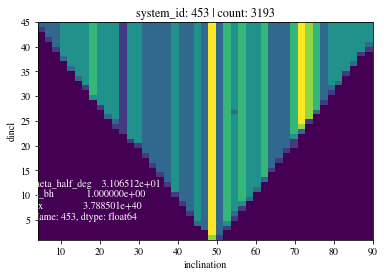

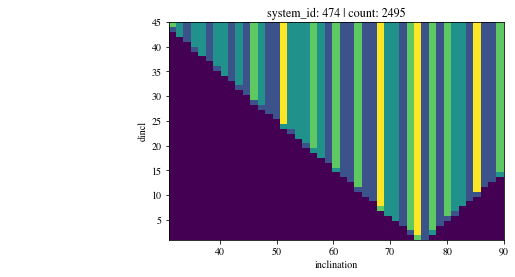

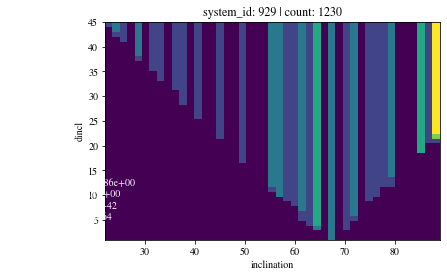

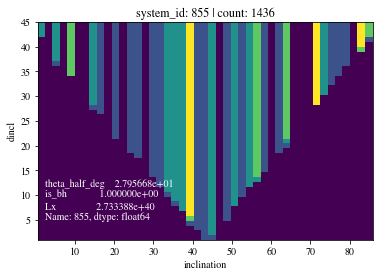

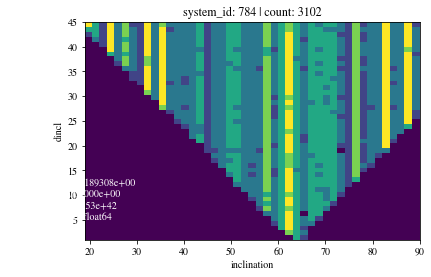

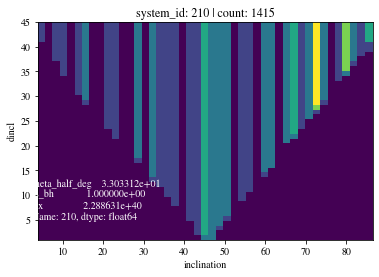

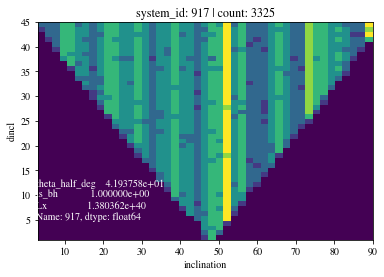

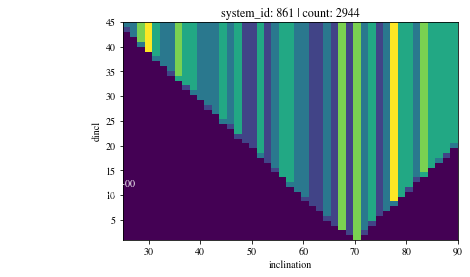

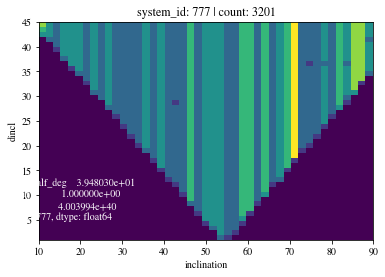

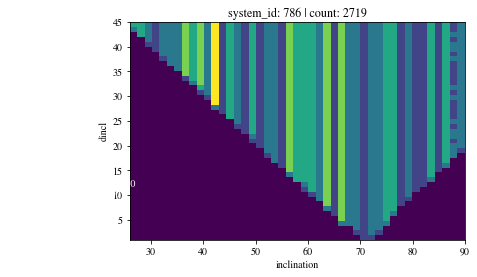

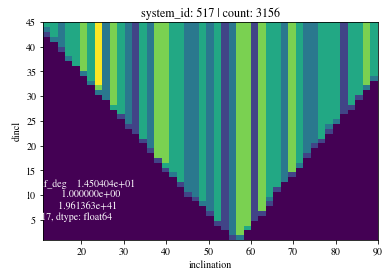

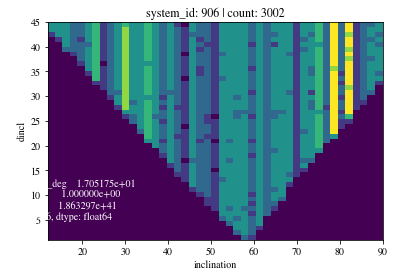

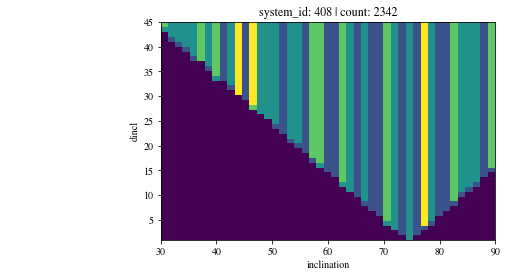

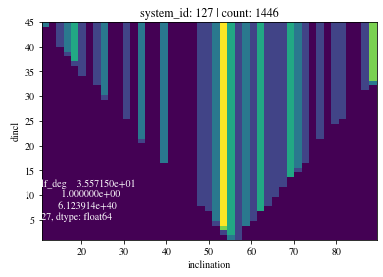

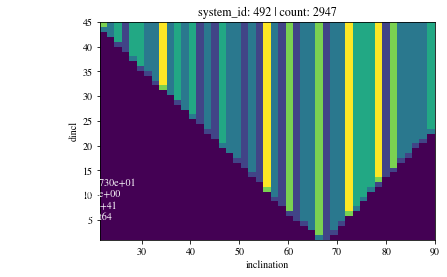

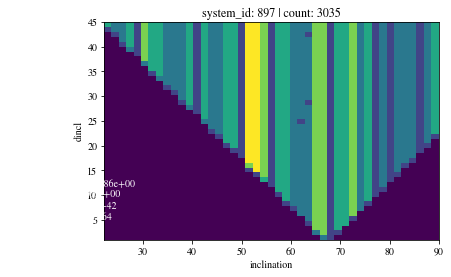

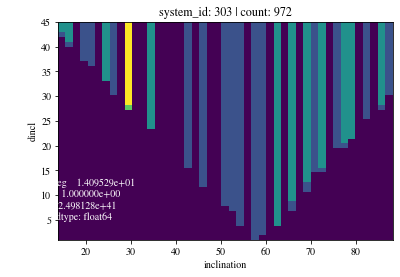

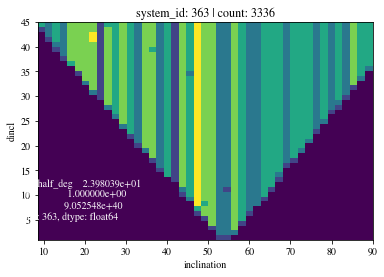

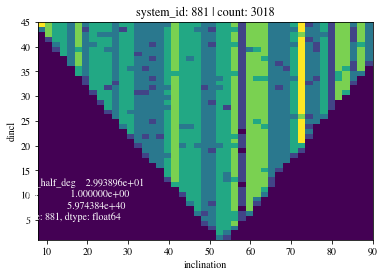

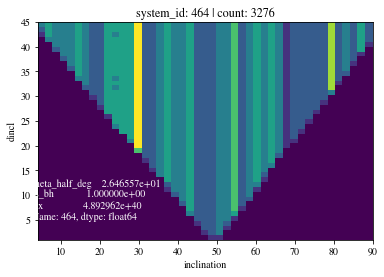

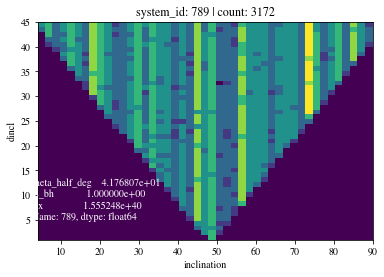

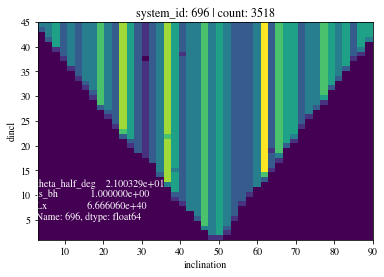

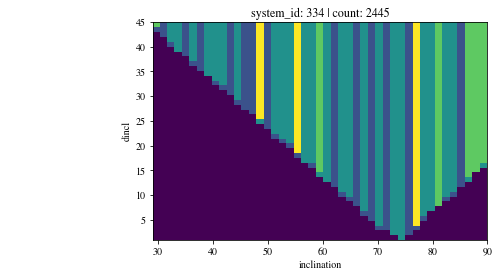

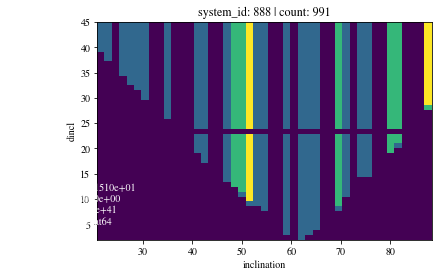

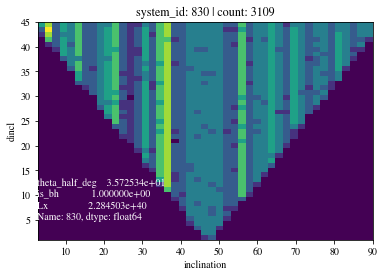

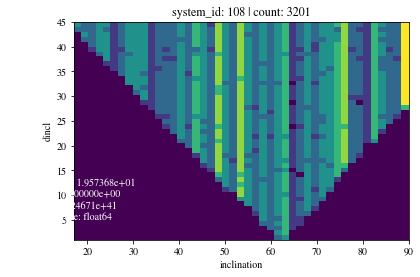

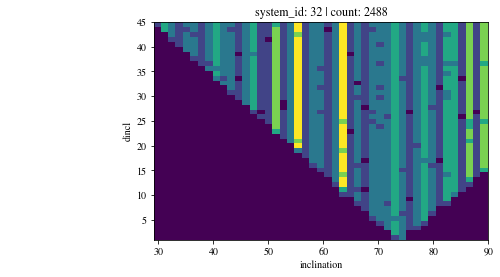

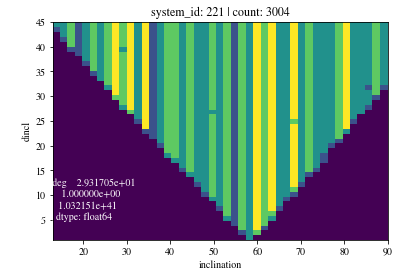

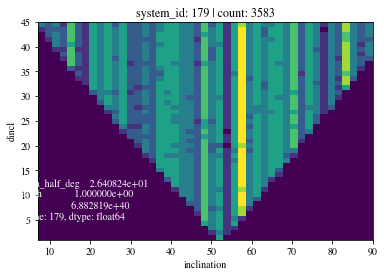

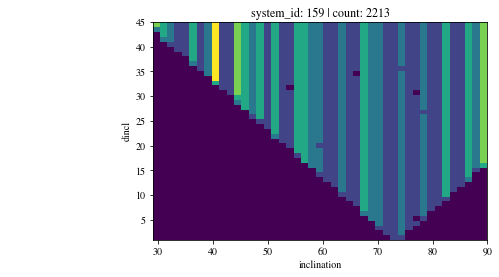

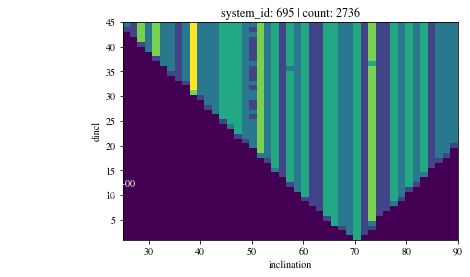

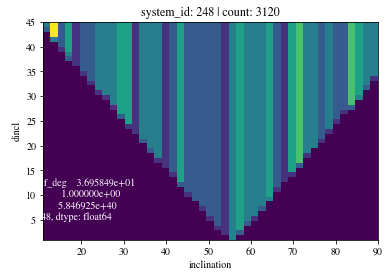

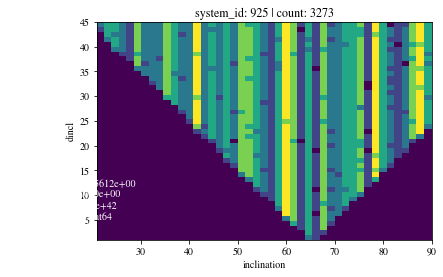

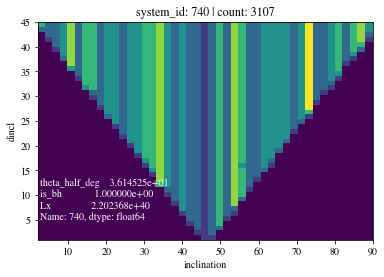

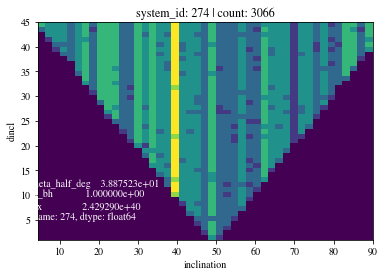

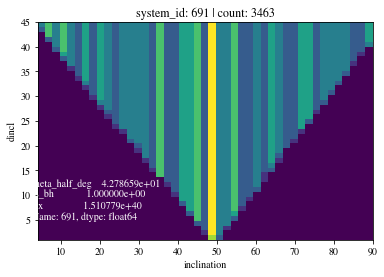

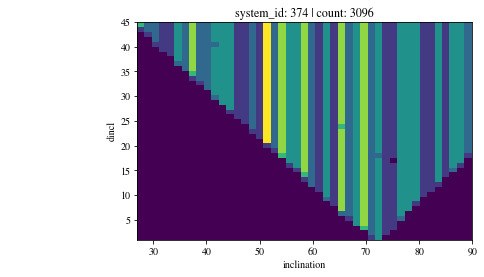

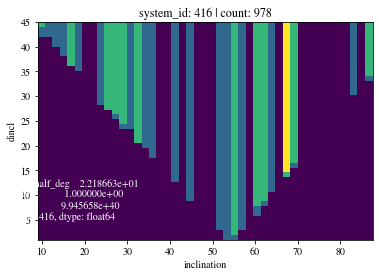

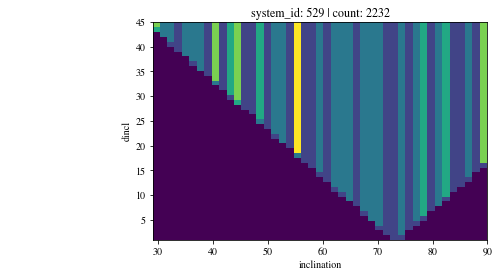

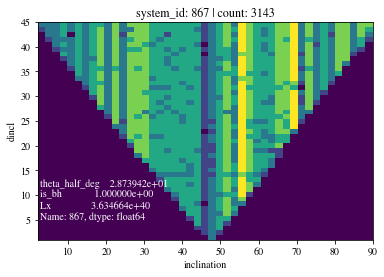

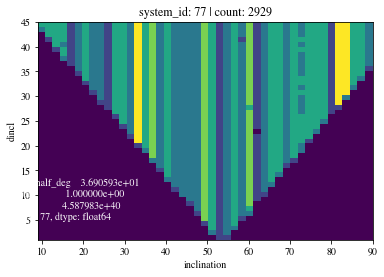

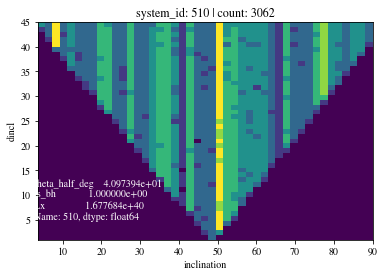

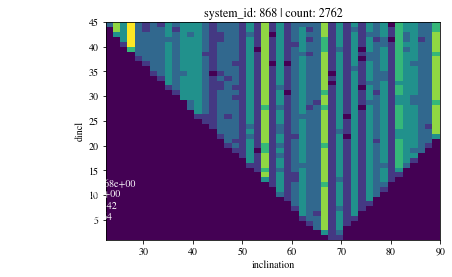

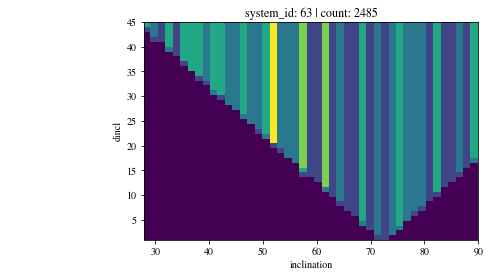

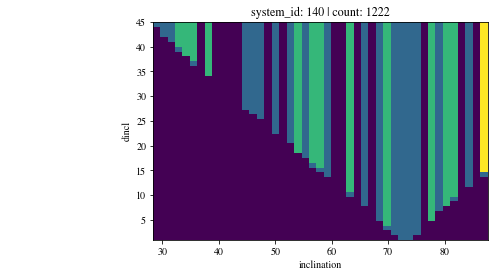

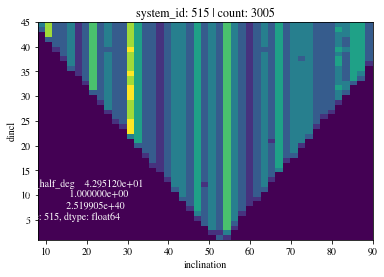

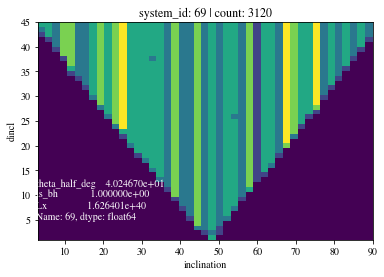

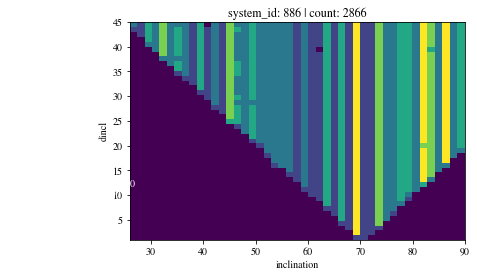

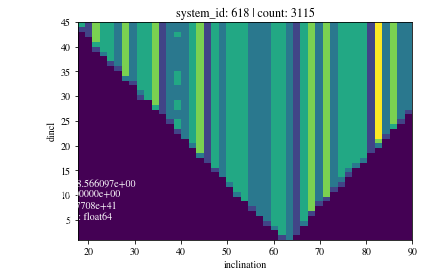

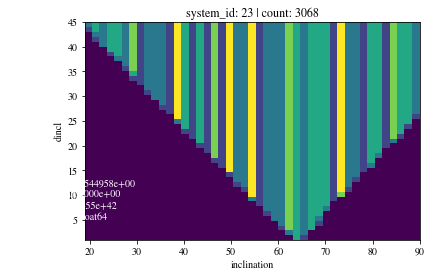

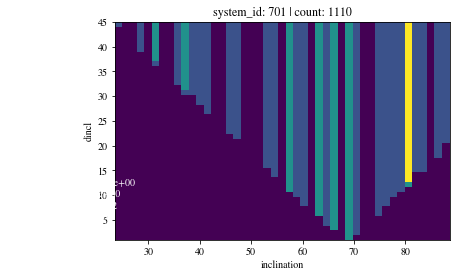

In [84]:
for i in df_a_transient['system_id'].unique():
    sub = df_a_transient[df_a_transient['system_id'] == i]
    plt.figure()
    plt.xlim(0, 90)
    plt.title('system_id: ' + str(i)+' | count: '+str(len(sub)))
    plt.text(x=2.5, y= 5, s=str(systems_df.iloc[i][columns_of_interest]), color='white')
    plt.xlabel('inclination')
    plt.ylabel('dincl')
    plt.hist2d(sub['inclination'], sub['dincl'], bins=45)

# How many ULXs will eROSITA see?

A first calculation we may perform is what percentage of our ULX population we will be able to see purely due to beaming.

the beaming factor, b, for random inclination essentially provides the probability of observing the source down the cone, since it is a ratio of the solid angle of a sphere to the size subtended by the two cones.

We may hence obtain a very crude upper limit for the number of ULXs observed by eRosita in the following manner:

For our sample of binary systems, we can calculate what percentage of them are ULXs, and what percentage of them are above the eROSITA detection threshold.

If we know how many binary systems eROSITA is predicted to observe, we can find what percentage of them would be ULXs from greg's population synthesis, 

number_of_ulxs/number_of_systems_above_erosita_threshold = number_of_observed_ulxs/number_of_observed_binary_systems

https://www.eso.org/sci/meetings/2012/surveys2012/Presentations/Day4-Thursday/Merloni.pdf slide 18 has the eROSITA limits as a function of each observing cycle in units erg/s/cm^2

https://www.aanda.org/articles/aa/pdf/2014/07/aa23766-14.pdf performed simulations on the number of XRBs that would be detected by eROSITA



In [85]:
#ULXs only
all_systems_df = load_systems_dataframe(False, False, False)
systems_df = load_systems_dataframe(True, False, False)
print(f'number of binary systems: {len(all_systems_df)}')
print(f'number of ULXs: {len(systems_df)} ({round(len(systems_df)/len(all_systems_df)*100, 3)}% of all systems)')
b_sum = systems_df['b'].sum()
print(f'number of visible ULXs: {round(b_sum,0)} ({round(b_sum/len(systems_df)*100,2)}% of all ULXs)')

number of binary systems: 36420
number of ULXs: 992 (2.724% of all systems)
number of visible ULXs: 823.0 (83.01% of all ULXs)


In [86]:
#EROSITA_stats
MEGA_PARSEC = 3.08567758E18*1E6 # cm
erosita = pd.DataFrame()
erosita['cycle_number'] = [1,2,3,4,8]
erosita['f_lim'] = [4.5E-14, 2.8E-14, 2.1E-14, 1.8E-14, 1.1E-14] #0.5 - 2Kev erg/cm^2/s
erosita['ULX_D_lim'] = np.sqrt(1E39/(4*np.pi*erosita['f_lim'])) #cm
erosita['ULX_D_lim_Mpc'] = erosita['ULX_D_lim']/MEGA_PARSEC
erosita['number_of_galaxies'] = [1525, 2594, 3519, 4109, 6306] #from Daniel, https://www.overleaf.com/read/tsdhqsdtvffh

erosita

cycle_number         f_lim     ULX_D_lim  ULX_D_lim_Mpc  number_of_galaxies
0             1  4.500000e-14  4.205221e+25      13.628193                1525
1             2  2.800000e-14  5.331090e+25      17.276888                2594
2             3  2.100000e-14  6.155813e+25      19.949631                3519
3             4  1.800000e-14  6.649038e+25      21.548065                4109
4             8  1.100000e-14  8.505478e+25      27.564377                6306

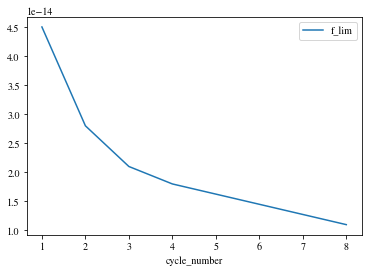

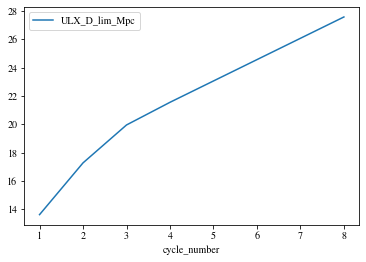

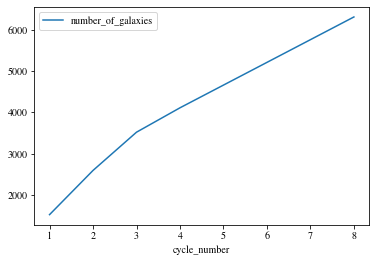

In [87]:
erosita.plot(x='cycle_number', y='f_lim')
erosita.plot(x='cycle_number', y='ULX_D_lim_Mpc')
erosita.plot(x='cycle_number', y='number_of_galaxies')

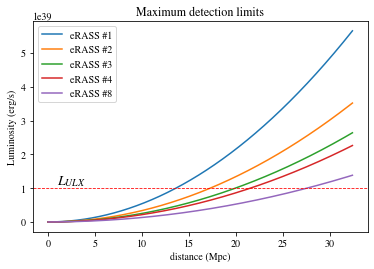

In [88]:
def L(D, f_lim):
    return 4 * np.pi * D**2 * f_lim

erosita.f_lim[0]
x = np.linspace(1e23, 1e26, 1000)
y = L(x, erosita.f_lim[0])
x_mpc = x/MEGA_PARSEC

# plt.figure(figsize=(4,3))
plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.15)
plt.plot(x_mpc, L(x, erosita.f_lim[0]), label='eRASS #1')
plt.plot(x_mpc, L(x, erosita.f_lim[1]), label='eRASS #2')
plt.plot(x_mpc, L(x, erosita.f_lim[2]), label='eRASS #3')
plt.plot(x_mpc, L(x, erosita.f_lim[3]), label='eRASS #4')
plt.plot(x_mpc, L(x, erosita.f_lim[4]), label='eRASS #8')
plt.legend()

plt.title('Maximum detection limits')
plt.xlabel('distance (Mpc)')
plt.ylabel('Luminosity (erg/s)')

plt.text(x=1, y=1.1e39, s=r'$L_{ULX}$', fontsize=14)
plt.axhline(1e39, c='red', linestyle='--', linewidth=0.8)
#plt.savefig('figures/erosita_detection_limits.png', dpi=200)
#plt.savefig('figures/erosita_detection_limits.eps')


## ULXLC Lightcurve estimate
One suggestion from Matt was to fold in the precession period of a Lense-Thirring cycle into the light curves obtained from ULXLC and then perform a 4 year simulation of the times it would have been observed using eROSITA.

Since all of our curves are normalised to have an period of 10 abitrary units, we can normalise a given curve to a given period in the following manner:
    
$$curve['Time'] = curve['Time'] / 10 * P_{wind}$$

With a lightcurve normalised to have a period equal to Lense-Thirring precession cycle, we can then simulate the
source being instantaneously observed 8 times with equal intervals of 6 months.

We will obtain the following:

| Observation # | Flux_value (erg/s) | Is ULX? |
|---------------|--------------------|---------|
| 1             | 3e39               | True    |
| 2             | 1.5e39             | True    |
| 3             | 7e38               | False   |
| ...           | ...                | ...     |
| 8             | 1.6e39             | True    |
    
In a flux-limited survey such as eROSITA, the limiting distance for a source being detected would be given by:
 
$$D_{lim} = \sqrt{L_{x, app} / 4 \pi f_{lim}}$$

see: https://arxiv.org/pdf/1811.08998.pdf section 4 & https://eprints.soton.ac.uk/414471/1/population_v2.pdf

Doing this for an ensamle of ULXs, could maybe obtain something like:

| Source | is_bh | Lx     |#_observed_as_ULX| Prob_ULX_obs | D_lim RASS #1 | D_lim RASS #2 |
|--------|-------|--------|-----------------|--------------|---------------|---------------|
| 913    | True  | 3e39   |2$\pm$0.2        | 0.3$\pm$0.03 | 2Mpc          | 3Mpc          |
| 217    | False | 1.7e39 |7$\pm$0.3        | 0.9$\pm$0.02 | 1.5Mpc        | 2Mpc          |
| 316    | True  | 4e40   |8$\pm$0.001      | 1.0$\pm$0.001| 3Mpc          | 3.7Mpc        |
    
Talking to Adam, basically I need to define my question better...
    
    For a given ULX, what is the probability that eROSITA will observe the source as a ULX?
        --> if f_lim < 1e39 This is set by the alive/dead ratio calculated for each source?
        
    (At a given distance,) How many ULXs will eROSITA see?
    (At a given distance,) What percentage of the ULX population will eROSITA see?
    (At a given distance,) What percentage of our artificial ULX population will eROSITA see?

However a suggestion was to cut all my lightcurves at the ULX limit, then add on the eROSITA limiting flux,
if f_lim < 1e39 --> we will always be able to detect the source when it is in the ULX state
if f_lim > 1e39 --> We will only be able to detect the source if it is above 1e39

There are a few numbers that we need eg:
Number of ULX systems = Number_of_alive_systems + Number_of_transient_systems

Number of ULXs that could have been detected = Number_of_alive_systems + Percentage of time as ULX * Number_of_transient_systems

Number_of_ulxs detected by eROSITA = Number of ULXs that could have been detected * percentage of time above detection threshold

For a fixed distance:
$$N_{ULX} = N_{alive} + N_{transient} + N_{dead}$$
$$N_{Detectable} = N_{alive} + \sum^{N_{transient}}_{n=1}P_{alive}(n)$$

$$N_{Detected} = N_{Detectable} * P_{detection}$$

$$P_{detection} = ?$$

$$ \%_{detected} = N_{Detected} / N_{Detectable}$$



## Effect of chaning the flux limit on the alive/dead time
We have upto now only considered the alive/dead/transient ULXs as defined by the 1e39 erg/s flux limit.

Each eRASS cycle, deeper fluxes will be probed, and equiviliently, further distances...


# Looking at Earnshaw ULX cat to obtain constraints on alive/dead/transient sources

In [91]:
from astropy.io import fits

In [92]:
ulx_file = '../data/external/Earnshaw_ULX_cat/earnshaw_Xraycatalogue.fits'
with fits.open(ulx_file) as hdul:
    #hdul.info()
    data = pd.DataFrame(hdul[1].data)

In [93]:
data

DETID   SRCID    DR3SRCID    DR3DETID  DR3DETDIST  DR3SRCDIST  DR3MULT  \
0        382  118684         156         156    3.412370    3.412370        1   
1        396  118656         163         163    1.785300    1.785300        1   
2        410  118560         170         170    0.752346    0.752346        1   
3        430  118540         178         178    2.738700    2.738700        1   
4       5169  122027        2335        2497    1.099720    1.099720        1   
...      ...     ...         ...         ...         ...         ...      ...   
2134  525383   43541      189988 -2147483648         NaN    2.288190        2   
2135  525632  236202      190090      245060    1.201990    1.201990        1   
2136  527019  241323 -2147483648 -2147483648         NaN         NaN   -32768   
2137  529799  239871      191027      246016    0.586219    0.586219        1   
2138  529821  239945      191045      246034    1.611630    1.611630        1   

                    IAUNAME  SRC_NUM      OBS_ID REVOLUT     MJD_START  \
0     3XMM J000155.3-152551       26  0204790101    0740  52996.978380   
1     3XMM J000158.1-152758        3  0204790101    0740  52996.978380   
2     3XMM J000201.4-153034        8  0204790101    0740  52996.978380   
3     3XMM J000205.0-152504        9  0204790101    0740  52996.978380   
4     3XMM J002012.0+591756       79  0152260101    0653  52823.765810   
...                     ...      ...         ...     ...           ...   
2134  3XMM J233843.6-562849       25  0677770133    2280  56068.510590   
2135  3XMM J234000.7-121708       18  0055990301    0361  52241.631181   
2136  3XMM J234420.0+095548       24  0301651001    1010  53536.690347   
2137  3XMM J235122.5+200638        9  0093190301    0464  52446.823507   
2138  3XMM J235127.4+200651       11  0093190301    0464  52446.823507   

          MJD_STOP  OBS_CLASS PN_FILTER M1_FILTER M2_FILTER  \
0     52997.094537          2    Medium    Medium    Medium   
1     52997.094537          2    Medium    Medium    Medium   
2     52997.094537          2    Medium    Medium    Medium   
3     52997.094537          2    Medium    Medium    Medium   
4     52824.270845          1    Thin1     Thin1     Thin1    
...            ...        ...       ...       ...       ...   
2134  56068.655822          1    Thin1     Thin1     Thin1    
2135  52241.746898          3    Thin1     Thin1     Thin1    
2136  53536.847153          0    Thin1     Thin1     Thin1    
2137  52447.173634          1    Medium    Medium    Medium   
2138  52447.173634          1    Medium    Medium    Medium   

                   PN_SUBMODE        M1_SUBMODE        M2_SUBMODE          RA  \
0     PrimeFullWindow          PrimeFullWindow   PrimeFullWindow     0.480486   
1     PrimeFullWindow          PrimeFullWindow   PrimeFullWindow     0.492083   
2     PrimeFullWindow          PrimeFullWindow   PrimeFullWindow     0.505846   
3     PrimeFullWindow          PrimeFullWindow   PrimeFullWindow     0.520970   
4     PrimeFullWindow          PrimeFullWindow   PrimeFullWindow     5.050383   
...                       ...               ...               ...         ...   
2134  PrimeFullWindow          PrimeFullWindow   PrimeFullWindow   354.682300   
2135  PrimeFullWindowExtended  PrimeFullWindow   PrimeFullWindow   355.003093   
2136  PrimeFullWindow          PrimeFullWindow   PrimeFullWindow   356.083475   
2137  PrimeFullWindow          PrimeFullWindow   PrimeFullWindow   357.843986   
2138  PrimeFullWindow          PrimeFullWindow   PrimeFullWindow   357.864360   

            DEC    POSERR         LII        BII  RADEC_ERR  SYSERRCC  REFCAT  \
0    -15.430893  2.085040         NaN        NaN   1.802110  1.048700       3   
1    -15.466188  1.221490   75.849334 -73.627990   0.667121  1.023230       3   
2    -15.509513  1.438810   75.780062 -73.668888   1.008810  1.025910       3   
3    -15.417996  1.483580   76.037464 -73.611171   1.046820  1.051270       3   
4     59.2

In [94]:
# Filter to only include ULXs
data = data[data['EP_8_LUMINOSITY_MAX'] >1E39]
data

DETID   SRCID    DR3SRCID    DR3DETID  DR3DETDIST  DR3SRCDIST  DR3MULT  \
10      5465  120330        2609        2771    0.631002    0.631002        1   
23     10627  113227 -2147483648 -2147483648         NaN         NaN   -32768   
24     10659   41140        4975        5556    1.934730    1.794490        2   
25     10658   41140        4975 -2147483648         NaN    1.794490        2   
59     11937  116018        5292        5878    6.893850    6.893850        1   
...      ...     ...         ...         ...         ...         ...      ...   
2134  525383   43541      189988 -2147483648         NaN    2.288190        2   
2135  525632  236202      190090      245060    1.201990    1.201990        1   
2136  527019  241323 -2147483648 -2147483648         NaN         NaN   -32768   
2137  529799  239871      191027      246016    0.586219    0.586219        1   
2138  529821  239945      191045      246034    1.611630    1.611630        1   

                    IAUNAME  SRC_NUM      OBS_ID REVOLUT     MJD_START  \
10    3XMM J002121.2-483827       33  0152330101    0557  52632.895845   
23    3XMM J003739.2-334249       40  0200800101    0919  53353.859803   
24    3XMM J003742.4-334249       44  0200800201    0998  53511.475324   
25    3XMM J003742.4-334249       48  0200800101    0919  53353.859803   
59    3XMM J003933.9+005152       32  0203690101    0925  53365.828634   
...                     ...      ...         ...     ...           ...   
2134  3XMM J233843.6-562849       25  0677770133    2280  56068.510590   
2135  3XMM J234000.7-121708       18  0055990301    0361  52241.631181   
2136  3XMM J234420.0+095548       24  0301651001    1010  53536.690347   
2137  3XMM J235122.5+200638        9  0093190301    0464  52446.823507   
2138  3XMM J235127.4+200651       11  0093190301    0464  52446.823507   

          MJD_STOP  OBS_CLASS PN_FILTER M1_FILTER M2_FILTER  \
10    52633.418391          1    Medium    Medium    Medium   
23    53354.271181          0    Thin1     Thin1     Thin1    
24    53512.158611          1    Thin1     Thin1     Thin1    
25    53354.271181          0    Thin1     Thin1     Thin1    
59    53366.373032          1    Thin1     Thin1     Thin1    
...            ...        ...       ...       ...       ...   
2134  56068.655822          1    Thin1     Thin1     Thin1    
2135  52241.746898          3    Thin1     Thin1     Thin1    
2136  53536.847153          0    Thin1     Thin1     Thin1    
2137  52447.173634          1    Medium    Medium    Medium   
2138  52447.173634          1    Medium    Medium    Medium   

                   PN_SUBMODE        M1_SUBMODE        M2_SUBMODE          RA  \
10    PrimeFullWindow          PrimeFullWindow   PrimeFullWindow     5.338510   
23    PrimeFullWindow          PrimeFullWindow   PrimeFullWindow     9.413474   
24    PrimeFullWindow          PrimeFullWindow   PrimeFullWindow     9.426931   
25    PrimeFullWindow          PrimeFullWindow   PrimeFullWindow     9.426724   
59    PrimeFullWindow          PrimeFullWindow   PrimeFullWindow     9.891359   
...                       ...               ...               ...         ...   
2134  PrimeFullWindow          PrimeFullWindow   PrimeFullWindow   354.682300   
2135  PrimeFullWindowExtended  PrimeFullWindow   PrimeFullWindow   355.003093   
2136  PrimeFullWindow          PrimeFullWindow   PrimeFullWindow   356.083475   
2137  PrimeFullWindow          PrimeFullWindow   PrimeFullWindow   357.843986   
2138  PrimeFullWindow          PrimeFullWindow   PrimeFullWindow   357.864360   

            DEC    POSERR         LII        BII  RADEC_ERR  SYSERRCC  REFCAT  \
10   -48.641028  1.122750  316.113978 -67.710084   1.078440  0.312287       3   
23   -33.713733  1.266470  326.362496 -82.776149   1.218060  0.346813       3   
24   -33.713740  1.373120  326.281917 -82.780993   1.350080  0.250532       3   
25   -33.713910  1.283460  326.282552 -82.780678   1.236210  0.345033       3   
59     0.8

In [95]:
#Sources with more than 1 obervation
sources = data['SRCID'].value_counts()[data['SRCID'].value_counts() > 1].sort_values(ascending=False)
sources

894      13
1915     11
2049     10
2231     10
4349      7
5218      6
6996      5
901       5
3129      5
8508      5
4170      5
10333     4
14633     4
10918     4
10328     4
3374      4
3437      4
13415     4
10388     4
5219      4
15989     3
16088     3
17098     3
4101      3
16342     3
5231      3
16021     3
15621     3
4934      3
16132     3
8408      3
19949     3
16647     3
28571     2
35311     2
7245      2
35286     2
28451     2
28943     2
43541     2
21337     2
51071     2
17151     2
3277      2
42210     2
3330      2
5412      2
28995     2
58403     2
30058     2
48298     2
29174     2
3875      2
30164     2
28355     2
29687     2
56162     2
34759     2
28544     2
28555     2
35211     2
28876     2
28744     2
29871     2
45684     2
51654     2
29901     2
18115     2
22268     2
17868     2
31024     2
41140     2
5256      2
17412     2
6155      2
4120      2
29739     2
29749     2
32833     2
29790     2
34447     2
Name: SRCID, dtype: int64

In [96]:
src901 = data[data['SRCID'] == 901].sort_values(by=['MJD_START'])
src901

DETID  SRCID  DR3SRCID    DR3DETID  DR3DETDIST  DR3SRCDIST  DR3MULT  \
622  87552    901     29246 -2147483648         NaN    0.092017       16   
618  87537    901     29246       37100    0.739589    0.092017       16   
623  87542    901     29246 -2147483648         NaN    0.092017       16   
619  87538    901     29246       37101    0.642394    0.092017       16   
610  87543    901     29246       37106    0.506371    0.092017       16   

                   IAUNAME  SRC_NUM      OBS_ID REVOLUT     MJD_START  \
622  3XMM J031818.4-663002        5  0150280201    0732  52982.258611   
618  3XMM J031818.4-663002        4  0150280501    0740  52998.199745   
623  3XMM J031818.4-663002        4  0150280701    0741  53000.172975   
619  3XMM J031818.4-663002        4  0150281101    0752  53021.001354   
610  3XMM J031818.4-663002        4  0205230501    0908  53332.307419   

         MJD_STOP  OBS_CLASS PN_FILTER M1_FILTER M2_FILTER  \
622  52982.325046          0    Thin1     Thin1     Thin1    
618  52998.378194          1    Thin1     Thin1     Thin1    
623  53000.367153          1    Thin1     UNDEF     UNDEF    
619  53021.082789          1    Thin1     Thin1     Thin1    
610  53332.471042          1    Thin1     Thin1     Thin1    

                  PN_SUBMODE        M1_SUBMODE        M2_SUBMODE         RA  \
622  PrimeFullWindow          PrimeFullWindow   PrimeFullWindow   49.577454   
618  PrimeFullWindow          PrimeFullWindow   PrimeFullWindow   49.575739   
623  PrimeFullWindow          UNDEFINED         UNDEFINED         49.576738   
619  PrimeFullWindow          PrimeFullWindow   PrimeFullWindow   49.575932   
610  PrimeFullWindow          PrimeFullWindow   PrimeFullWindow   49.576756   

           DEC    POSERR         LII        BII  RADEC_ERR  SYSERRCC  REFCAT  \
622 -66.500166  2.075780  283.356756 -44.638559   1.434880  1.500000      -1   
618 -66.500806  0.814643  283.358163 -44.638291   0.467594  0.667083       3   
623 -66.500933  1.752740  283.357833 -44.638259   0.906703  1.500000      -2   
619 -66.500873  0.844703  283.358021 -44.638177   0.466052  0.704498       3   
610 -66.500961  0.783129  283.357677 -44.637759   0.334140  0.708267       3   

     POSCOROK     RA_UNC    DEC_UNC     EP_1_FLUX  EP_1_FLUX_ERR  \
622     False  49.577471 -66.500185  2.897850e-15   3.031080e-15   
618      True  49.576308 -66.501112  5.495660e-15   1.218650e-15   
623     False  49.576759 -66.500958  4.276660e-15   2.005550e-15   
619      True  49.576690 -66.501112  6.802200e-15   1.754460e-15   
610      True  49.577882 -66.501207  7.049790e-15   9.723520e-16   

        EP_2_FLUX  EP_2_FLUX_ERR     EP_3_FLUX  EP_3_FLUX_ERR     EP_4_FLUX  \
622  1.337030e-14   6.263950e-15  3.697070e-14   1.059680e-14  1.565550e-14   
618  3.227290e-14   2.953280e-15  5.802640e-14   4.079060e-15  9.241180e-14   
623  2.588910e-14   4.145970e-15  3.531330e-14   6.504120e-15  9.333690e-14   
619  3.268520e-14   3.921360e-15  6.007070e-14   5.460520e-15  1.055400e-13   
610  3.253940e-14   2.258700e-15  5.719340e-14   3.193910e-15  1.010920e-13   

     EP_4_FLUX_ERR     EP_5_FLUX  EP_5_FLUX_ERR     EP_8_FLUX  EP_8_FLUX_ERR  \
622   1.497080e-14  1.548190e-13   1.693040e-13  2.612020e-13   1.715000e-13   
618   9.016770e-15  1.850670e-13   3.433560e-14  3.732680e-13   3.597600e-14   
623   2.081700e-14  1.888590e-13   1.028190e-13  3.476750e-13   1.052080e-13   
619   1.208210e-14  1.797150e-13   4.273380e-14  3.819240e-13   4.510720e-14   
610   6.874950e-15  2.028190e-13   2.481970e-14  4.011020e-13   2.610380e-14   

        EP_9_FLUX  EP_9_FLUX_ERR     PN_1_FLUX  PN_1_FLUX_ERR     PN_2_FLUX  \
622  9.924130e-14   4.369630e-13  9.017580e-15   5.346940e-15  1.128850e-14   
618  1.726050e-13   2.775910e-13  7.614540e-15   1.753000e-15  3.268280e-14   
623  1.303020e-13   3.177540e-13  4.276660e-15   2.005550e-15  2.588910e-14   
619  1.847100e-13   1.118170e-14  7.970910e-15   2.212110e-15  3.392670e-14   
610  2.660720e-13   

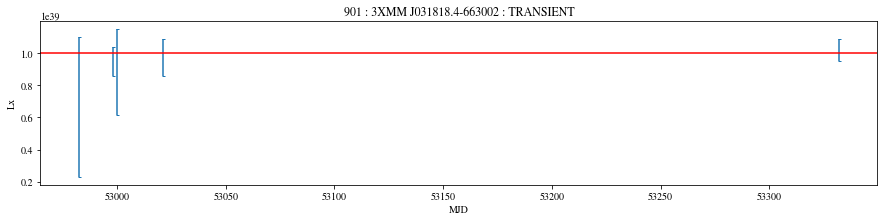

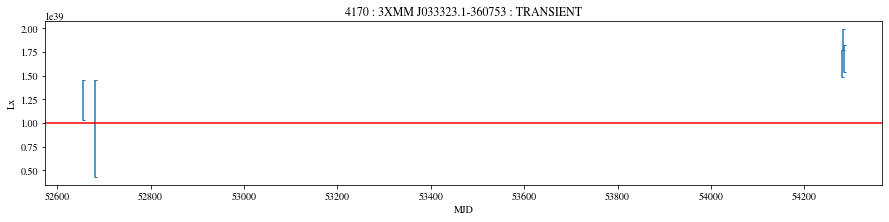

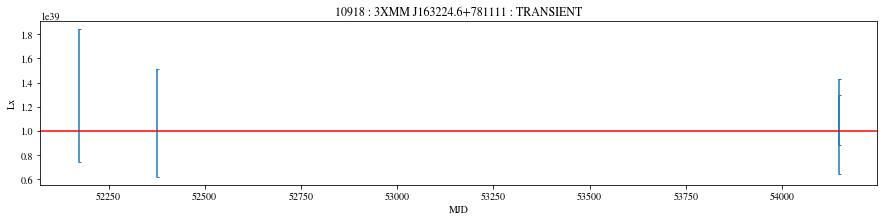

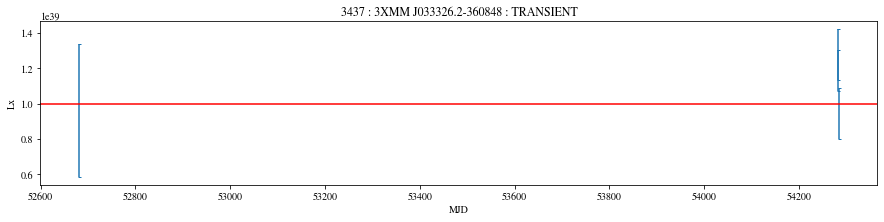

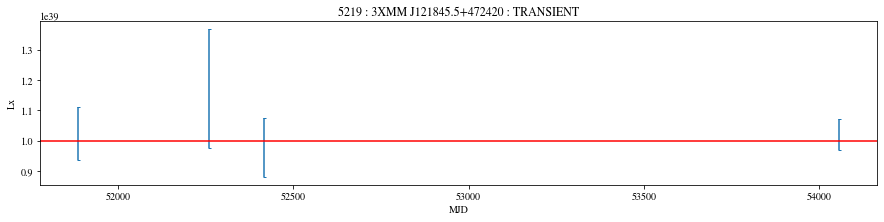

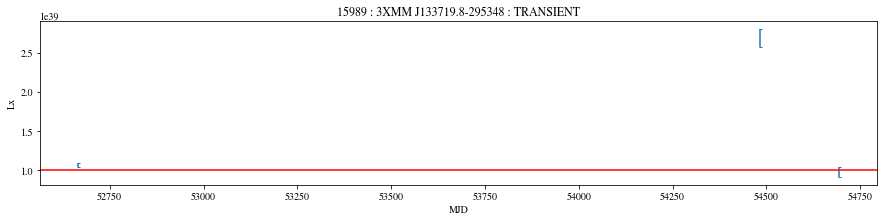

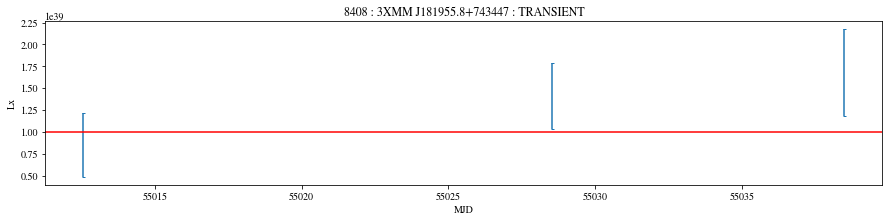

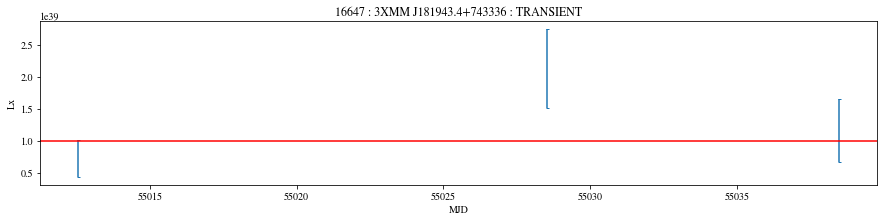

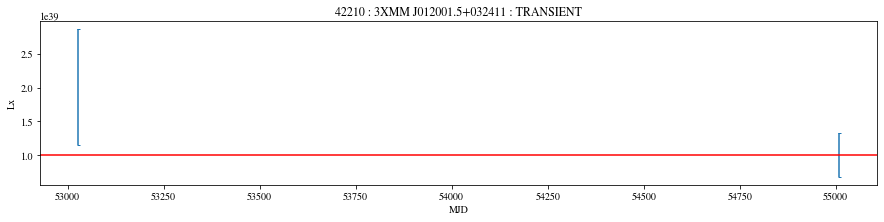

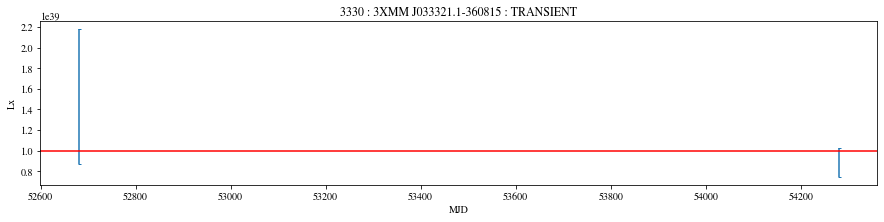

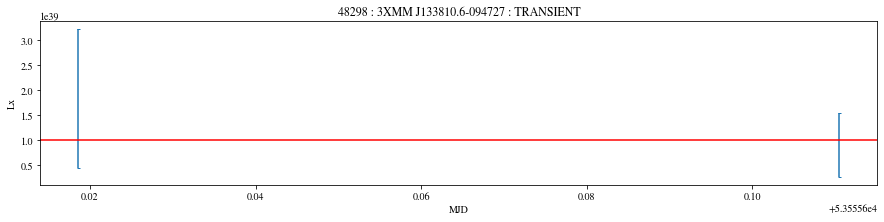

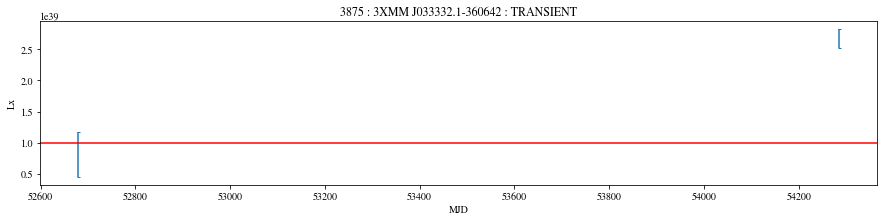

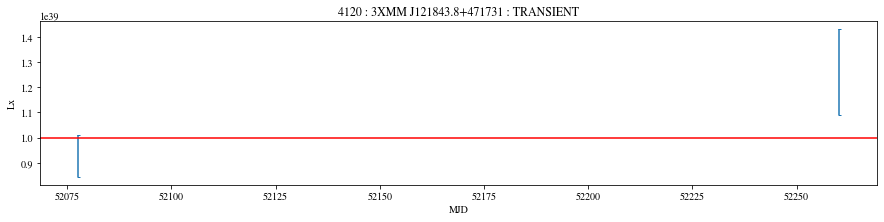

In [97]:
number_of_transients = 0
number_of_dead = 0
number_of_alive = 0
flux_limit = 1E39

for source in sources.index:
    subset = data[data['SRCID'] == source].sort_values(by=['MJD_START'])
    if max(subset['EP_8_LUMINOSITY']) > flux_limit and min(subset['EP_8_LUMINOSITY']) < flux_limit: #TRANSIENT
        plt.figure(figsize=(15,3))
        plt.ylabel('Lx')
        plt.xlabel('MJD')
        plt.title(str(subset['SRCID'].unique()[0]) + ' : ' + subset['IAUNAME'].unique()[0] + ' : TRANSIENT')
        plt.errorbar(subset['MJD_START'], subset['EP_8_LUMINOSITY'], yerr=subset['EP_8_LUMINOSITY_ERR'], fmt='none', capsize=1.5)
        plt.axhline(flux_limit, c='red')
        number_of_transients+=1
    elif max(subset['EP_8_LUMINOSITY_MAX']) < flux_limit: #DEAD
        number_of_dead+=1
    elif min(subset['EP_8_LUMINOSITY'] - subset['EP_8_LUMINOSITY_ERR']) > flux_limit: #Alive
        number_of_alive+=1

## Monte-Carlo Lightcurve sampling

In [98]:
# Monte carlo simulation on the obtained lightcurves to deduce
# To what degree we can characterise a lightcurve as being
# Alive/dead/transient
MC_ITERATIONS = 100000

results_list = []

for source in sources.index:
    results = {}
    alive = 0
    dead = 0
    transient = 0
    print(f'Doing source: {source}')
    subset = data[data['SRCID'] == source].sort_values(by=['MJD_START'])
    simulated_luminosities = []
    
    for index, row in subset.iterrows():
        # print(f"index: {index} ep 8 luminosity: {row['EP_8_LUMINOSITY']}, err: {row['EP_8_LUMINOSITY_ERR']}")
        sample = np.random.normal(loc=row['EP_8_LUMINOSITY'], scale=row['EP_8_LUMINOSITY_ERR'], size=MC_ITERATIONS)
        simulated_luminosities.append(sample)
    
    for i in (np.array(simulated_luminosities).T):
        # print(f'out of {len(i)} points:')
        number_above = len(i[i > 1E39])
        number_below = len(i[i < 1E39])
        if number_below == 0:
            #print('alive')
            alive+=1
        elif number_above == 0:
            #print('dead')
            dead+=1
        else:
            #print(f'transient {number_above}, {number_below}')
            transient+=1
            
    results['SRCID'] = source
    results['alive'] = alive
    results['dead'] = dead
    results['transient'] = transient
    results_list.append(results)

Doing source: 894
Doing source: 1915
Doing source: 2049
Doing source: 2231
Doing source: 4349
Doing source: 5218
Doing source: 6996
Doing source: 901
Doing source: 3129
Doing source: 8508
Doing source: 4170
Doing source: 10333
Doing source: 14633
Doing source: 10918
Doing source: 10328
Doing source: 3374
Doing source: 3437
Doing source: 13415
Doing source: 10388
Doing source: 5219
Doing source: 15989
Doing source: 16088
Doing source: 17098
Doing source: 4101
Doing source: 16342
Doing source: 5231
Doing source: 16021
Doing source: 15621
Doing source: 4934
Doing source: 16132
Doing source: 8408
Doing source: 19949
Doing source: 16647
Doing source: 28571
Doing source: 35311
Doing source: 7245
Doing source: 35286
Doing source: 28451
Doing source: 28943
Doing source: 43541
Doing source: 21337
Doing source: 51071
Doing source: 17151
Doing source: 3277
Doing source: 42210
Doing source: 3330
Doing source: 5412
Doing source: 28995
Doing source: 58403
Doing source: 30058
Doing source: 48298
Doin

In [99]:
MC_results = pd.DataFrame(results_list)
MC_results['classification'] = MC_results[['alive','dead', 'transient']].idxmax(axis=1)
MC_results['confidence'] = MC_results[['alive','dead', 'transient']].max(axis=1)/MC_ITERATIONS
MC_results['confidence_squared'] = MC_results['confidence']**2
# https://faraday.physics.utoronto.ca/PVB/Harrison/ErrorAnalysis/Propagation.html

In [100]:
MC_results.sort_values(by='confidence')

SRCID   alive   dead  transient classification  confidence  \
65  51654   44344  10223      45433      transient     0.45433   
60  35211   45653   9027      45320          alive     0.45653   
61  28876   46297   8928      44775          alive     0.46297   
43   3277   48520   6943      44537          alive     0.48520   
44  42210   44003   5901      50096      transient     0.50096   
9    8508   51399      0      48601          alive     0.51399   
56  56162   51941   7829      40230          alive     0.51941   
50  48298   31974  15158      52868      transient     0.52868   
64  45684   59520   4928      35552          alive     0.59520   
36  35286   59686     38      40276          alive     0.59686   
10   4170   39818      0      60182      transient     0.60182   
57  34759   61712    489      37799          alive     0.61712   
15   3374   61815      0      38185          alive     0.61815   
20  15989   37807      0      62193      transient     0.62193   
45   3330   17238  16507      66255      transient     0.66255   
2    2049   68315      0      31685          alive     0.68315   
52   3875   29857      0      70143      transient     0.70143   
68  22268   70153    688      29159          alive     0.70153   
78  32833   72012     55      27933          alive     0.72012   
30   8408   26590    768      72642      transient     0.72642   
48  58403   73209   1820      24971          alive     0.73209   
75   4120   18141   5257      76602      transient     0.76602   
12  14633   77577      0      22423          alive     0.77577   
4    4349   78771      0      21229          alive     0.78771   
40  21337   79592    308      20100          alive     0.79592   
63  29871   80497    662      18841          alive     0.80497   
13  10918   13152   1976      84872      transient     0.84872   
19   5219   13333   1506      85161      transient     0.85161   
16   3437   14670     49      85281      transient     0.85281   
67  18115   87388     22      12590          alive     0.87388   
28   4934   88851      1      11148          alive     0.88851   
32  16647    9852   1041      89107      transient     0.89107   
29  16132   90013      0       9987          alive     0.90013   
31  19949   90183      0       9817          alive     0.90183   
71  41140   90782    218       9000          alive     0.90782   
7     901     558   8521      90921      transient     0.90921   
79  29790   91329      0       8671          alive     0.91329   
39  43541   91610     61       8329          alive     0.91610   
46   5412   95031      2       4967          alive     0.95031   
41  51071   95906      0       4094          alive     0.95906   
17  13415   98503      0       1497          alive     0.98503   
69  17868   98611      0       1389          alive     0.98611   
80  34447   99192      0        808          alive     0.99192   
72   5256   99194      0        806          alive     0.99194   
42  17151   99481      1        518          alive     0.99481   
55  29687   99611      0        389          alive     0.99611   
62  28744   99678      0        322          alive     0.99678   
34  35311   99753      1        246          alive     0.99753   
49  30058   99775      0        225          alive     0.99775   
51  29174   99864      0        136          alive     0.99864   
35   7245   99876      0        124          alive     0.99876   
76  29739   99974      0         26          alive     0.99974   
23   4101   99977      0         23          alive     0.99977   
8    3129   99984      0         16          alive     0.99984   
21  16088   99999      0          1          alive     0.99999   
33  28571   99999      0          1          alive     0.99999   
38  28943  100000      0          0          alive     1.00000   
6    6996  100000      0          0          alive     1.00000   
73  17412  100000      0          0          alive     1.00000   
5    5218  100000      0          0         

In [101]:
number_of_alive = len(MC_results[MC_results['classification'] == 'alive'])
number_of_alive_err = np.sqrt(MC_results[MC_results['classification'] == 'alive']['confidence_squared'].sum())
number_of_transients = len(MC_results[MC_results['classification'] == 'transient'])
number_of_transients_err = np.sqrt(MC_results[MC_results['classification'] == 'transient']['confidence_squared'].sum())
number_of_dead = len(MC_results[MC_results['classification'] == 'dead'])
number_of_dead_err = np.sqrt(MC_results[MC_results['classification'] == 'dead']['confidence_squared'].sum())


#The total number here is defined only for the alive and transient systems
number_total = number_of_alive + number_of_transients
number_total_err = np.sqrt(number_of_alive_err**2 + number_of_transients_err**2)

percent_of_alive = number_of_alive / (number_total)
percent_of_transients = number_of_transients / (number_total)
percent_of_alive_err = percent_of_alive * np.sqrt((number_total_err/number_total)**2 +  (number_of_alive_err/number_of_alive)**2)
percent_of_transients_err = percent_of_transients * np.sqrt((number_total_err/number_total)**2 +  (number_of_transients_err/number_of_transients)**2)

In [102]:
print(f'Number of alive systems: {number_of_alive} +- {number_of_alive_err}')
print(f'Number of transient systems: {number_of_transients} +- {number_of_transients_err}')
print(f'Number of dead systems: {number_of_dead} +- {number_of_dead_err}')
print(f'% of alive systems: {percent_of_alive} +- {percent_of_alive_err}')
print(f'% of transient systems: {percent_of_transients} +- {percent_of_transients_err}')

Number of alive systems: 67 +- 7.453172770015465
Number of transient systems: 14 +- 2.7064425635878546
Number of dead systems: 0 +- 0.0
% of alive systems: 0.8271604938271605 +- 0.12256980721883279
% of transient systems: 0.1728395061728395 +- 0.037452639118226674


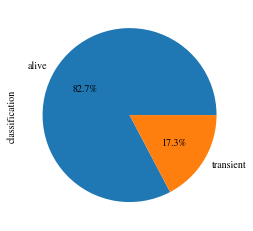

In [103]:
MC_results['classification'].value_counts().plot(kind='pie', autopct='%1.1f%%')

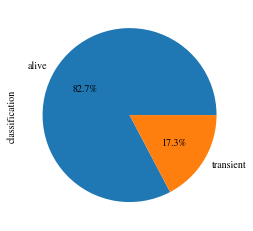

In [104]:
MC_results = MC_results[MC_results['classification'].isin(['transient', 'alive'])]
MC_results['classification'].value_counts().plot(kind='pie', autopct='%1.1f%%')

## Non-MC classification:

In [105]:
print(f'Objects in Earnshaw cat: {len(data["SRCID"].unique())}')
print(f'Objects with more than 1 observation: {len(sources)}')
print(f'Number of Transient ULXs: {number_of_transients}')
print(f'Number of alive ULXs: {number_of_alive}')
print(f'Number of dead ULXs: {number_of_dead}')

Objects in Earnshaw cat: 384
Objects with more than 1 observation: 81
Number of Transient ULXs: 14
Number of alive ULXs: 67
Number of dead ULXs: 0


([<matplotlib.patches.Wedge at 0x7fa4b80bd1d0>,
 [Text(-0.9417835605766091, 0.5683693561652007, 'alive'),
  Text(0.9417835339693184, -0.5683694002532701, 'transient'),
  Text(1.0999999999999954, -1.0298943298478347e-07, 'dead')],
 [Text(-0.5137001239508776, 0.31001964881738214, '82.7%'),
  Text(0.51370010943781, -0.31001967286542, '17.3%'),
  Text(0.5999999999999974, -5.617605435533643e-08, '0.0%')])

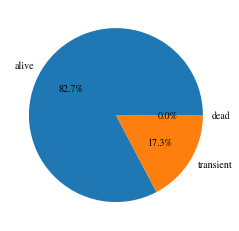

In [106]:
plt.pie([number_of_alive, number_of_transients, number_of_dead], labels=['alive', 'transient', 'dead',], autopct='%1.1f%%')

([<matplotlib.patches.Wedge at 0x7fa4bc1bc470>,
 [Text(-0.9417835605766091, 0.5683693561652007, 'alive'),
  Text(0.9417835339693184, -0.5683694002532701, 'transient')],
 [Text(-0.5137001239508776, 0.31001964881738214, '82.7%'),
  Text(0.51370010943781, -0.31001967286542, '17.3%')])

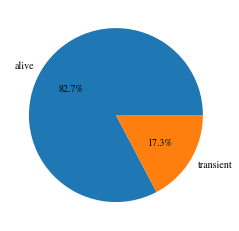

In [107]:
plt.pie([number_of_alive, number_of_transients], labels=['alive', 'transient'], autopct='%1.1f%%')